In [790]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
pd.set_option('display.float_format', lambda x : '%.2f' % x ) # virgülden sonra 2 basamak göster ayarı
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

**1 - Test ve Train olarak elimizde bulunan verisetlerinin birleştirilmesi**

In [568]:
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

In [570]:
test.shape

(1459, 80)

In [572]:
train.shape

(1460, 81)

In [574]:
df = pd.concat([train,test], ignore_index=True)

In [576]:
df.shape

(2919, 81)

**2 - Verisetine genel bakış**

In [579]:
def checkdf(data):
    print(data.shape,'\n\n')
    print(data.dtypes,'\n\n')
    print(data.head(),'\n\n')
    print(data.tail(),'\n\n')
    print(data.isnull().sum(),'\n\n')
    print(data.describe().T,'\n\n')

In [581]:
checkdf(df)

(2919, 81) 


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object 


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.00     8450   Pave   NaN      Reg   
1   2          20       RL        80.00     9600   Pave   NaN      Reg   
2   3          60       RL        68.00    11250   Pave   NaN      IR1   
3   4          70       RL        60.00     9550   Pave   NaN      IR1   
4   5          60       RL        84.00    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     

**3 - Kategorik ve Numerik değişkenlerin tespit edilmesi**

In [584]:
# Numerik görünümlü kategorik değişkenlerin bulunması için üst sınır değerini 10 veriyoruz.
# Kategorik ama Kardinal değerlerin üst sınırı için ise 20 değerini veriyoruz ve fonksiyonumuzu yazmaya geçiyoruz.
# Fonksiyonun ne anlama geldiğini başkalarına anlatmak için değerleri yazıyoruz.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    """
    
    Verisetindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir
    
    Parameters
    -----------------
    
    dataframe: dataframe
        Değişken isimleri alınmak istenen dataframedir.
        
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        
    car_th: int, float
        kategorik fakat kardinal olan değişkenler için sınıf eşik değeri
    
    Returns
    -----------------
    
    cat_cols : list
        Kategorik değişken listesi
            
    num_cols : list
        Numerik değişken listesi
        
    cat_but_car : list
        Kategorik görünümlü kardinal değişken listesi
    
    Notes 
    
    -----------------
    
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    
    num_but_cat cat_cols'un içerisinde.
            
    """
    
    # İlk olarak kategorik değişkenleri alıyoruz. Fonksiyonel olacağı için df leri dataframe
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ['object','category','bool']]
    
    # Numerik görünümlü kategorik değişkenleri bulduğumuz yapıyı alıyoruz.
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and str(dataframe[col].dtypes) in ['int64','int32','float64']]
    
    # Kategorik değişkenleri hem cat cols hemde numerik ama kategorik olanları birleştirerek oluşturuyoruz.
    
    cat_cols = cat_cols + num_but_cat
   
    # kategorik fakat kardinal olan değerleri almak için ise, kolonlarda gez, eşsiz değeri 20 den büyük olan ve 
    # category ve object olan değişkenleri al diyoruz.
    
    # NOT : Bu seneryoda bu konuda bir değişken bulunmuyor fakat farklı bir verisetinde olabilir, o nedenle önemli bir bilgidir.
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique()>20 and str(dataframe[col].dtypes) in ['category','object']]
    
    # Eğer kategorik ama kardinal olan değişkenlerden de bir sonuç gelirse bunu cat colstan çıkarmamız gerekli.
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # Numerik değişkenleri bulmak için ise ilk olarak df kolonlarında gez, dtype ı integer ve float olan değerleri al dedik.
    # Fakat numerik görünümlü kategorik değişkenler ile ortak değişkenler gelebileceği için ek bir kod yazdık.
    # bu kodta, numerik kolonlarda gez eğer categorik kolonlarda yoksa getir dedik.
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['int32','int64','float64']]
    num_cols = [col for col in num_cols if col not in cat_cols]
    
    # Fonksiyonumuza bir raporlama bölümü ekliyoruz.
    
    # Raporlamada gözlem sayısını, değişkenleri, kategorik kolonların boyutunu, numerik kolonların boyutunu, 
    # kategorik fakat kardinal olanların boyutunu
    # ve numerik fakat kategorik olanların boyutunu yazdırıyoruz.
    
    print(f'GozlemSayısı:{dataframe.shape[0]}')
    print(f'Değişkenler:{dataframe.shape[1]}')
    print(f'cat_cols:{len(cat_cols)}')
    print(f'num_cols:{len(num_cols)}')
    print(f'cat_but_car:{len(cat_but_car)}')
    print(f'num_but_cat:{len(num_but_cat)}')
    
    return num_cols, cat_cols, cat_but_car

In [586]:
num_cols, cat_cols, cat_but_car = grab_col_names(df)

GozlemSayısı:2919
Değişkenler:81
cat_cols:52
num_cols:28
cat_but_car:1
num_but_cat:10


**4- Kategorik Değişken analizi**

In [589]:
def cat_summary(data, col_name, plot=False):
    print(pd.DataFrame({col_name: data[col_name].value_counts(),
                       'ratio': 100 * data[col_name].value_counts() / len(data)}))
    
    if plot:
        sns.countplot(x=data[col_name], data=data)
        plt.show()

    print('\n\n')

          MSZoning  ratio
MSZoning                 
RL            2265  77.60
RM             460  15.76
FV             139   4.76
RH              26   0.89
C (all)         25   0.86


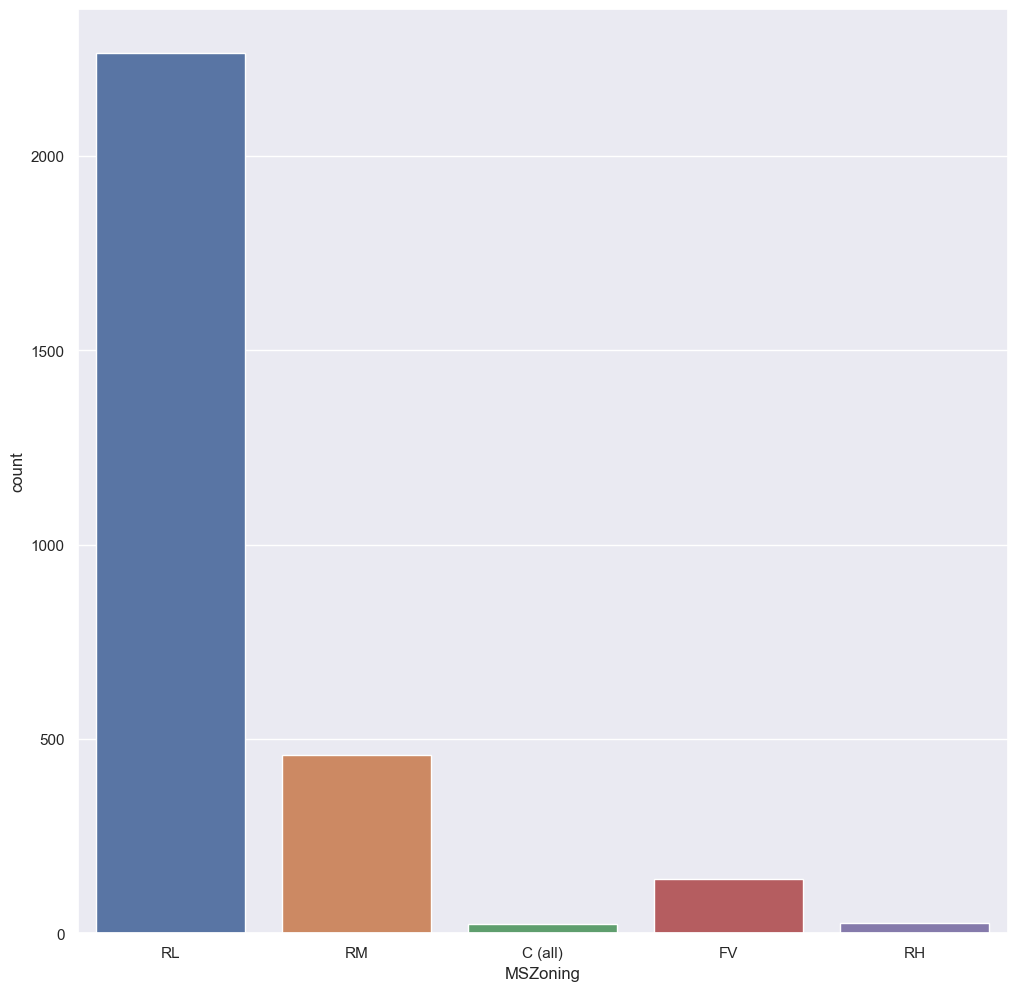




        Street  ratio
Street               
Pave      2907  99.59
Grvl        12   0.41


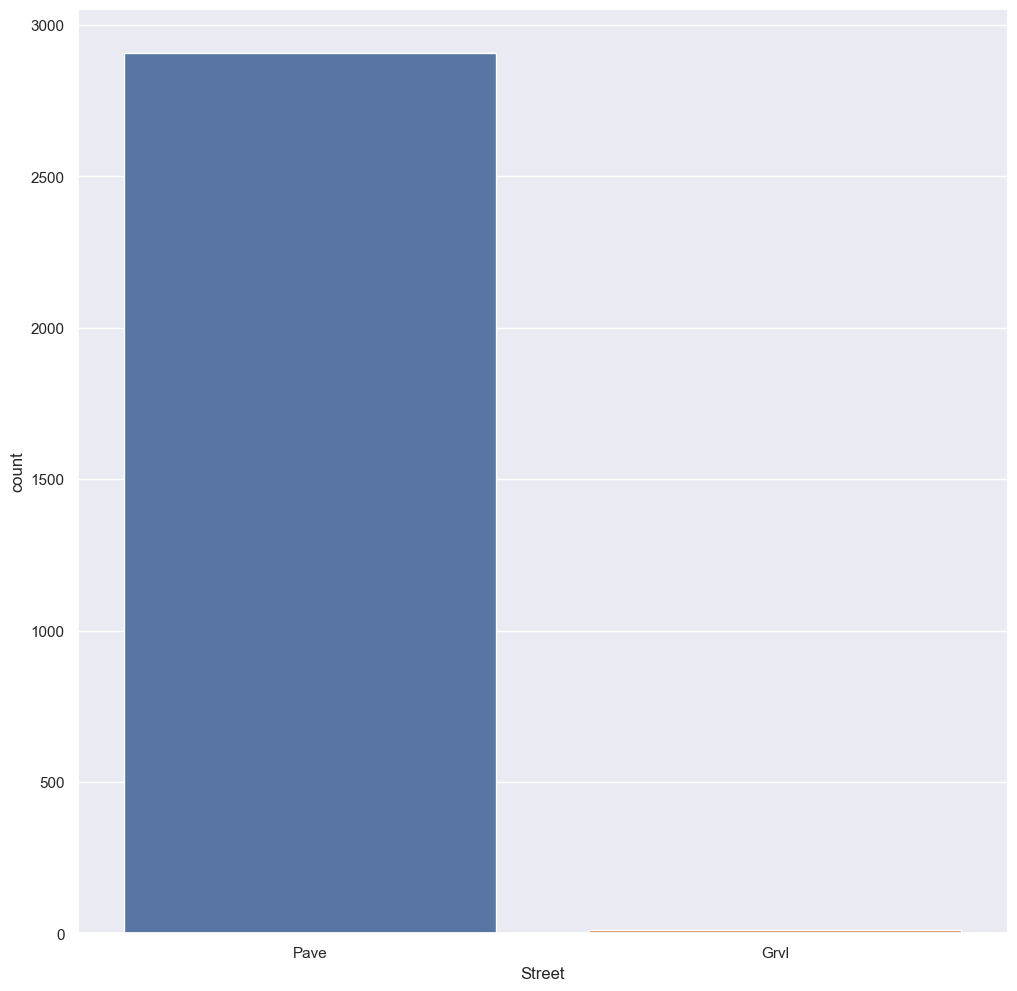




       Alley  ratio
Alley              
Grvl     120   4.11
Pave      78   2.67


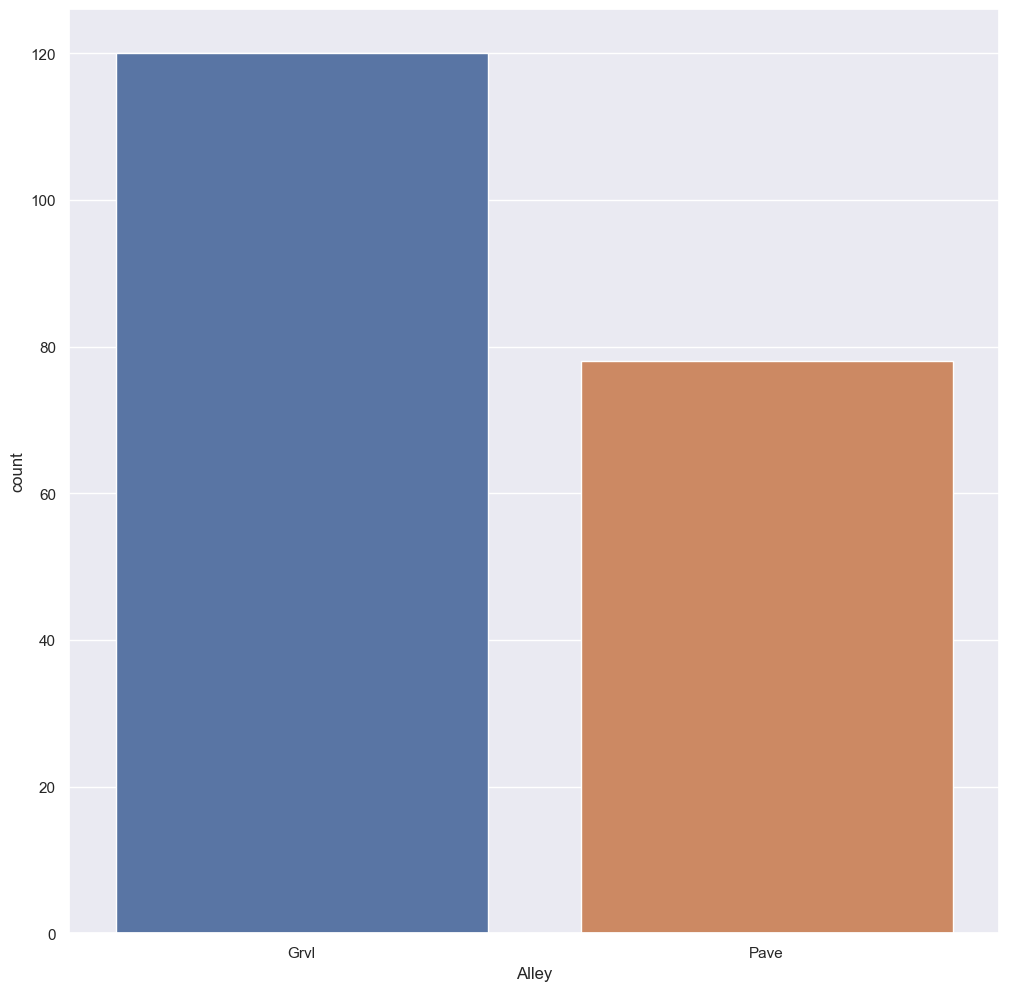




          LotShape  ratio
LotShape                 
Reg           1859  63.69
IR1            968  33.16
IR2             76   2.60
IR3             16   0.55


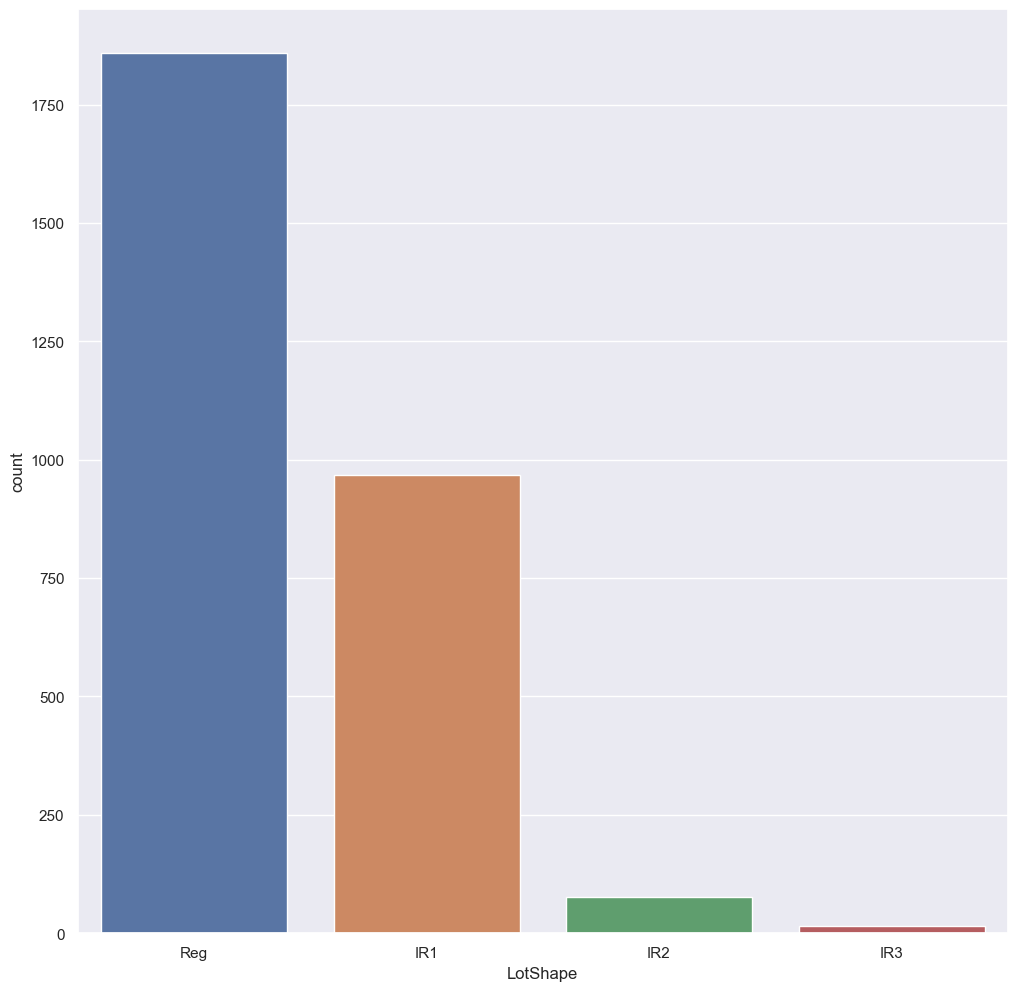




             LandContour  ratio
LandContour                    
Lvl                 2622  89.83
HLS                  120   4.11
Bnk                  117   4.01
Low                   60   2.06


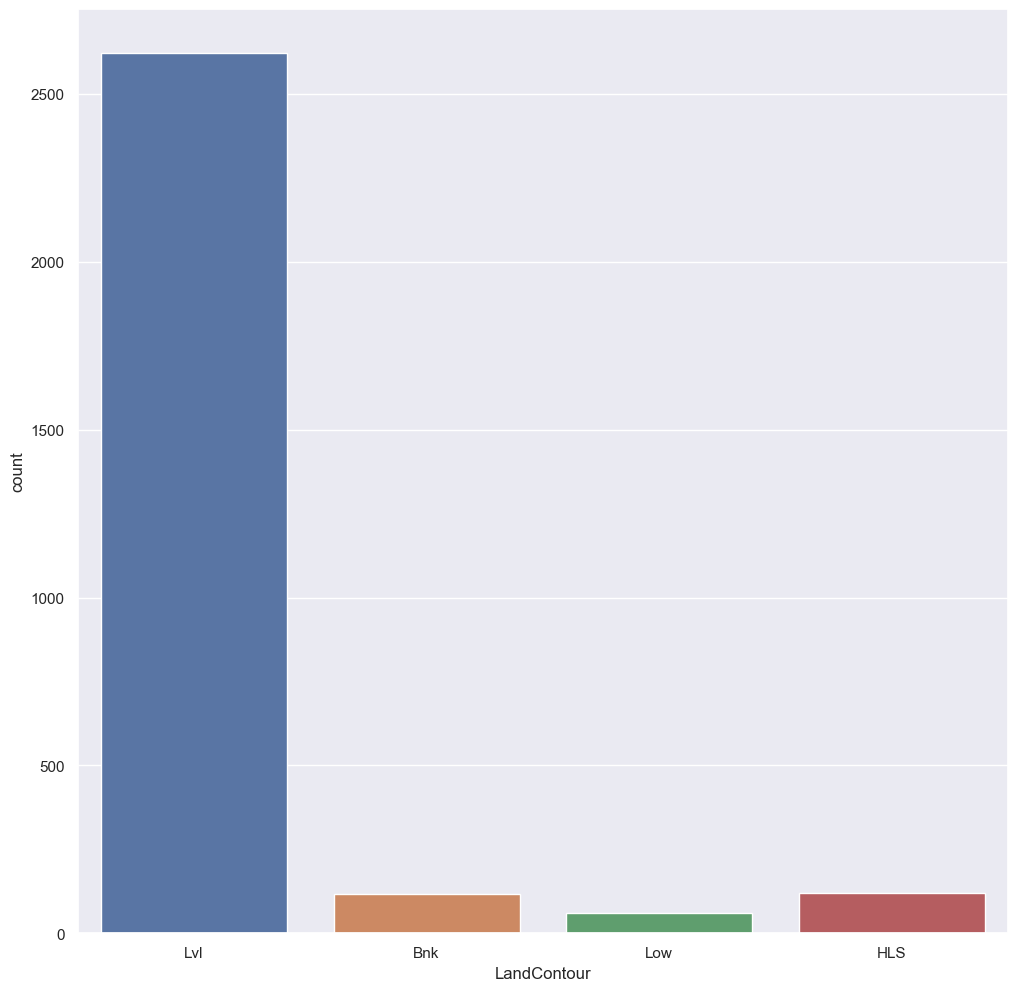




           Utilities  ratio
Utilities                  
AllPub          2916  99.90
NoSeWa             1   0.03


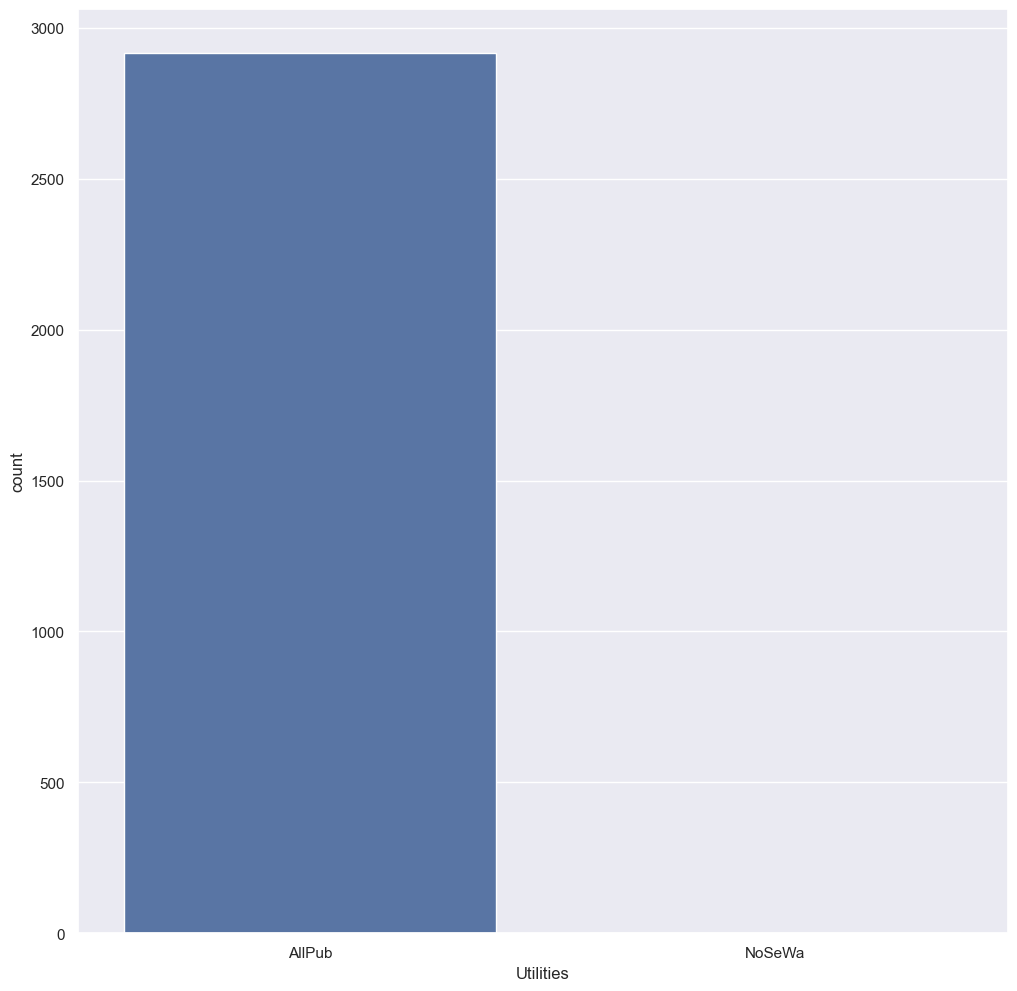




           LotConfig  ratio
LotConfig                  
Inside          2133  73.07
Corner           511  17.51
CulDSac          176   6.03
FR2               85   2.91
FR3               14   0.48


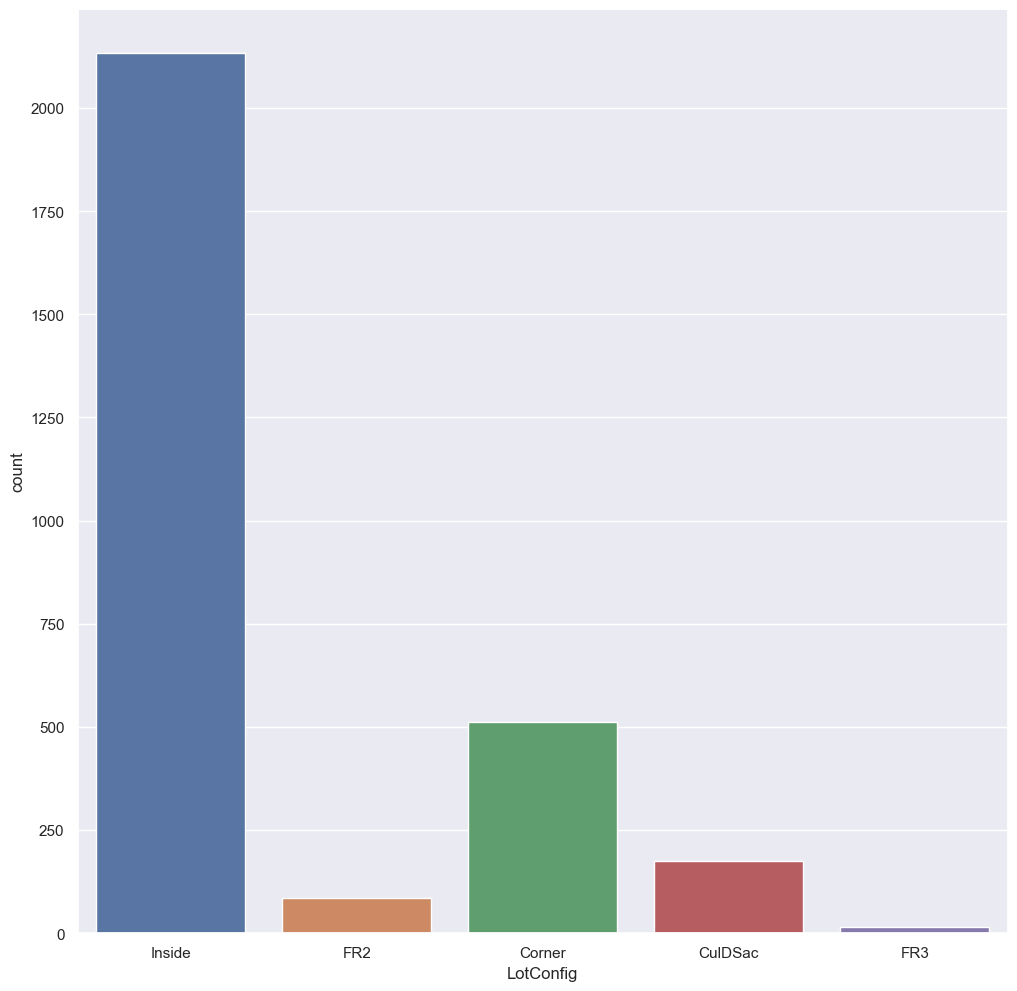




           LandSlope  ratio
LandSlope                  
Gtl             2778  95.17
Mod              125   4.28
Sev               16   0.55


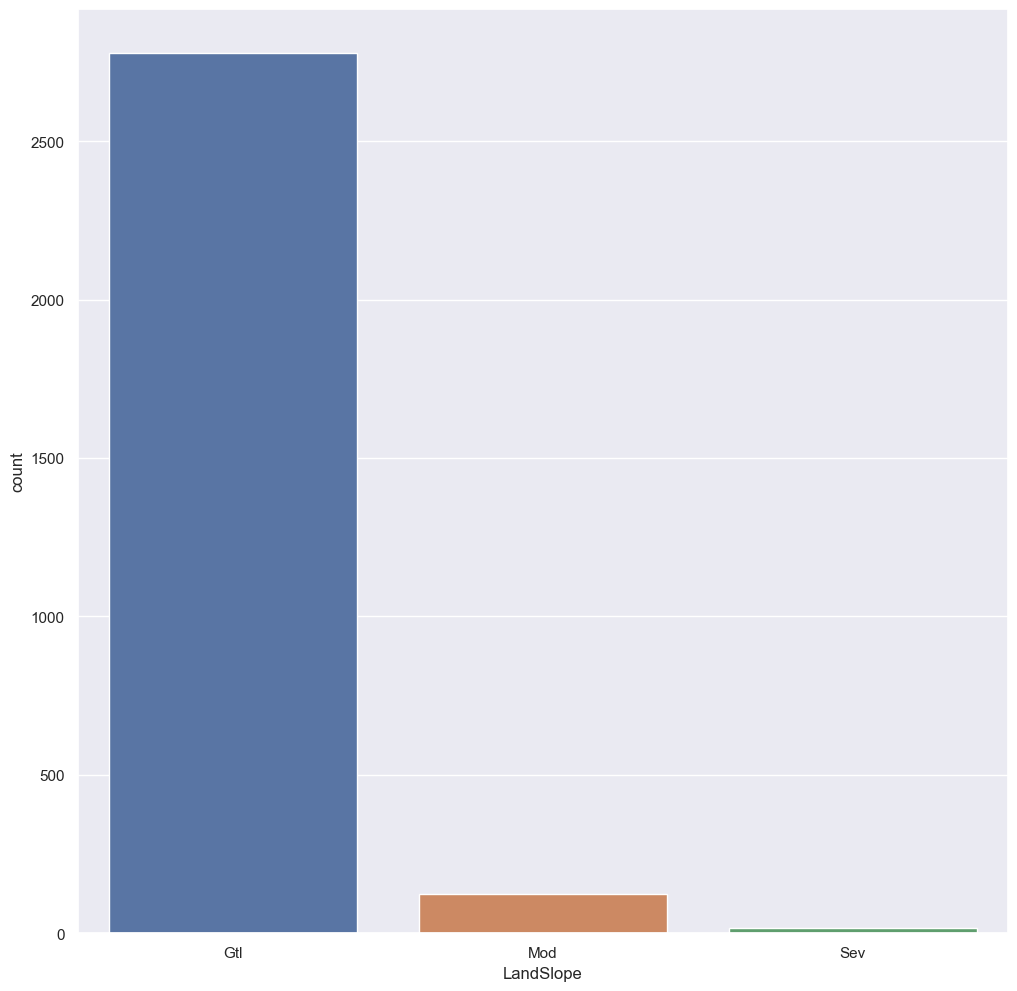




            Condition1  ratio
Condition1                   
Norm              2511  86.02
Feedr              164   5.62
Artery              92   3.15
RRAn                50   1.71
PosN                39   1.34
RRAe                28   0.96
PosA                20   0.69
RRNn                 9   0.31
RRNe                 6   0.21


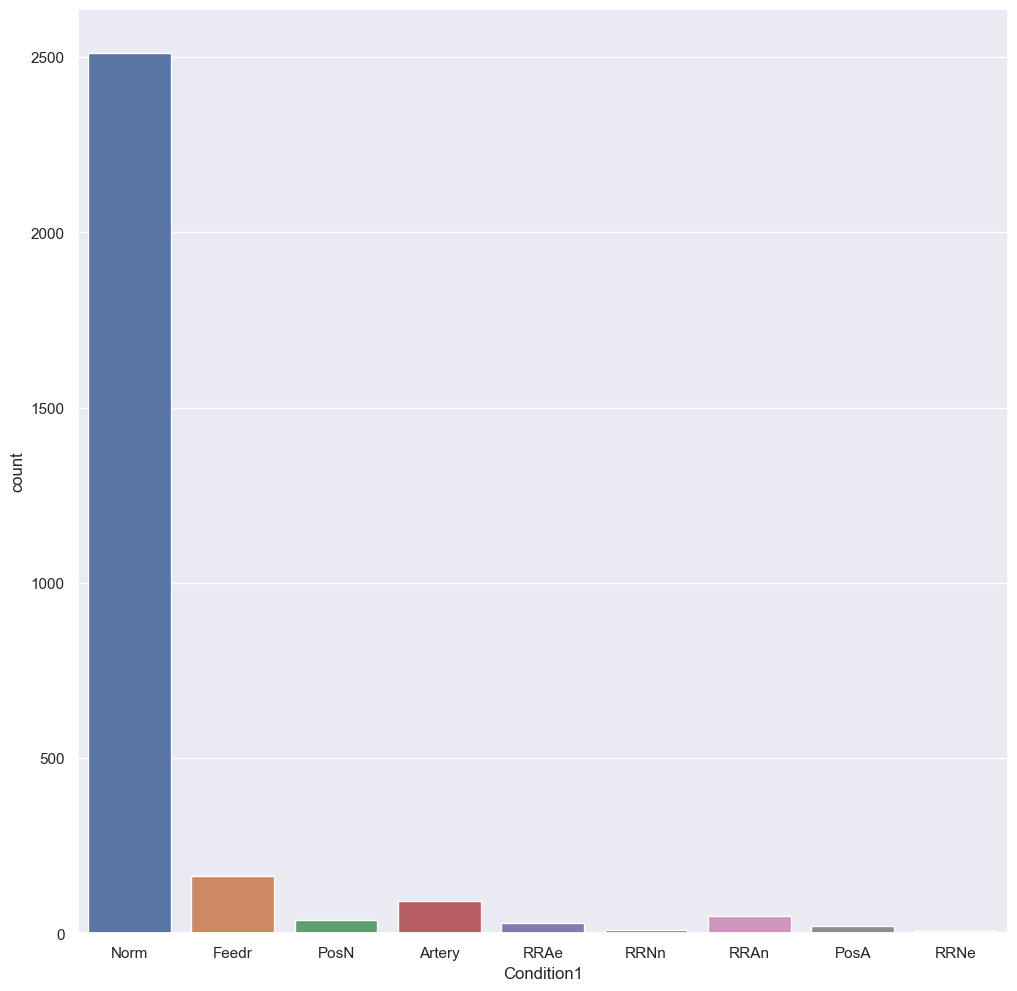




            Condition2  ratio
Condition2                   
Norm              2889  98.97
Feedr               13   0.45
Artery               5   0.17
PosN                 4   0.14
PosA                 4   0.14
RRNn                 2   0.07
RRAn                 1   0.03
RRAe                 1   0.03


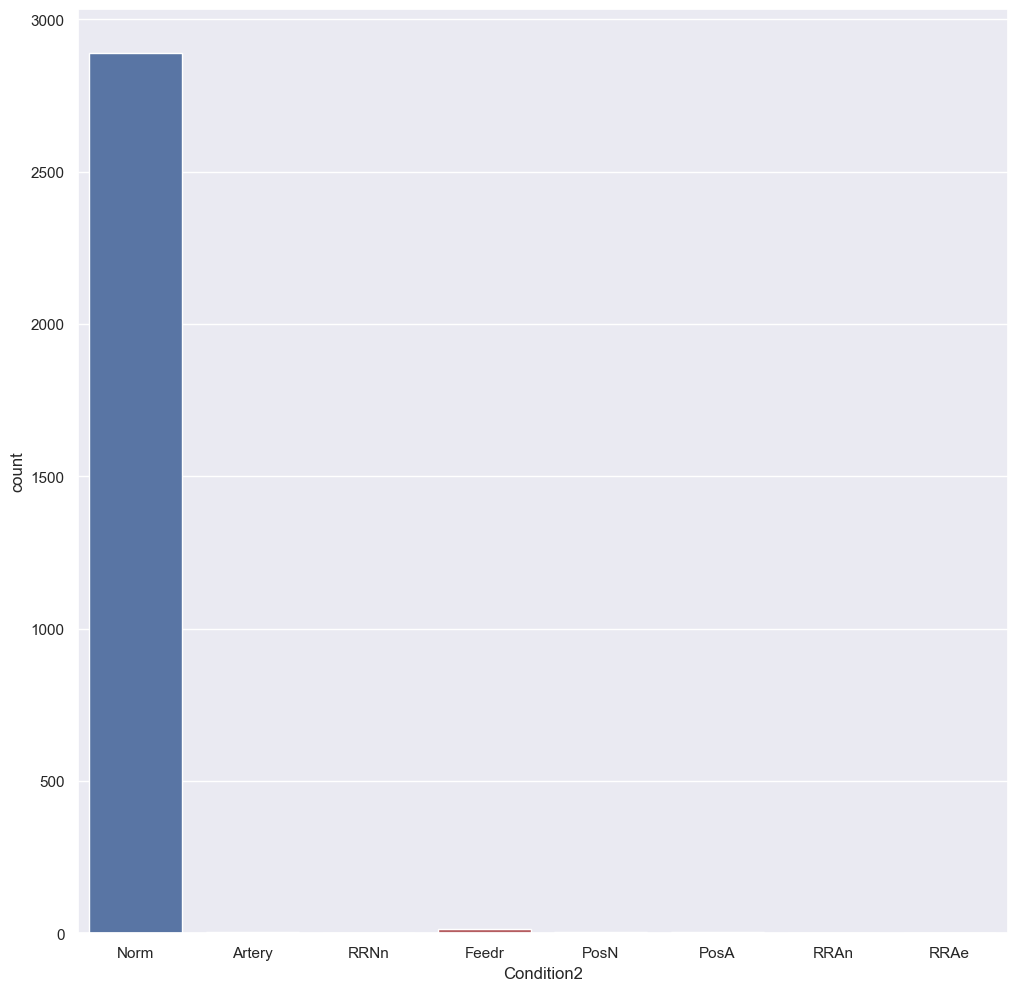




          BldgType  ratio
BldgType                 
1Fam          2425  83.08
TwnhsE         227   7.78
Duplex         109   3.73
Twnhs           96   3.29
2fmCon          62   2.12


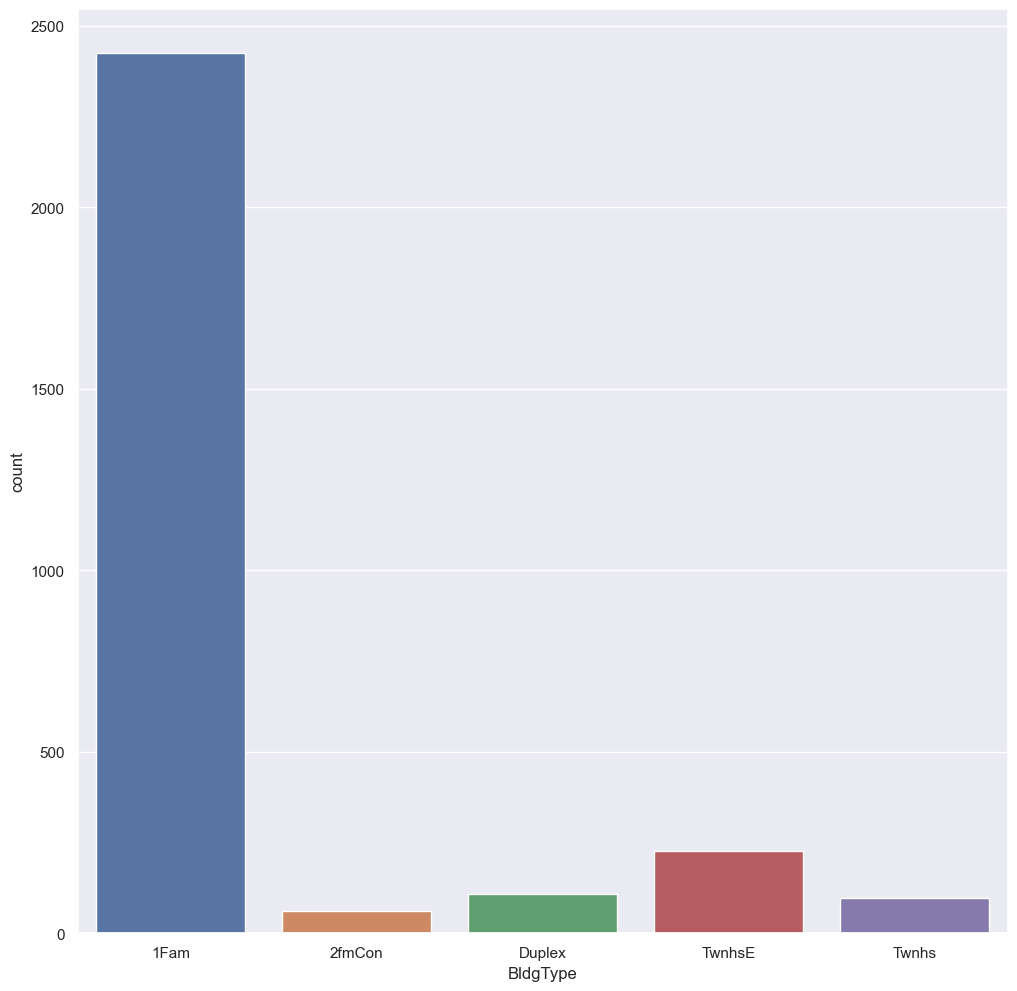




            HouseStyle  ratio
HouseStyle                   
1Story            1471  50.39
2Story             872  29.87
1.5Fin             314  10.76
SLvl               128   4.39
SFoyer              83   2.84
2.5Unf              24   0.82
1.5Unf              19   0.65
2.5Fin               8   0.27


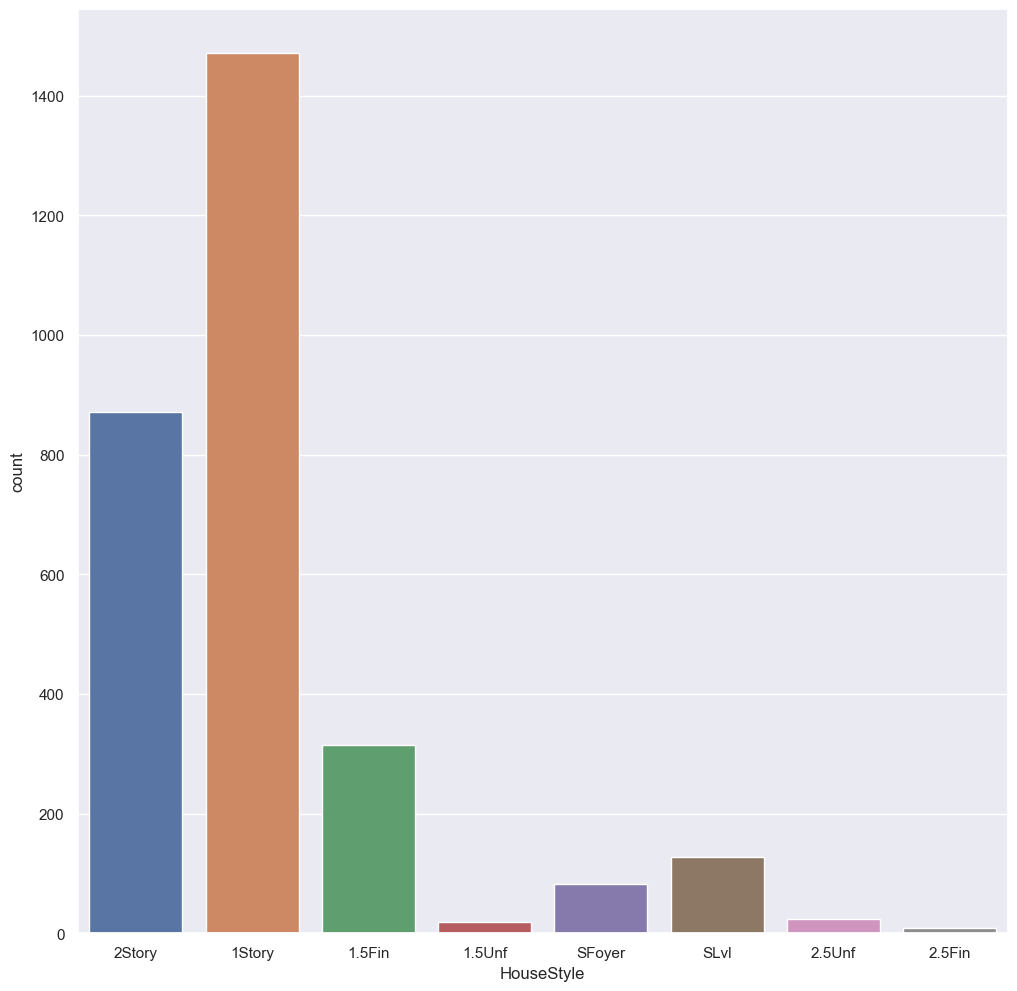




           RoofStyle  ratio
RoofStyle                  
Gable           2310  79.14
Hip              551  18.88
Gambrel           22   0.75
Flat              20   0.69
Mansard           11   0.38
Shed               5   0.17


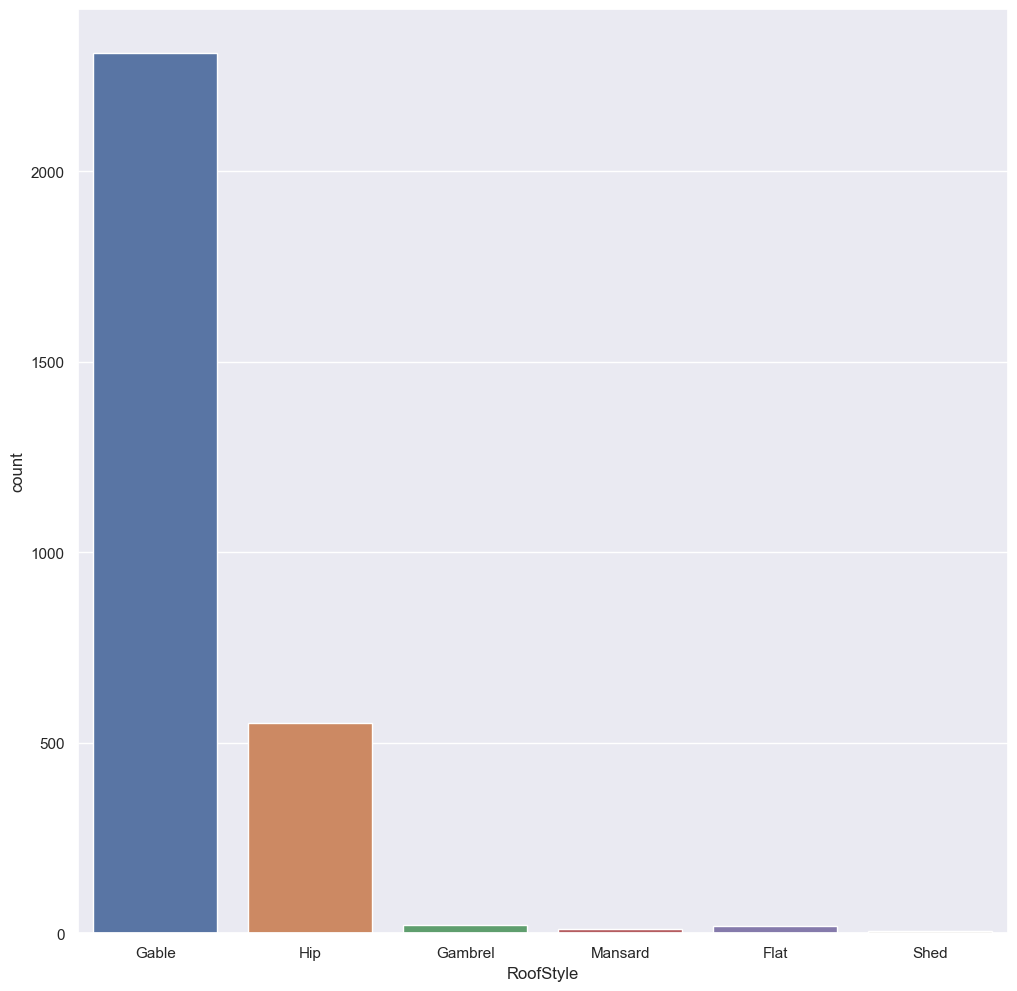




          RoofMatl  ratio
RoofMatl                 
CompShg       2876  98.53
Tar&Grv         23   0.79
WdShake          9   0.31
WdShngl          7   0.24
Metal            1   0.03
Membran          1   0.03
Roll             1   0.03
ClyTile          1   0.03


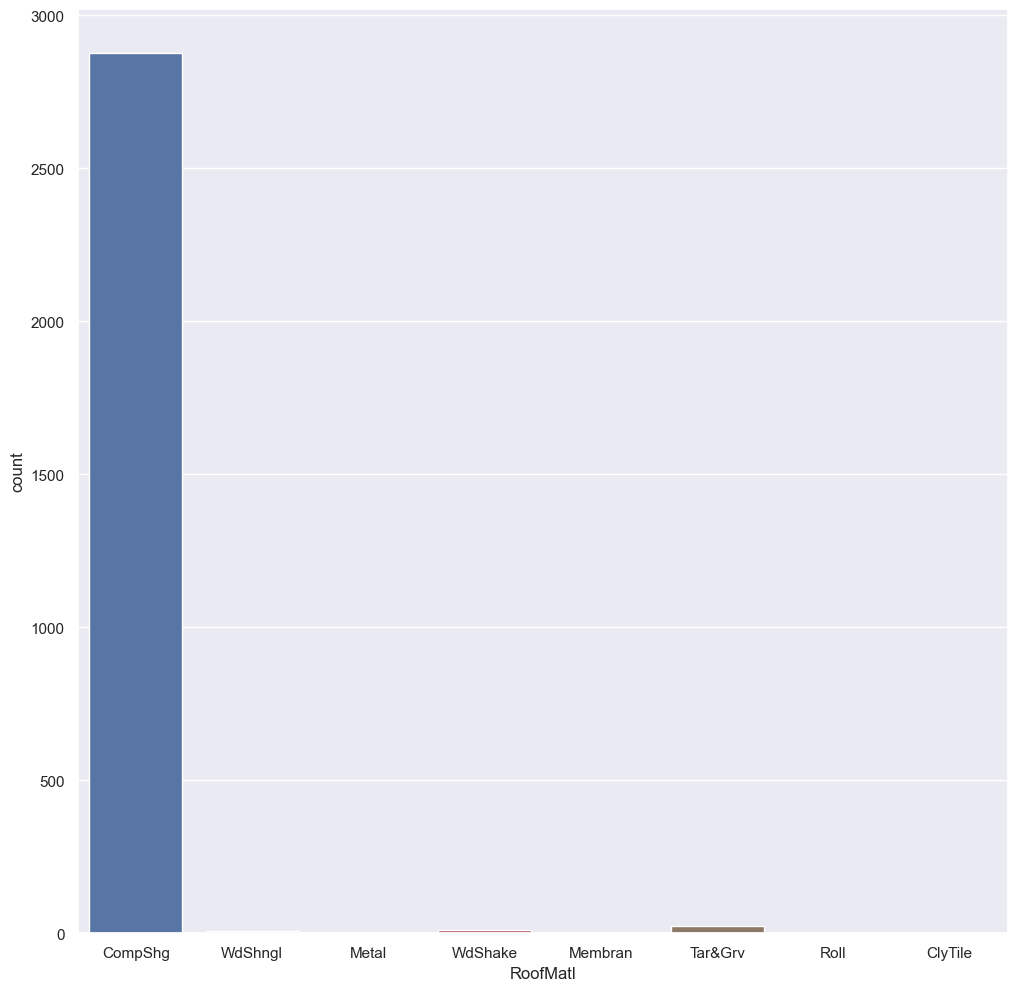




             Exterior1st  ratio
Exterior1st                    
VinylSd             1025  35.11
MetalSd              450  15.42
HdBoard              442  15.14
Wd Sdng              411  14.08
Plywood              221   7.57
CemntBd              126   4.32
BrkFace               87   2.98
WdShing               56   1.92
AsbShng               44   1.51
Stucco                43   1.47
BrkComm                6   0.21
AsphShn                2   0.07
Stone                  2   0.07
CBlock                 2   0.07
ImStucc                1   0.03


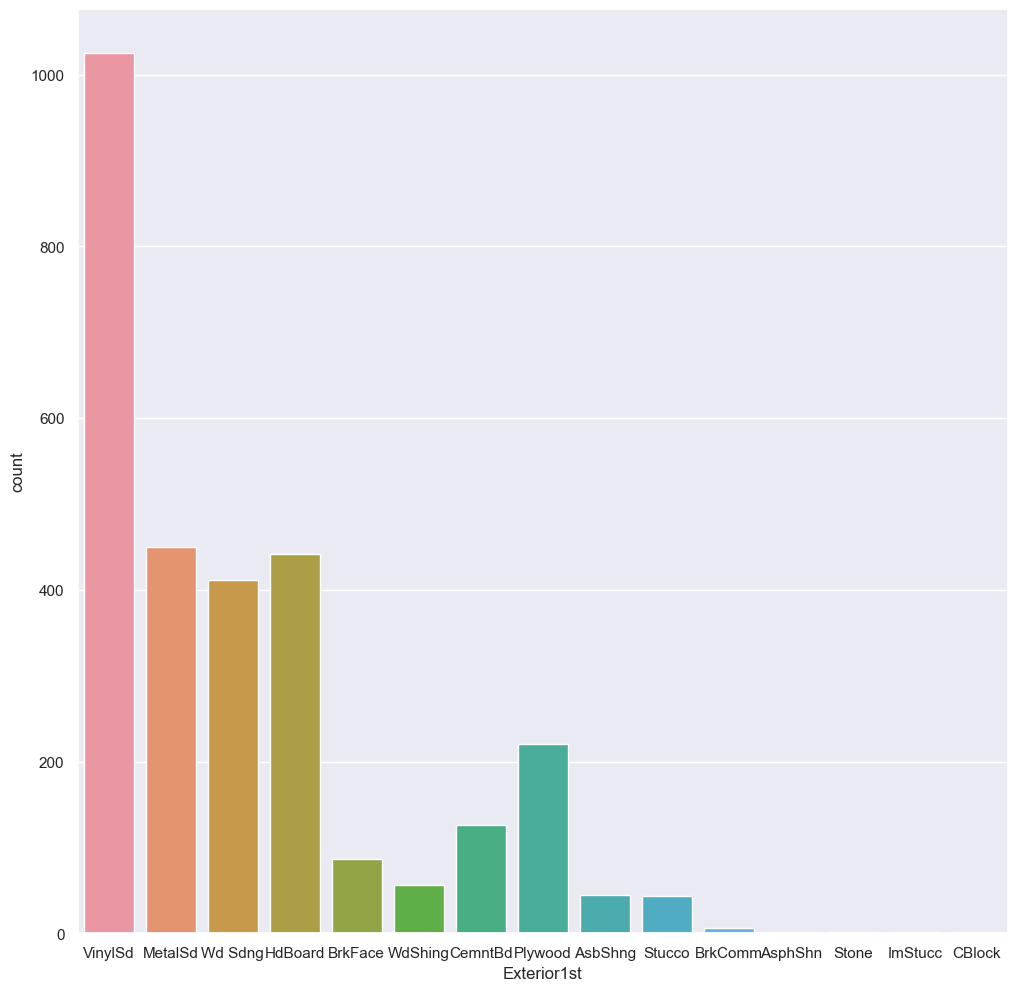




             Exterior2nd  ratio
Exterior2nd                    
VinylSd             1014  34.74
MetalSd              447  15.31
HdBoard              406  13.91
Wd Sdng              391  13.39
Plywood              270   9.25
CmentBd              126   4.32
Wd Shng               81   2.77
BrkFace               47   1.61
Stucco                47   1.61
AsbShng               38   1.30
Brk Cmn               22   0.75
ImStucc               15   0.51
Stone                  6   0.21
AsphShn                4   0.14
CBlock                 3   0.10
Other                  1   0.03


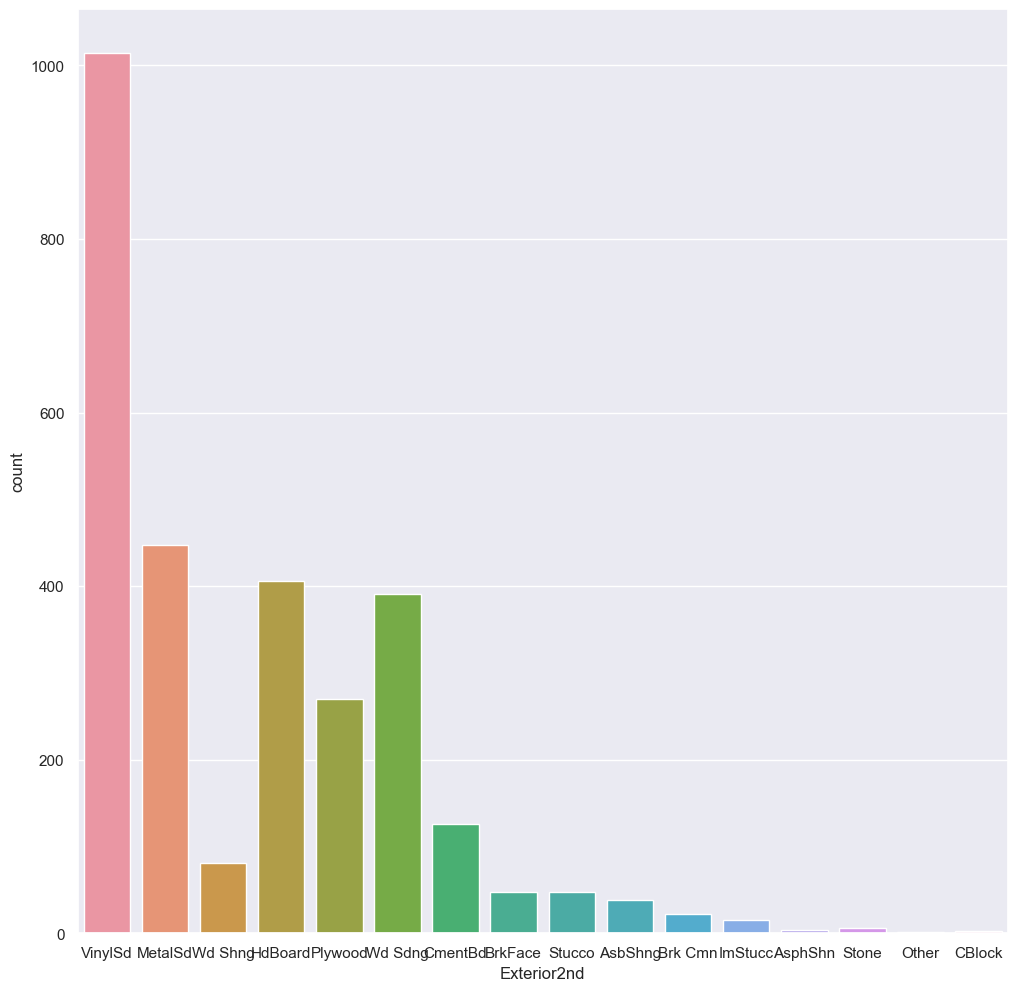




            MasVnrType  ratio
MasVnrType                   
BrkFace            879  30.11
Stone              249   8.53
BrkCmn              25   0.86


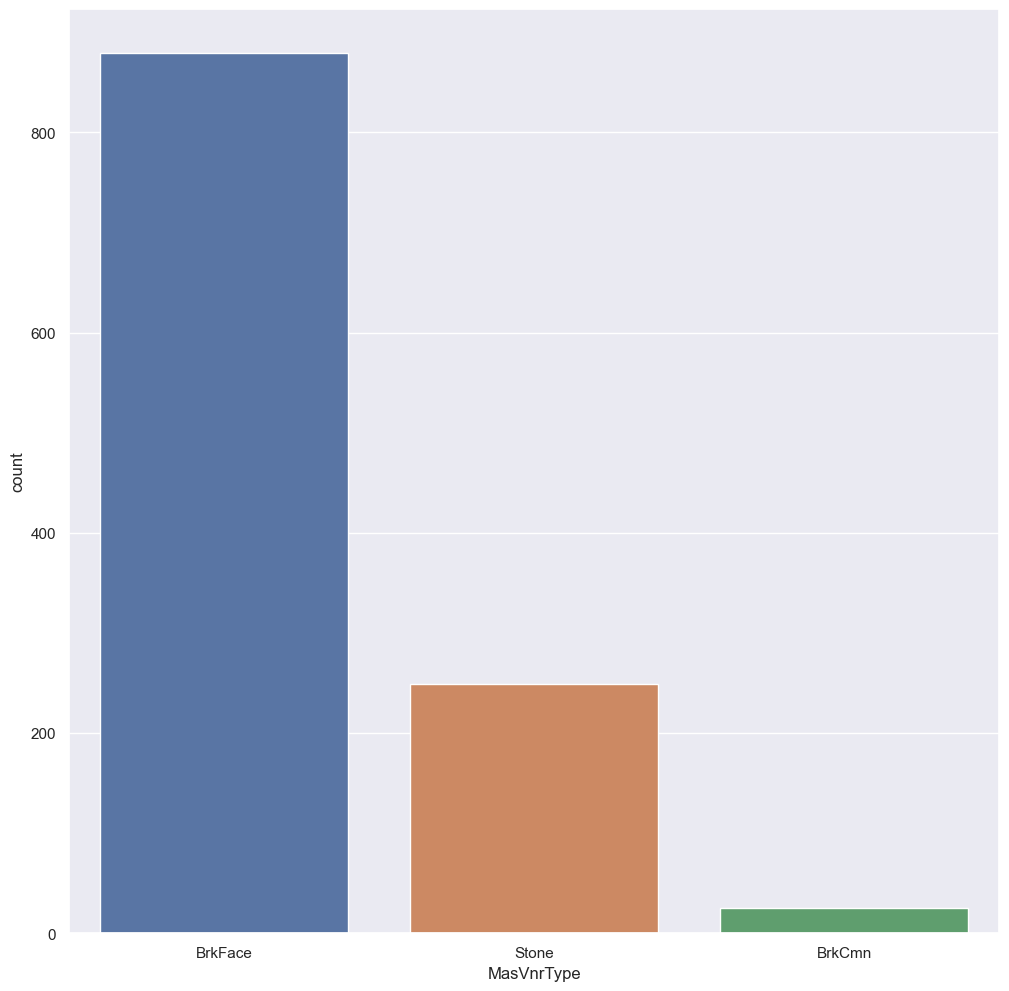




           ExterQual  ratio
ExterQual                  
TA              1798  61.60
Gd               979  33.54
Ex               107   3.67
Fa                35   1.20


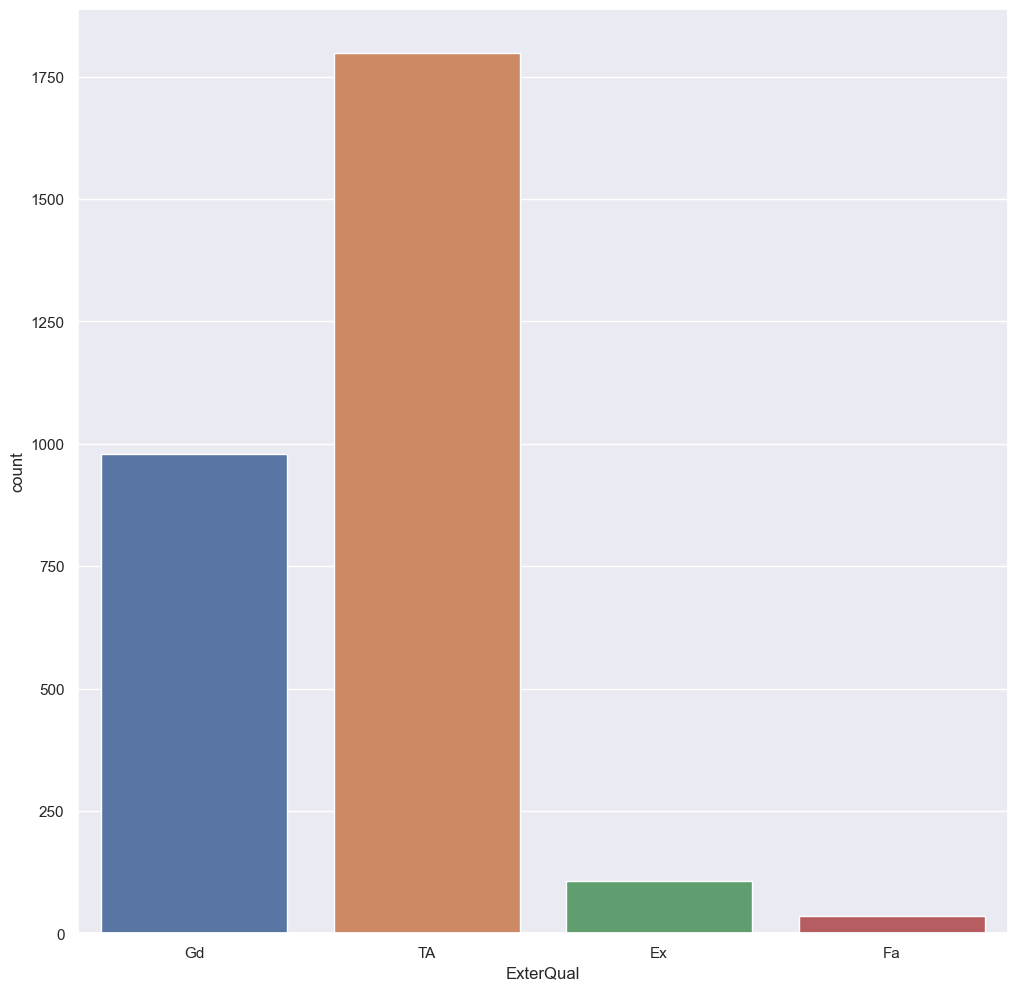




           ExterCond  ratio
ExterCond                  
TA              2538  86.95
Gd               299  10.24
Fa                67   2.30
Ex                12   0.41
Po                 3   0.10


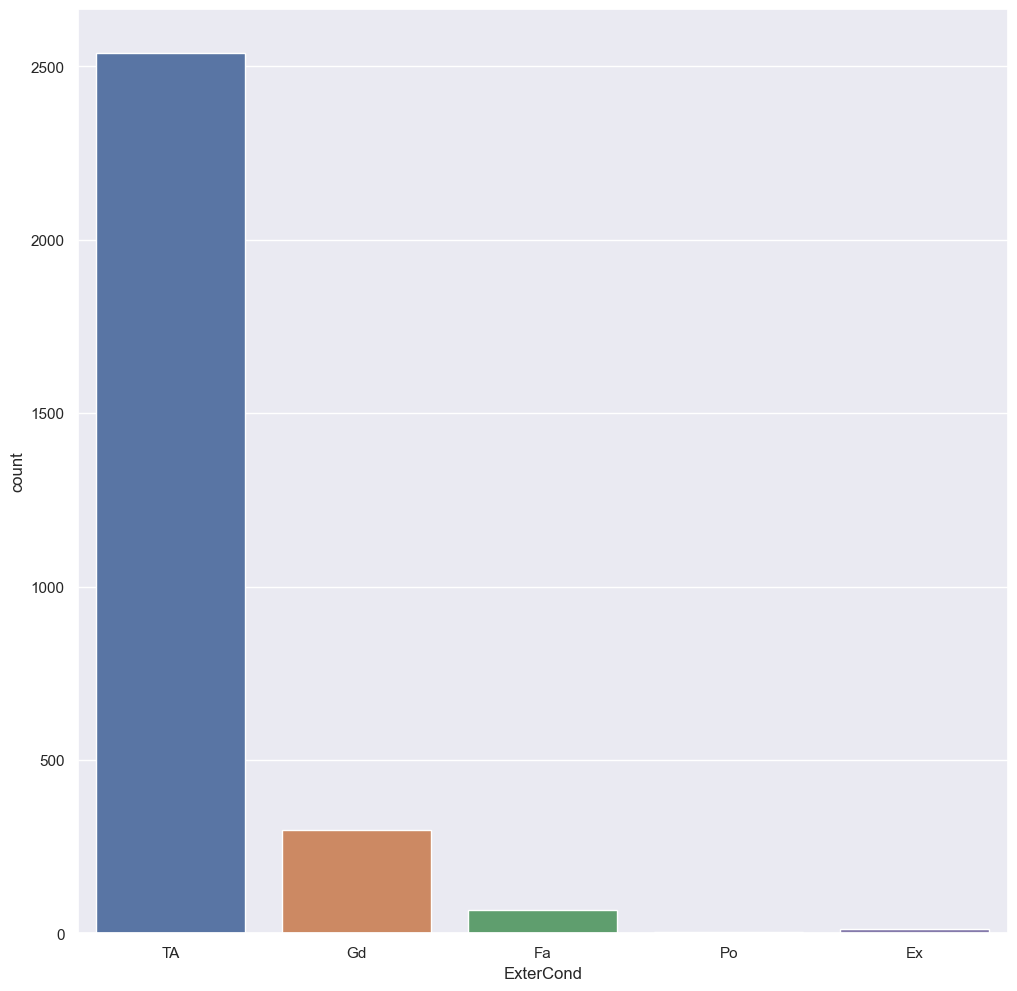




            Foundation  ratio
Foundation                   
PConc             1308  44.81
CBlock            1235  42.31
BrkTil             311  10.65
Slab                49   1.68
Stone               11   0.38
Wood                 5   0.17


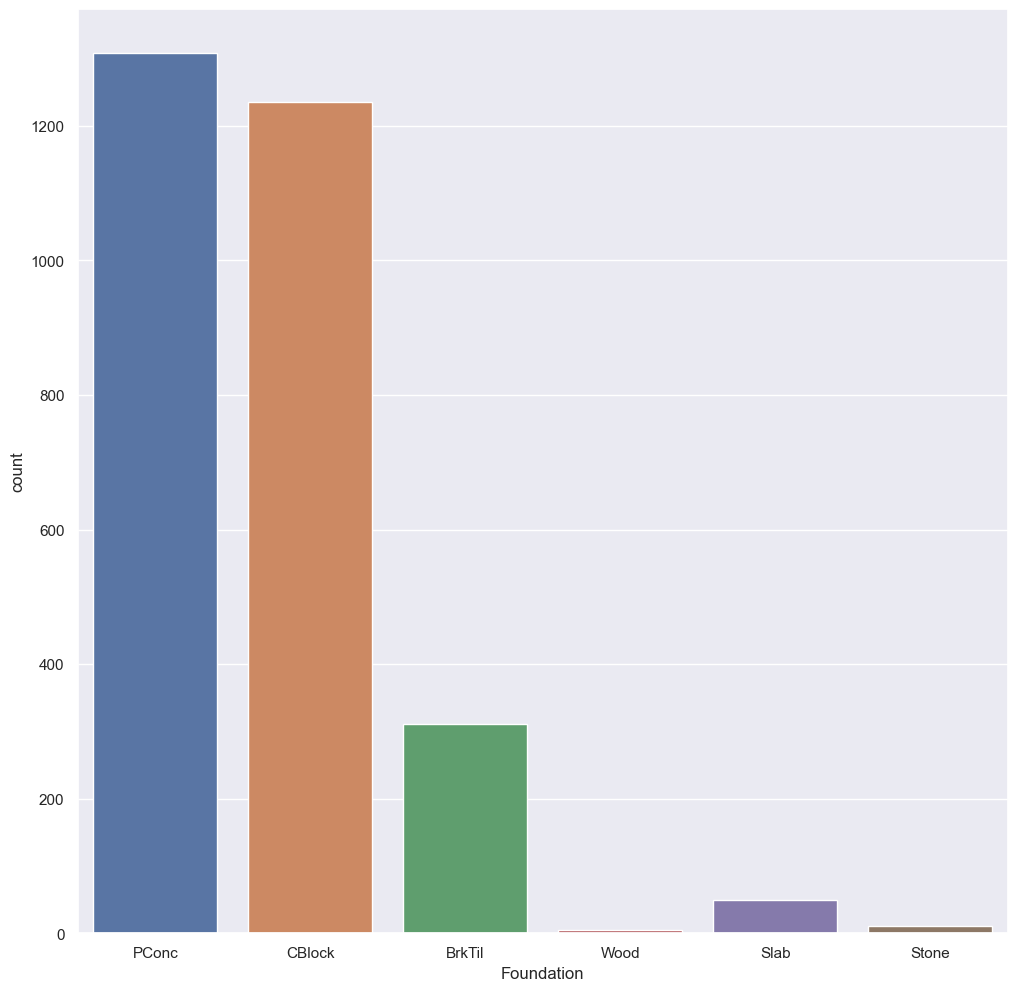




          BsmtQual  ratio
BsmtQual                 
TA            1283  43.95
Gd            1209  41.42
Ex             258   8.84
Fa              88   3.01


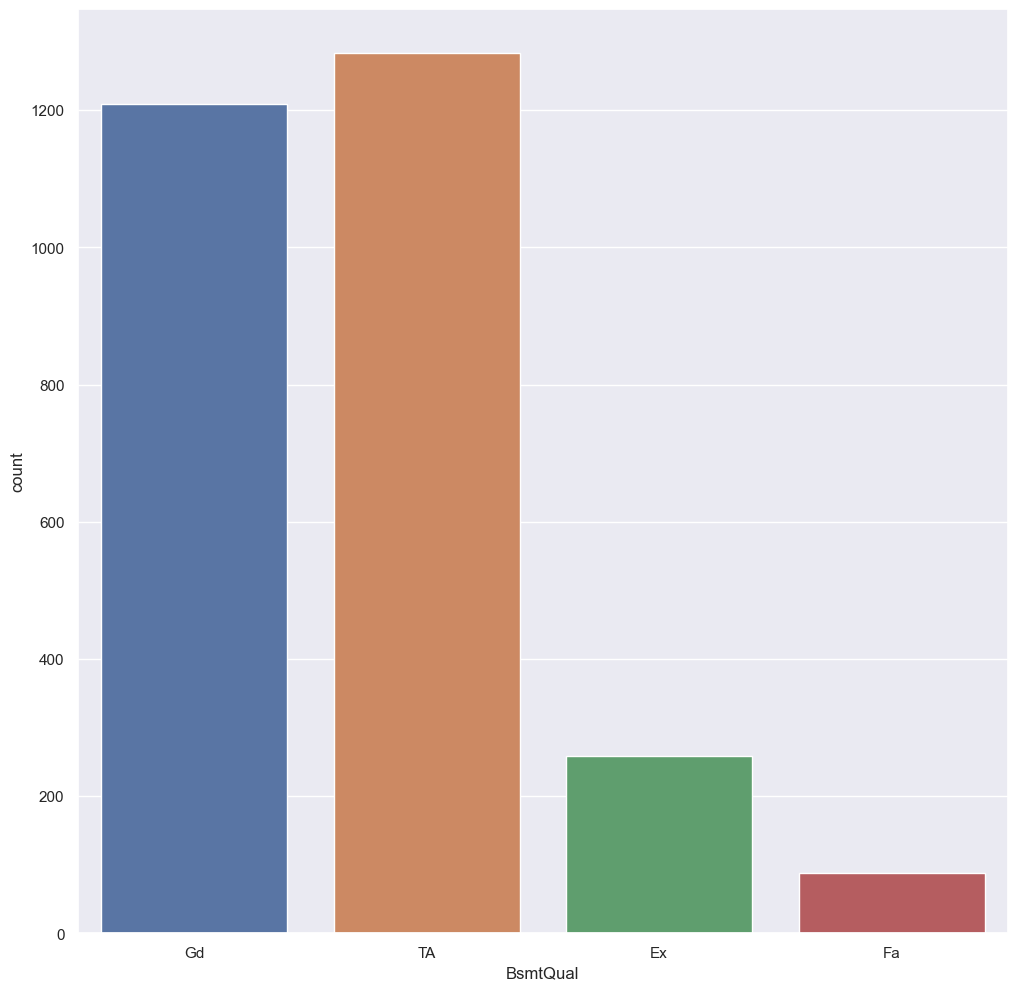




          BsmtCond  ratio
BsmtCond                 
TA            2606  89.28
Gd             122   4.18
Fa             104   3.56
Po               5   0.17


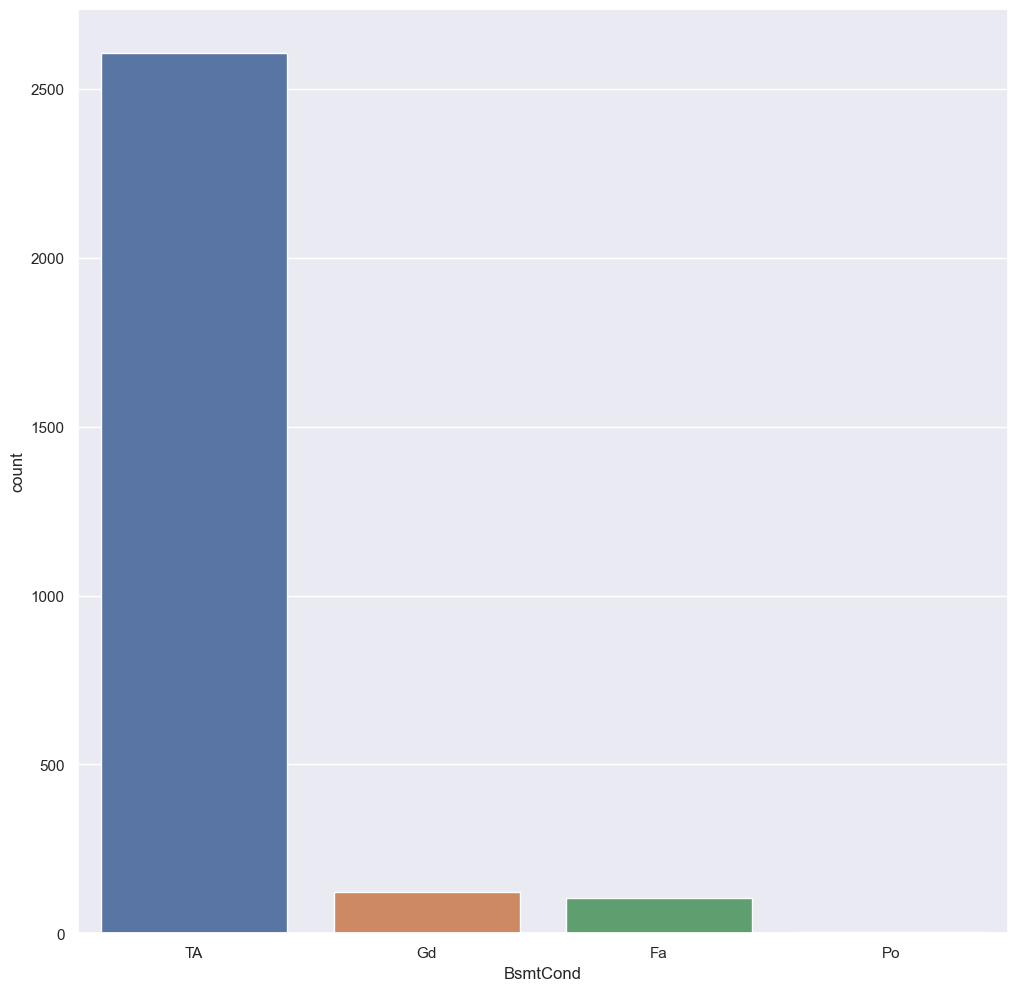




              BsmtExposure  ratio
BsmtExposure                     
No                    1904  65.23
Av                     418  14.32
Gd                     276   9.46
Mn                     239   8.19


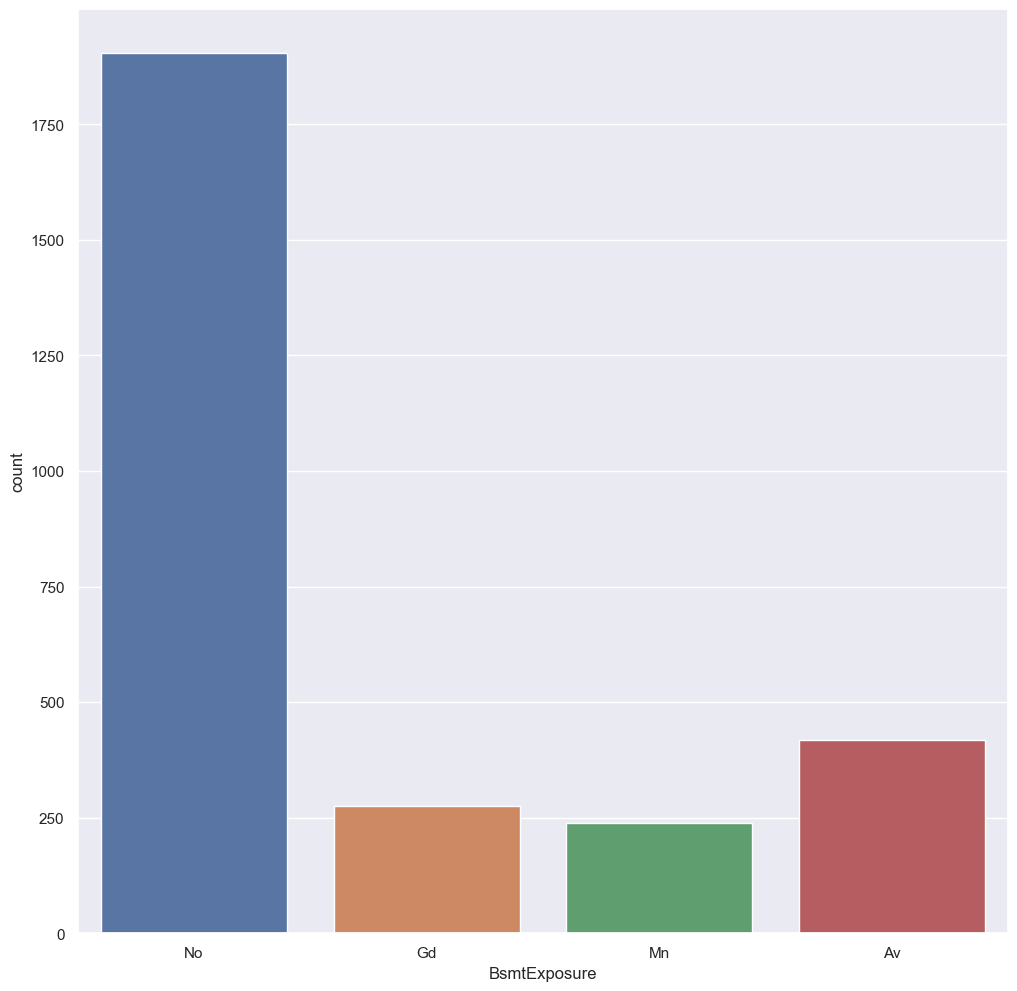




              BsmtFinType1  ratio
BsmtFinType1                     
Unf                    851  29.15
GLQ                    849  29.09
ALQ                    429  14.70
Rec                    288   9.87
BLQ                    269   9.22
LwQ                    154   5.28


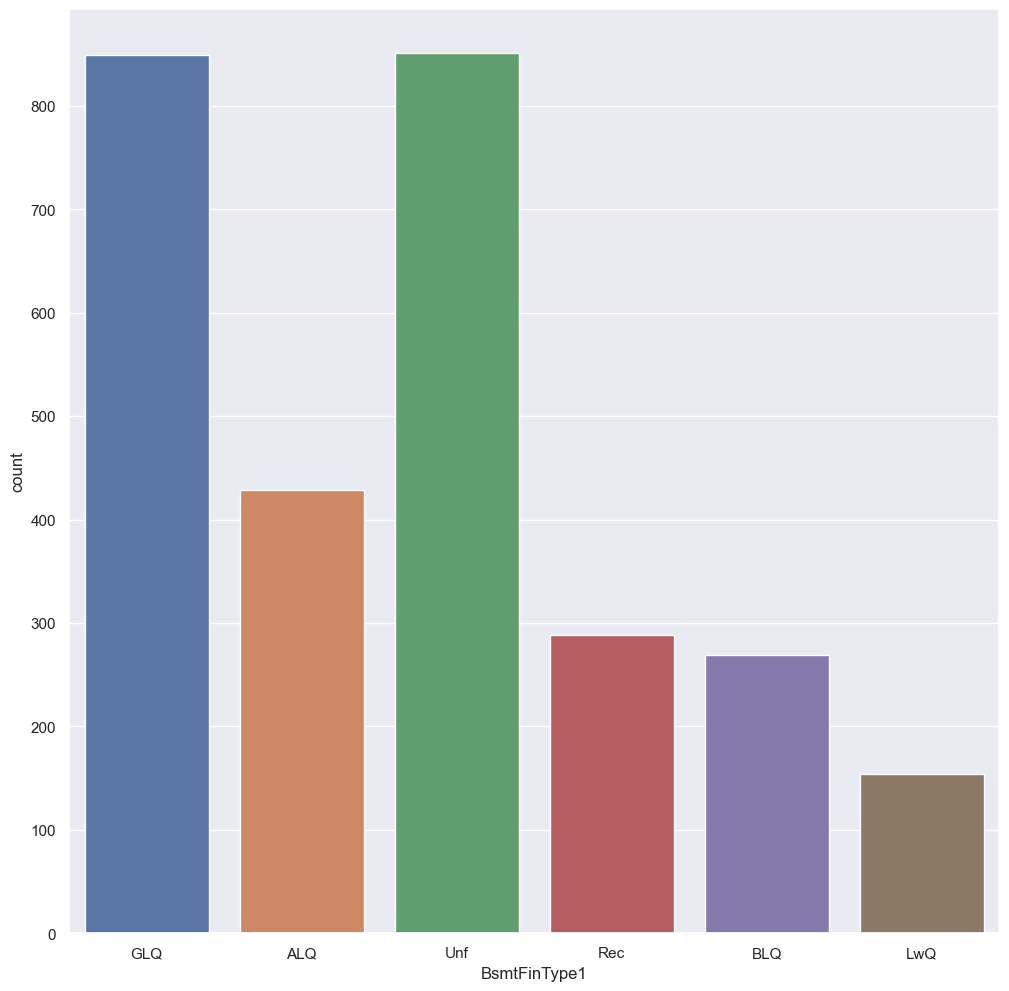




              BsmtFinType2  ratio
BsmtFinType2                     
Unf                   2493  85.41
Rec                    105   3.60
LwQ                     87   2.98
BLQ                     68   2.33
ALQ                     52   1.78
GLQ                     34   1.16


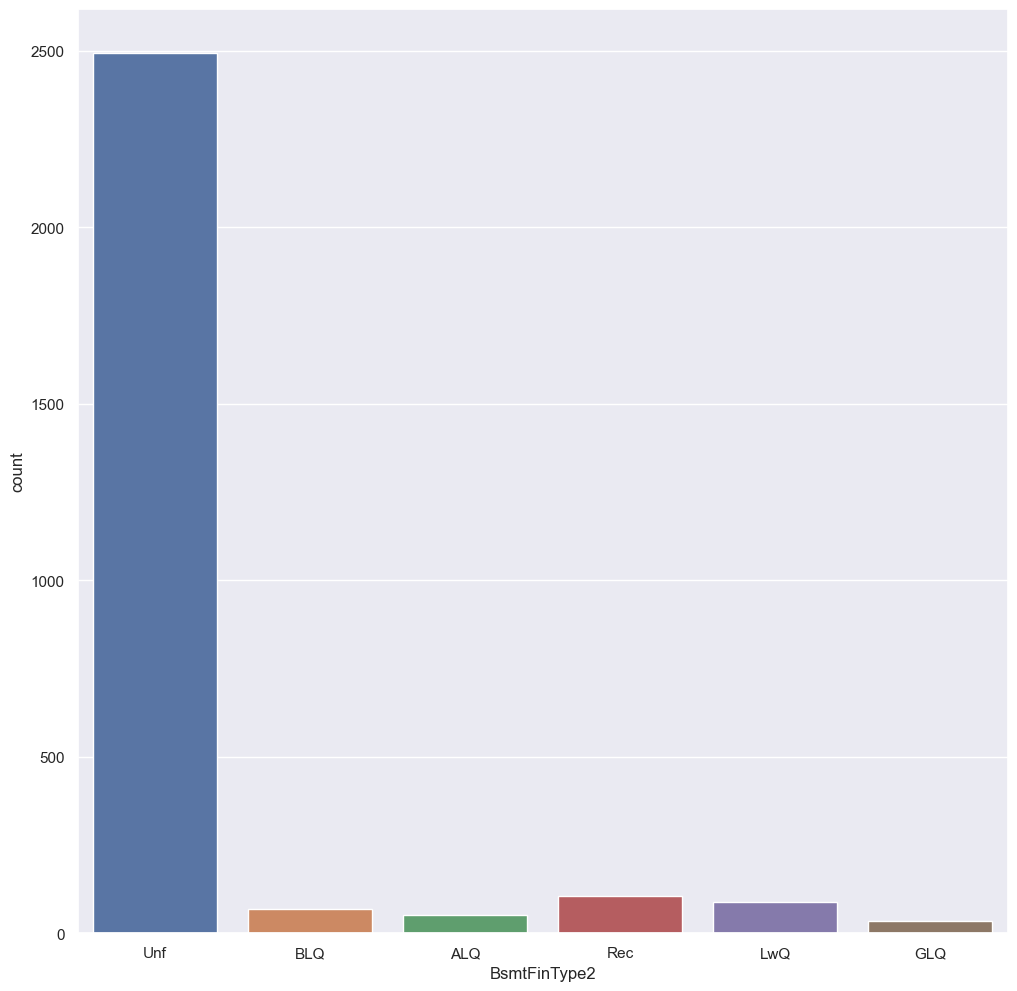




         Heating  ratio
Heating                
GasA        2874  98.46
GasW          27   0.92
Grav           9   0.31
Wall           6   0.21
OthW           2   0.07
Floor          1   0.03


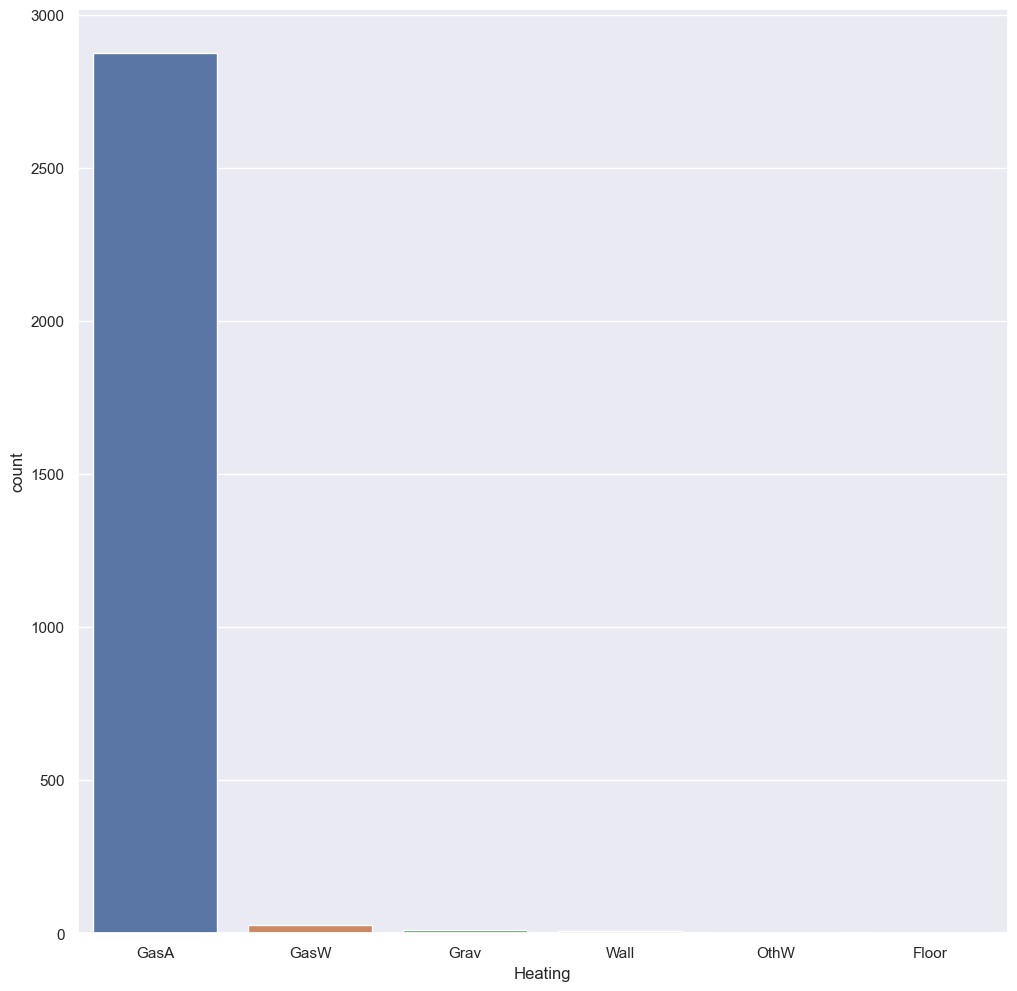




           HeatingQC  ratio
HeatingQC                  
Ex              1493  51.15
TA               857  29.36
Gd               474  16.24
Fa                92   3.15
Po                 3   0.10


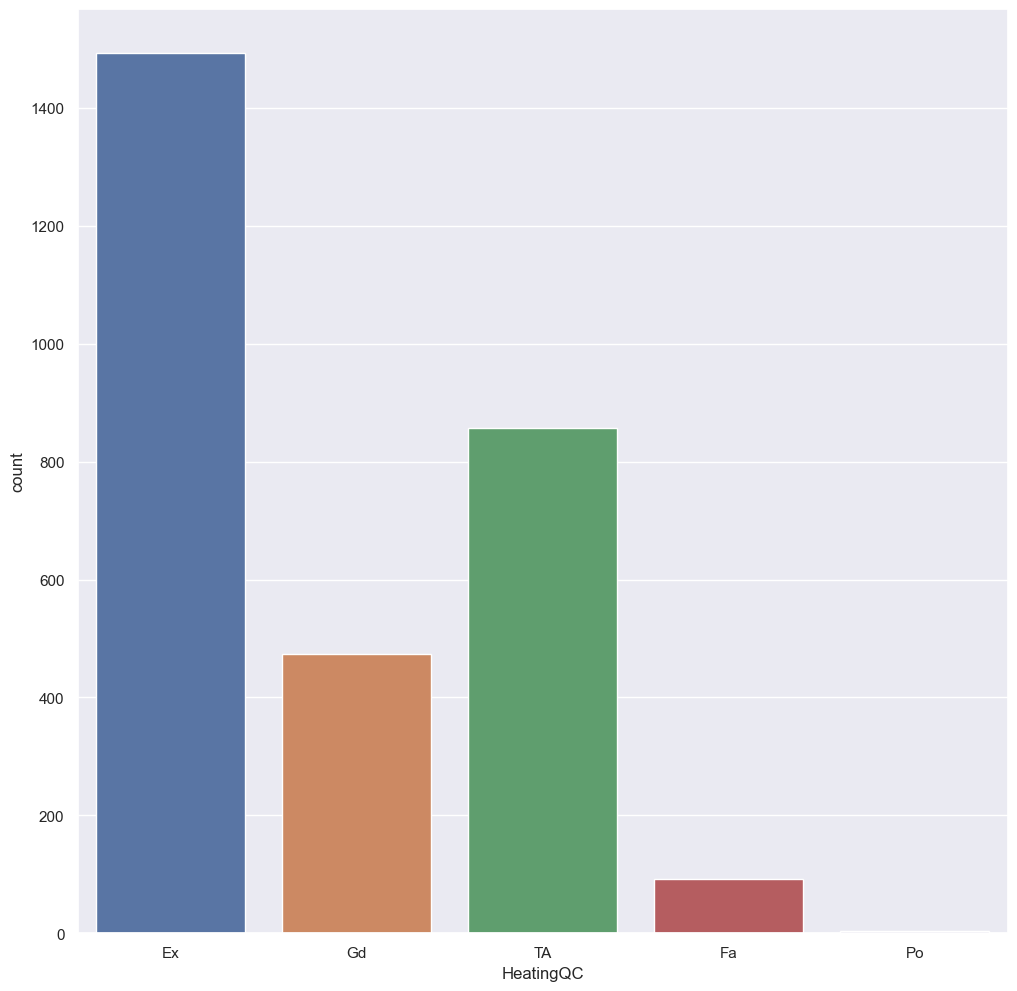




            CentralAir  ratio
CentralAir                   
Y                 2723  93.29
N                  196   6.71


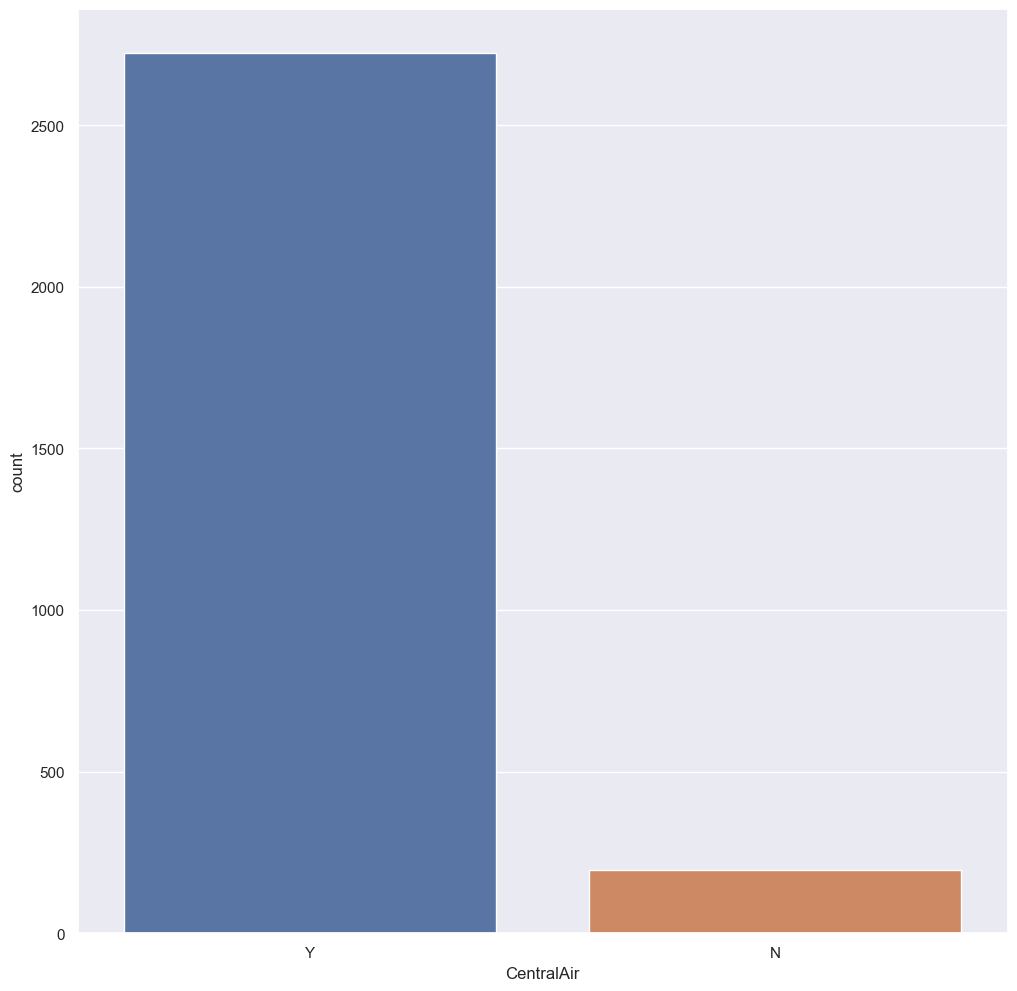




            Electrical  ratio
Electrical                   
SBrkr             2671  91.50
FuseA              188   6.44
FuseF               50   1.71
FuseP                8   0.27
Mix                  1   0.03


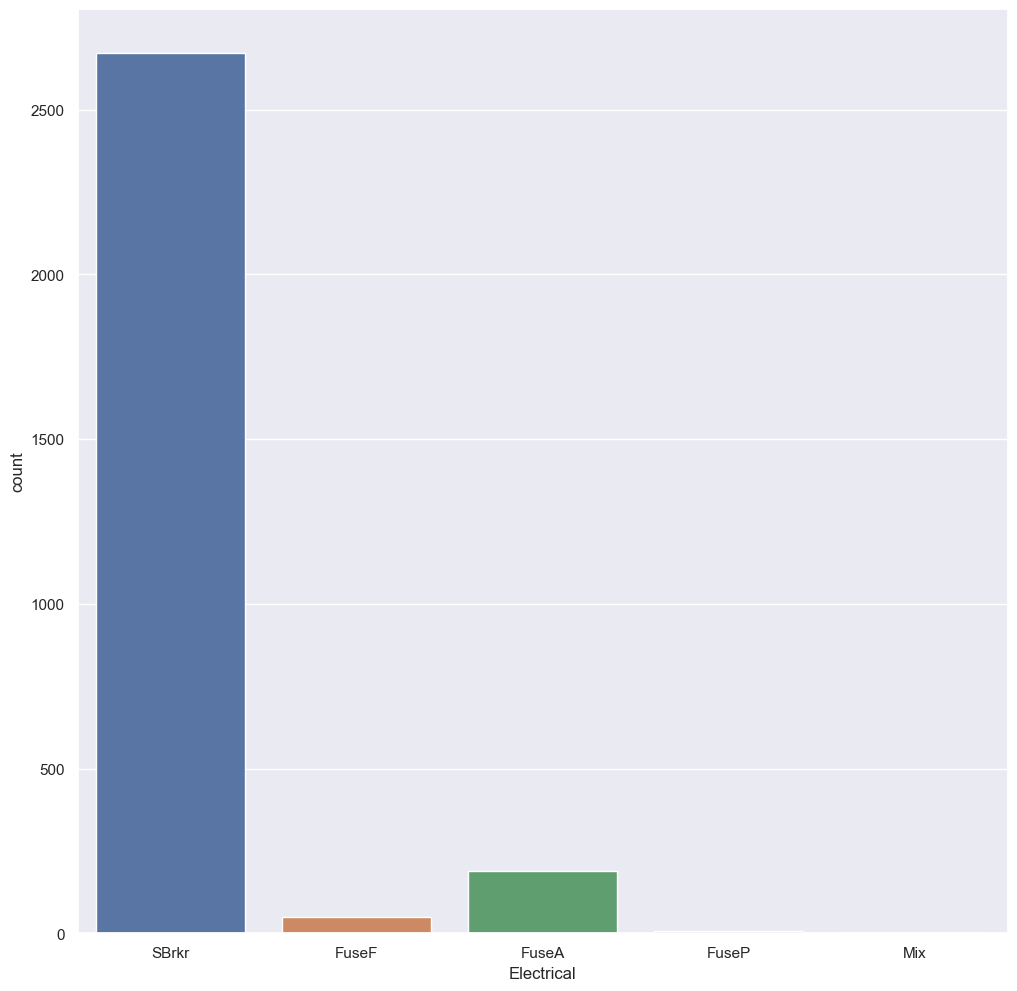




             KitchenQual  ratio
KitchenQual                    
TA                  1492  51.11
Gd                  1151  39.43
Ex                   205   7.02
Fa                    70   2.40


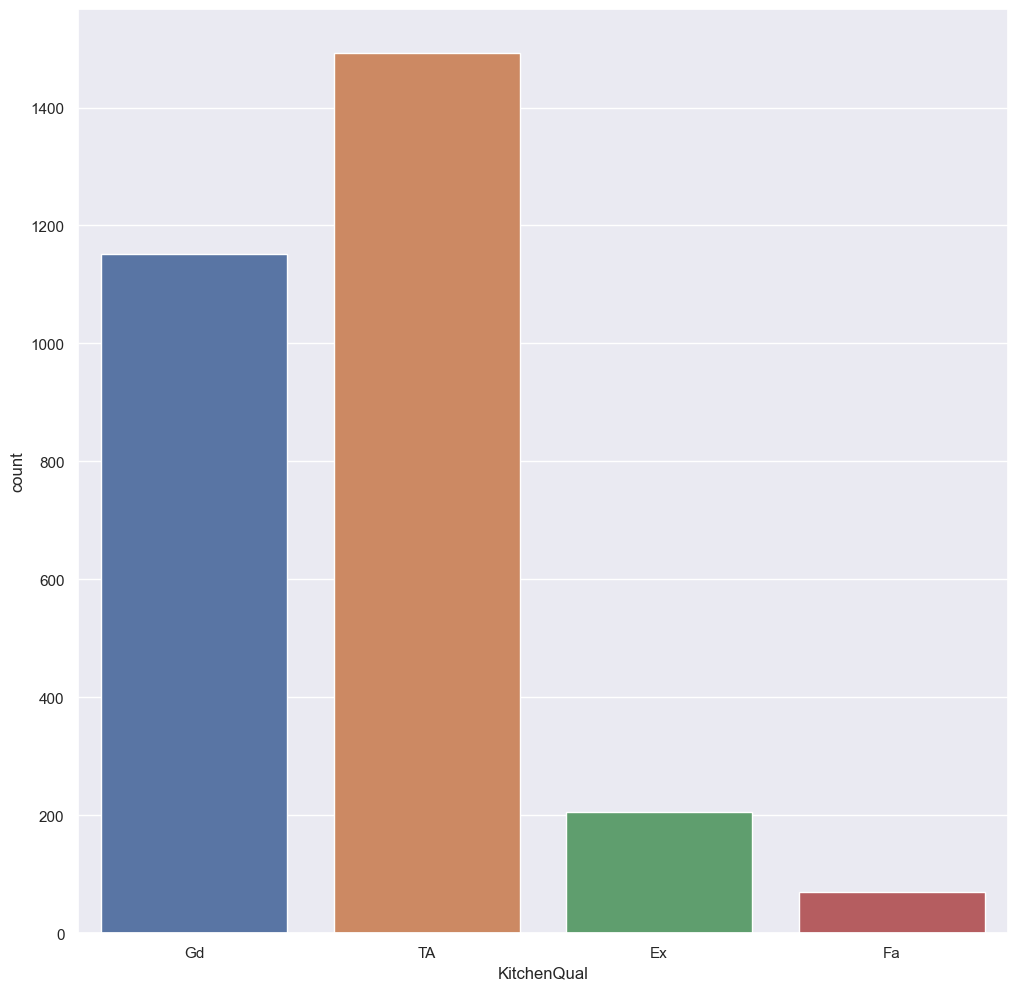




            Functional  ratio
Functional                   
Typ               2717  93.08
Min2                70   2.40
Min1                65   2.23
Mod                 35   1.20
Maj1                19   0.65
Maj2                 9   0.31
Sev                  2   0.07


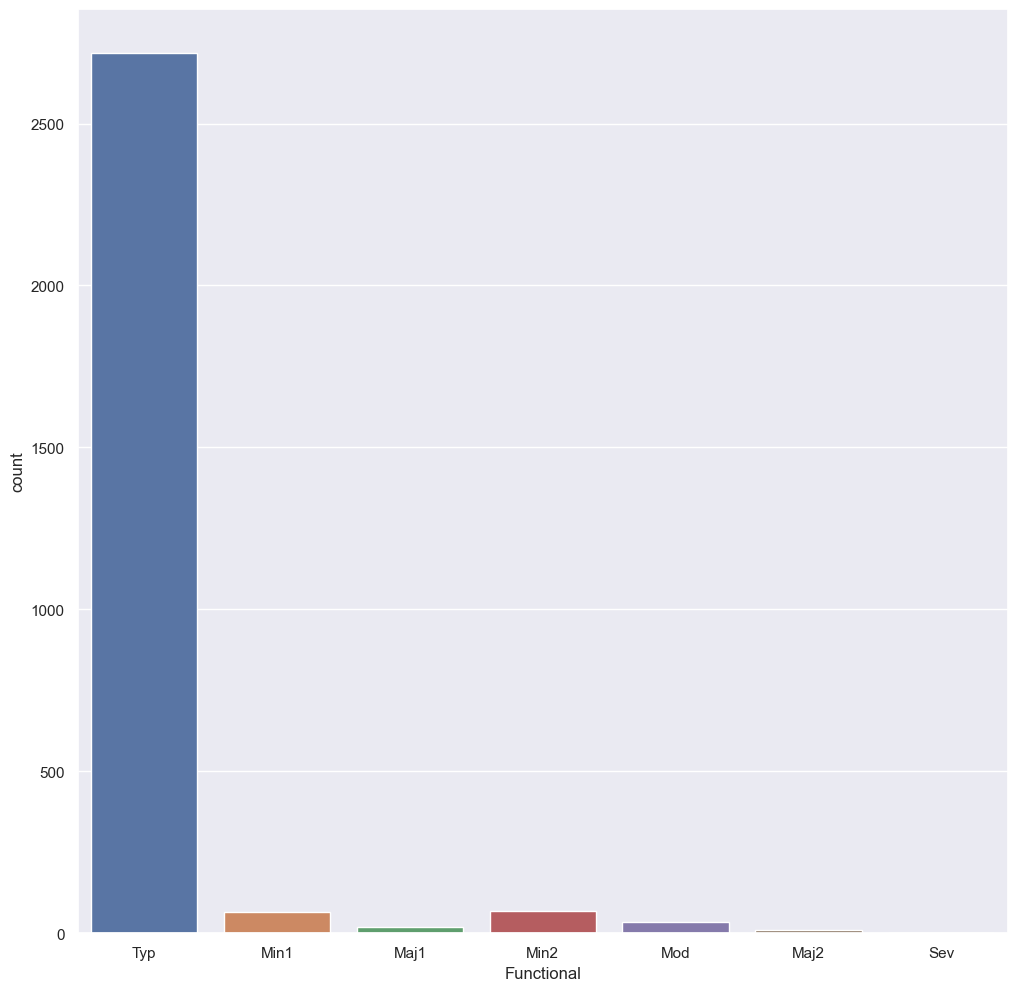




             FireplaceQu  ratio
FireplaceQu                    
Gd                   744  25.49
TA                   592  20.28
Fa                    74   2.54
Po                    46   1.58
Ex                    43   1.47


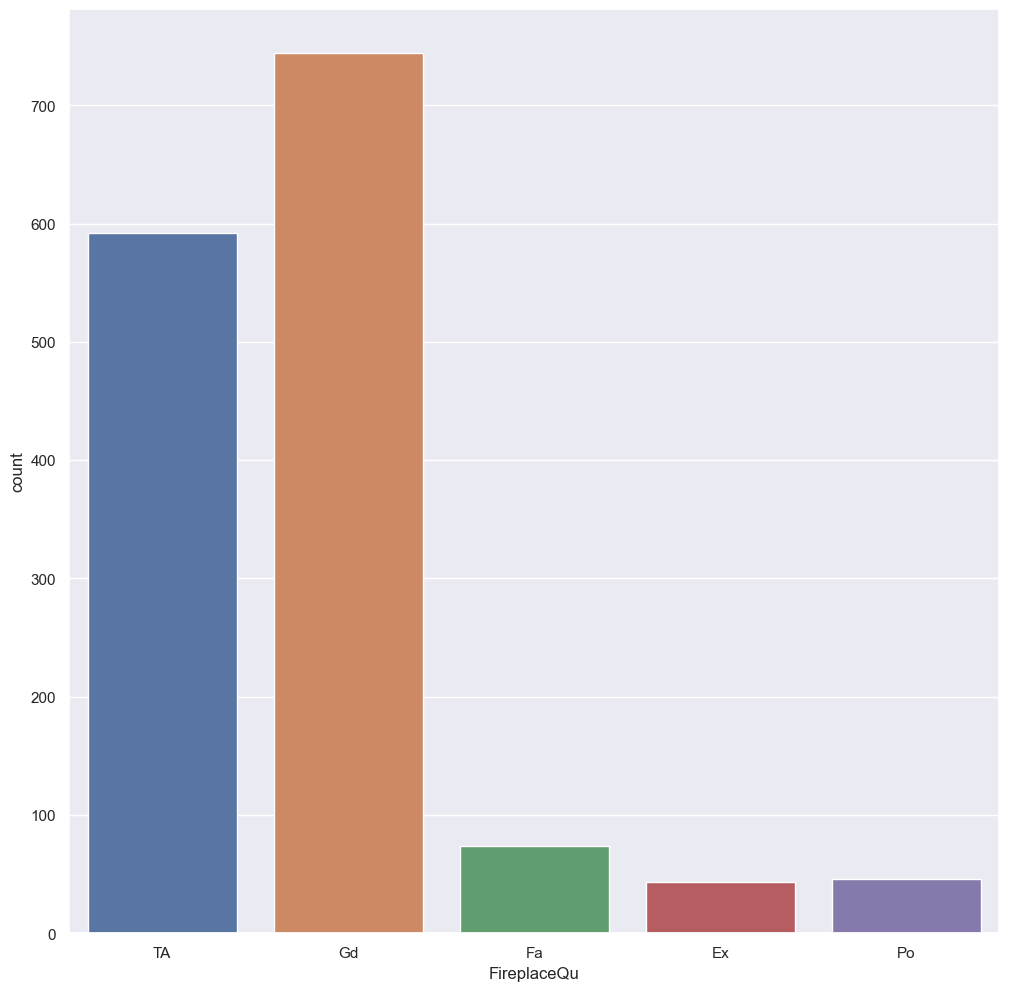




            GarageType  ratio
GarageType                   
Attchd            1723  59.03
Detchd             779  26.69
BuiltIn            186   6.37
Basment             36   1.23
2Types              23   0.79
CarPort             15   0.51


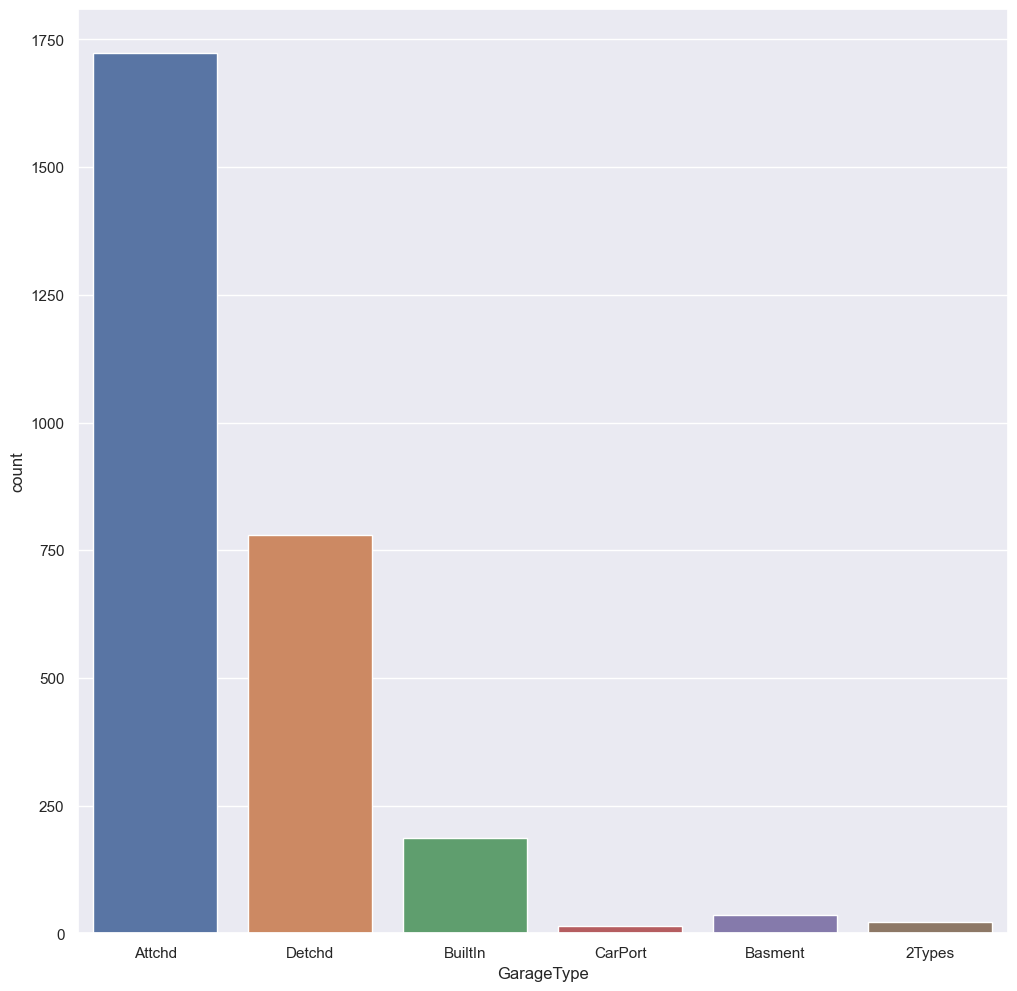




              GarageFinish  ratio
GarageFinish                     
Unf                   1230  42.14
RFn                    811  27.78
Fin                    719  24.63


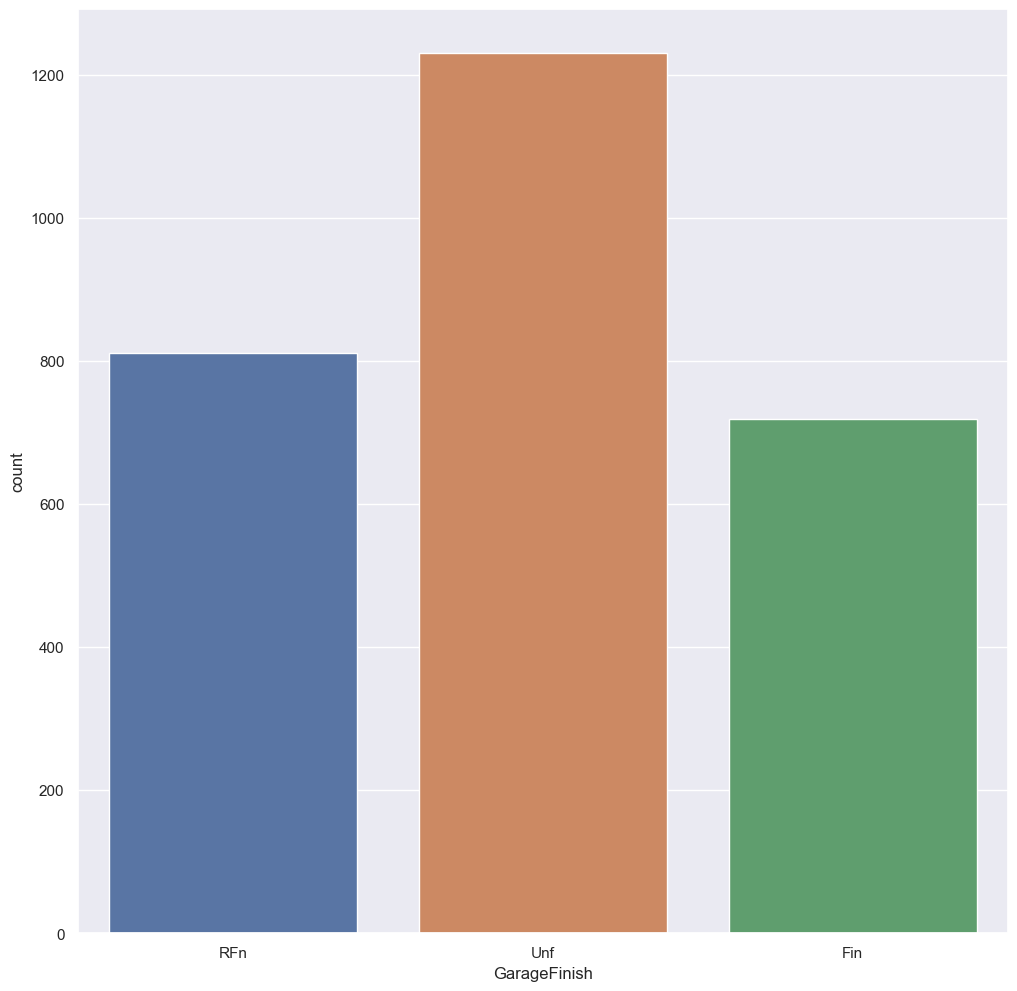




            GarageQual  ratio
GarageQual                   
TA                2604  89.21
Fa                 124   4.25
Gd                  24   0.82
Po                   5   0.17
Ex                   3   0.10


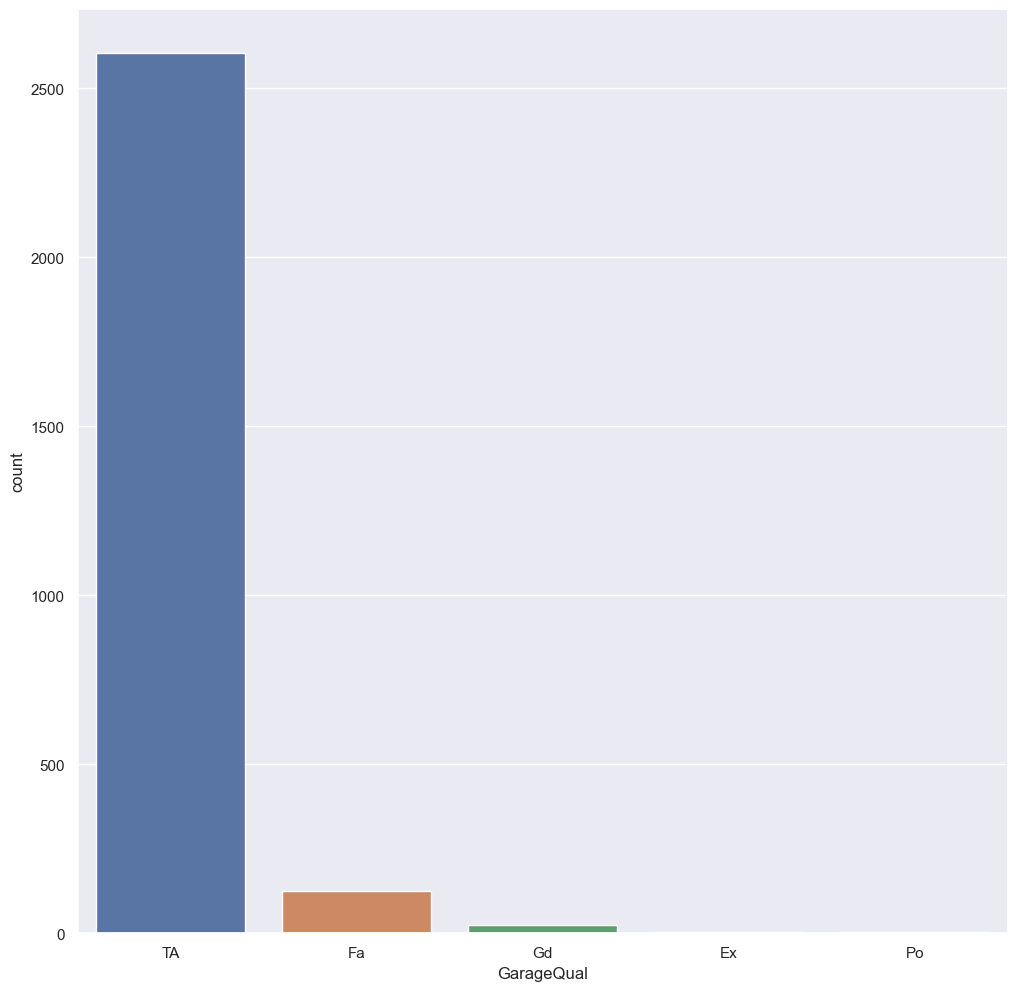




            GarageCond  ratio
GarageCond                   
TA                2654  90.92
Fa                  74   2.54
Gd                  15   0.51
Po                  14   0.48
Ex                   3   0.10


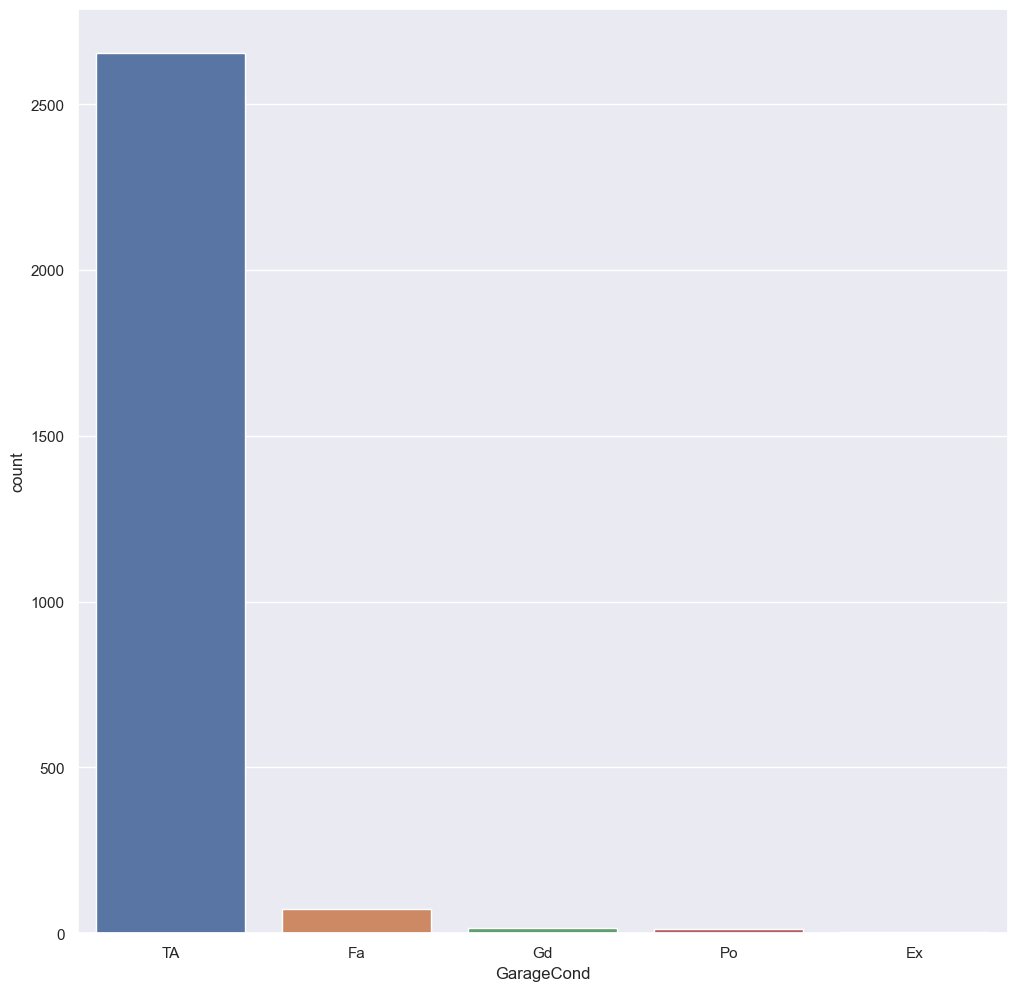




            PavedDrive  ratio
PavedDrive                   
Y                 2641  90.48
N                  216   7.40
P                   62   2.12


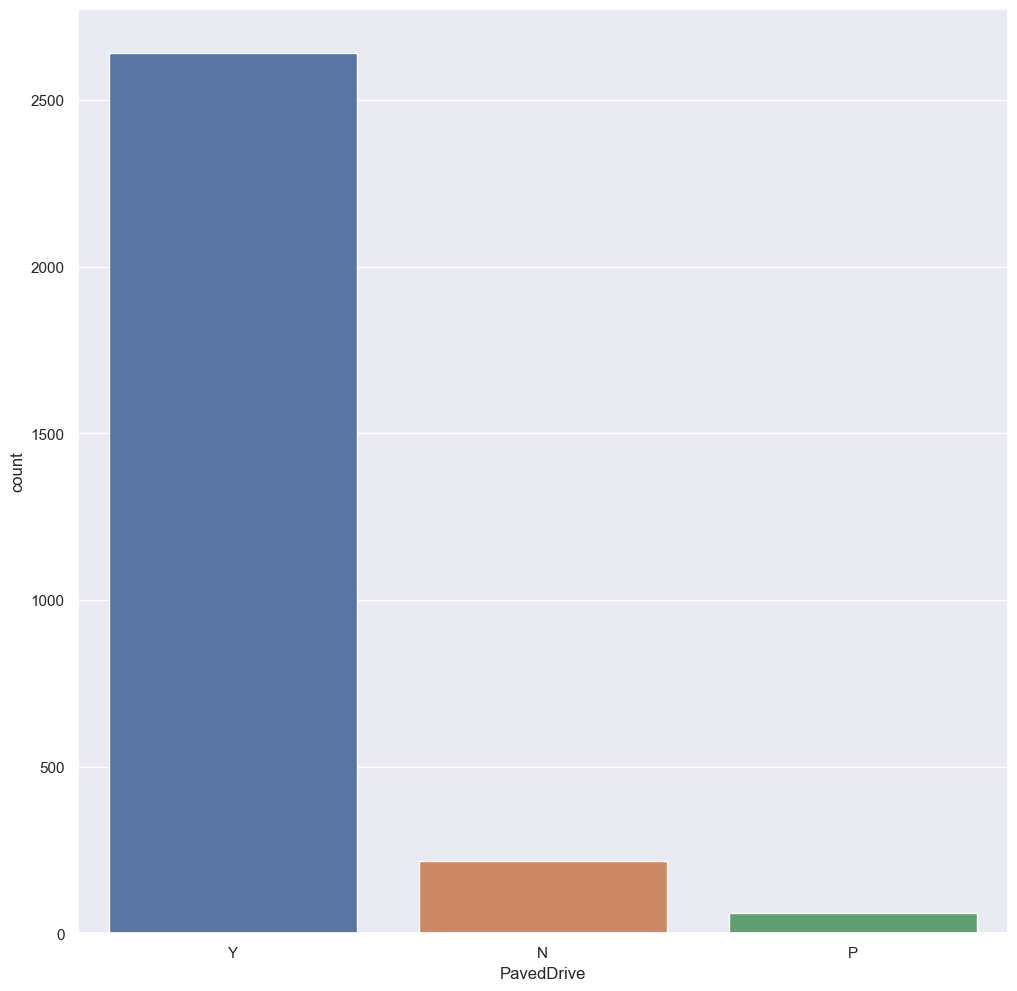




        PoolQC  ratio
PoolQC               
Ex           4   0.14
Gd           4   0.14
Fa           2   0.07


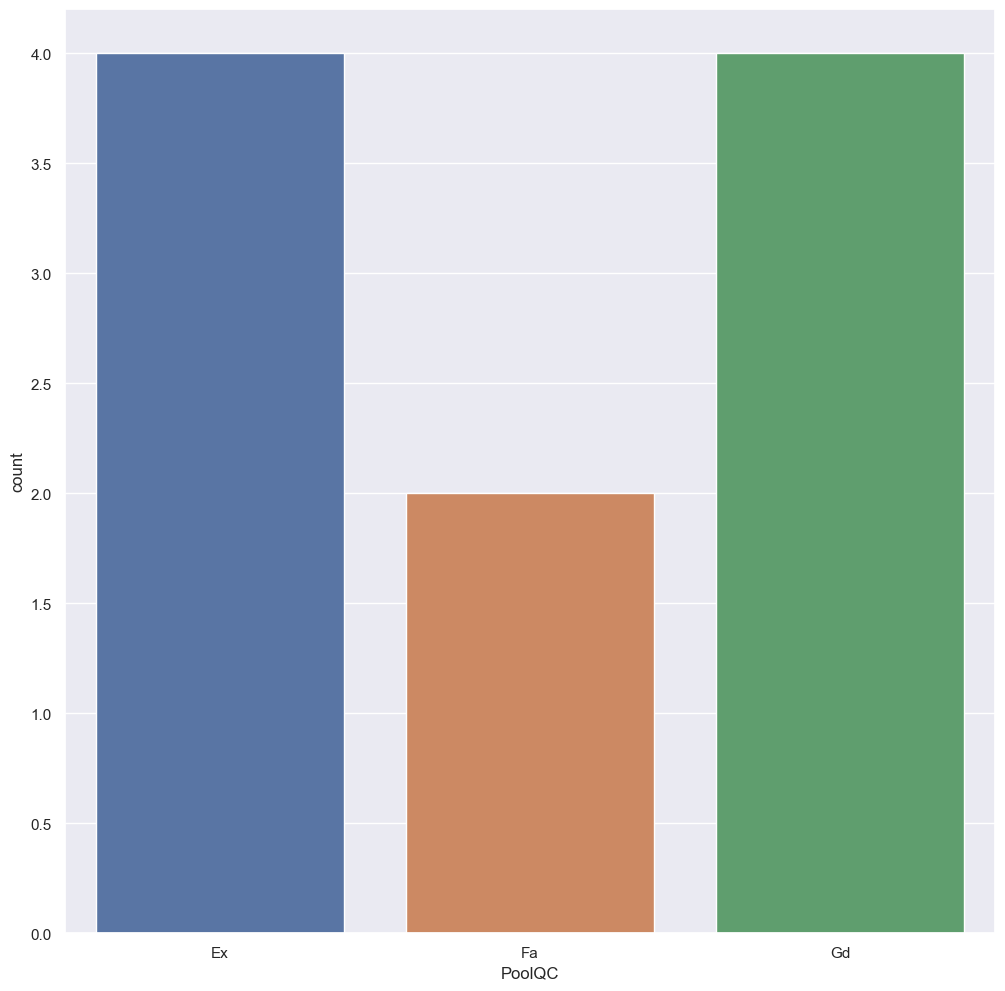




       Fence  ratio
Fence              
MnPrv    329  11.27
GdPrv    118   4.04
GdWo     112   3.84
MnWw      12   0.41


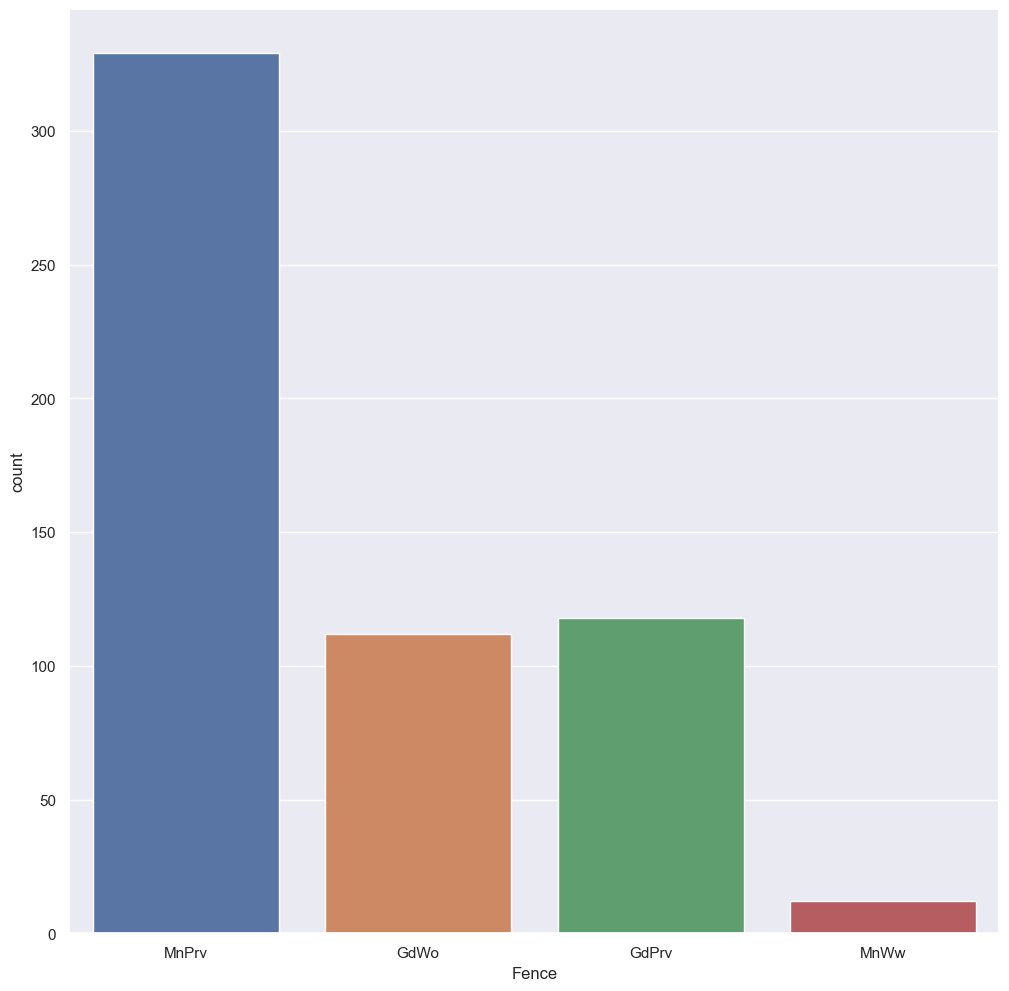




             MiscFeature  ratio
MiscFeature                    
Shed                  95   3.25
Gar2                   5   0.17
Othr                   4   0.14
TenC                   1   0.03


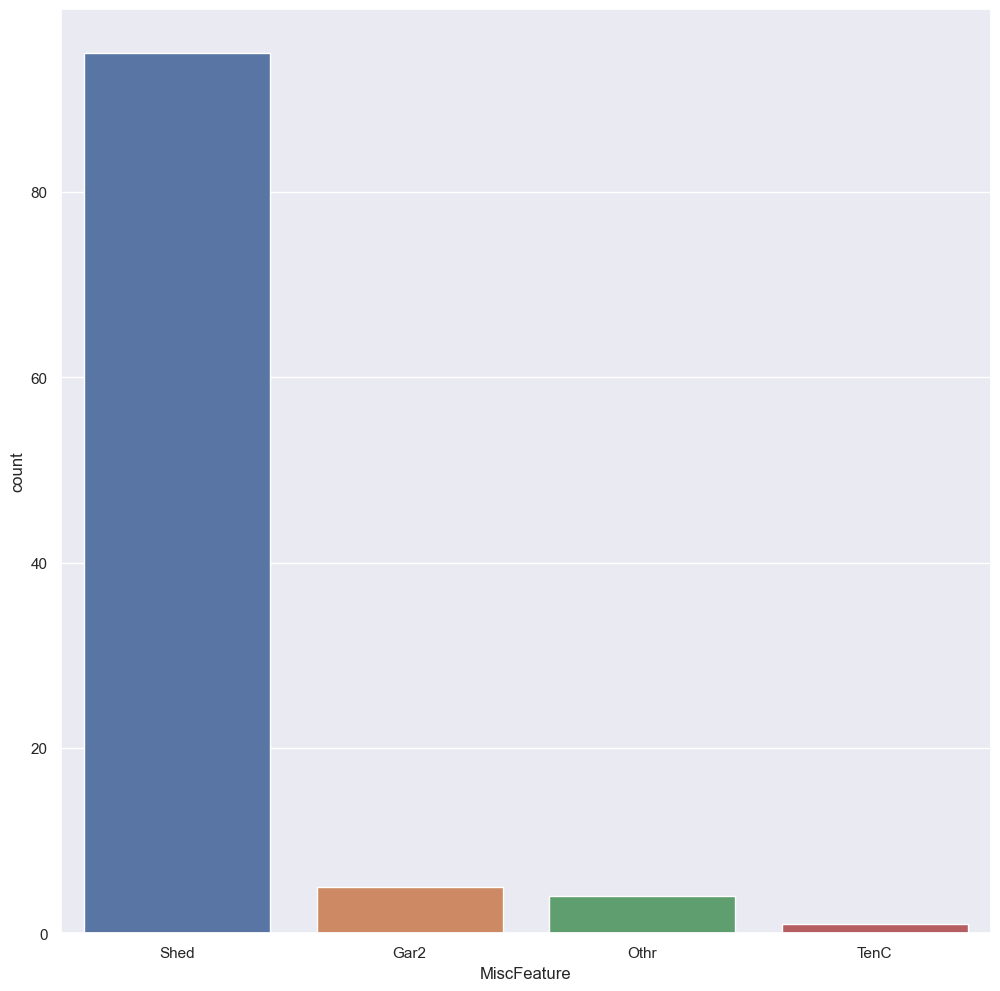




          SaleType  ratio
SaleType                 
WD            2525  86.50
New            239   8.19
COD             87   2.98
ConLD           26   0.89
CWD             12   0.41
ConLI            9   0.31
ConLw            8   0.27
Oth              7   0.24
Con              5   0.17


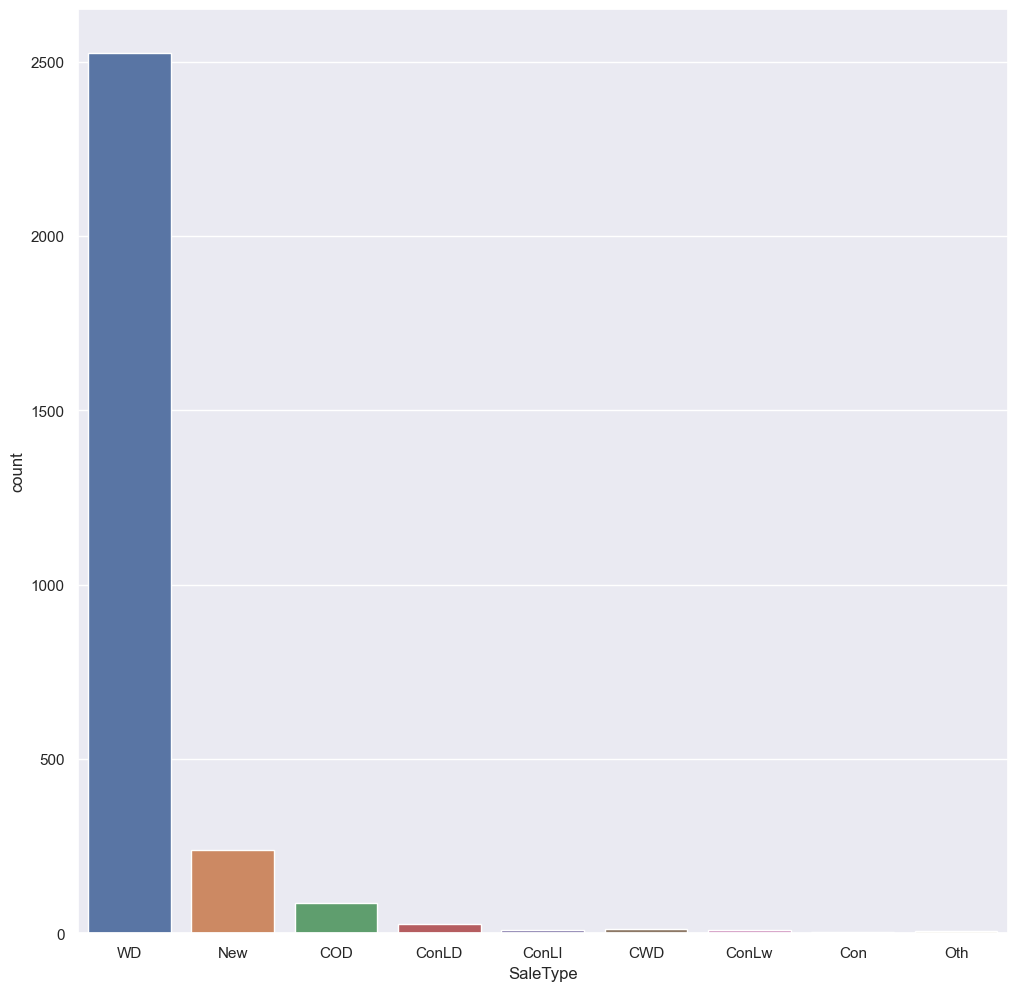




               SaleCondition  ratio
SaleCondition                      
Normal                  2402  82.29
Partial                  245   8.39
Abnorml                  190   6.51
Family                    46   1.58
Alloca                    24   0.82
AdjLand                   12   0.41


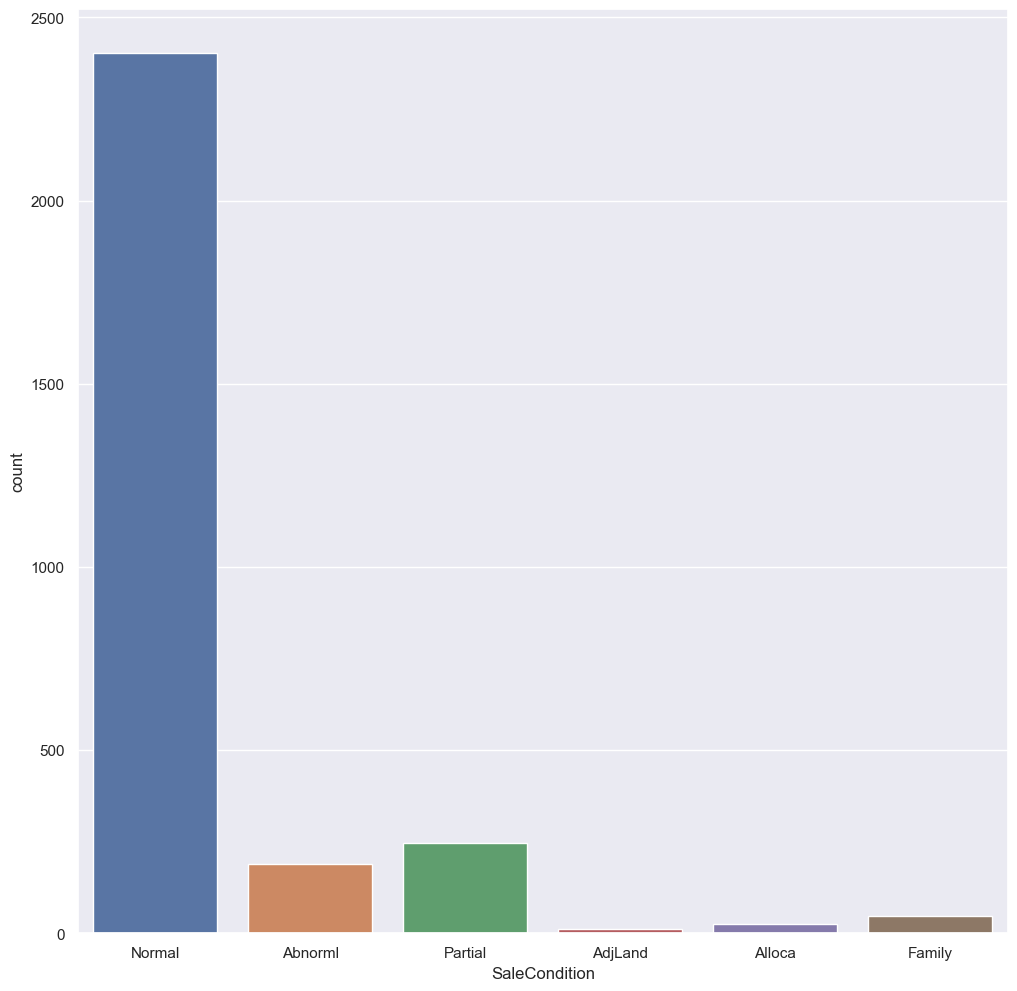




             OverallCond  ratio
OverallCond                    
5                   1645  56.35
6                    531  18.19
7                    390  13.36
8                    144   4.93
4                    101   3.46
3                     50   1.71
9                     41   1.40
2                     10   0.34
1                      7   0.24


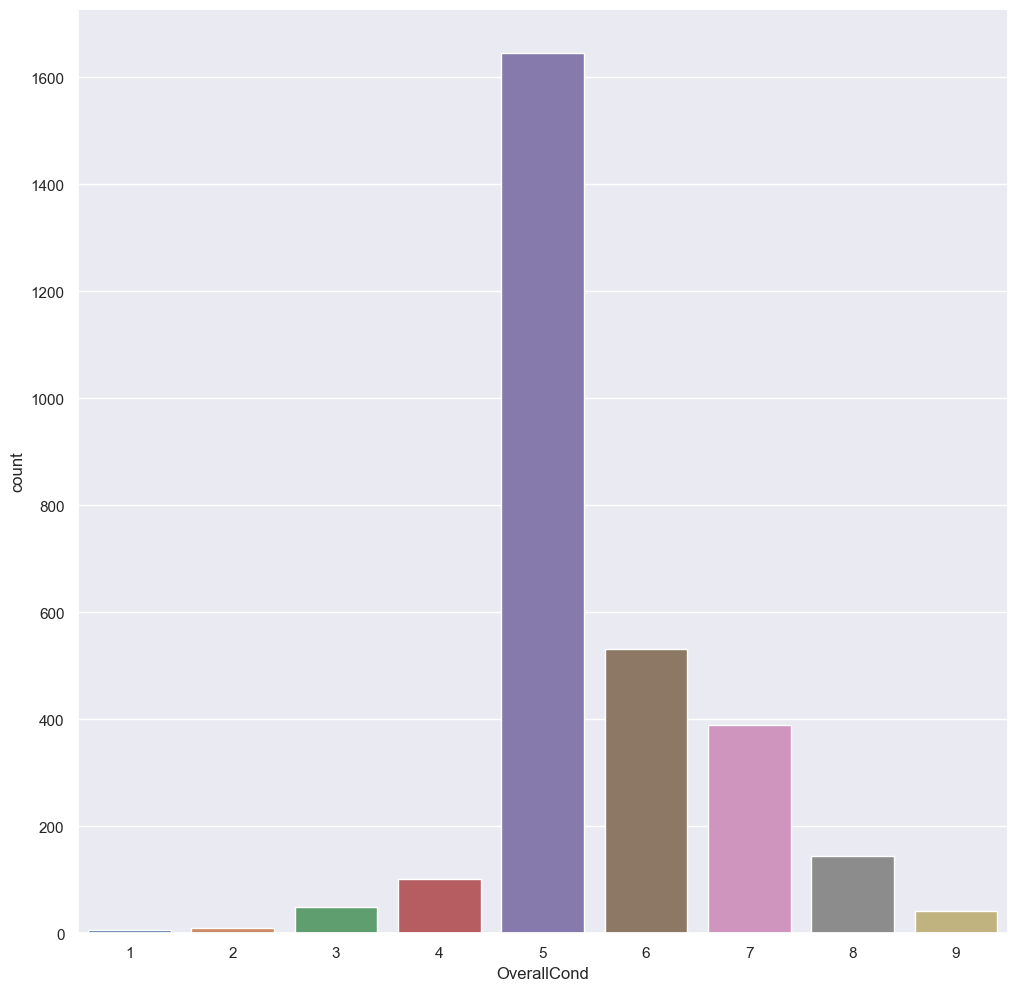




              BsmtFullBath  ratio
BsmtFullBath                     
0.00                  1705  58.41
1.00                  1172  40.15
2.00                    38   1.30
3.00                     2   0.07


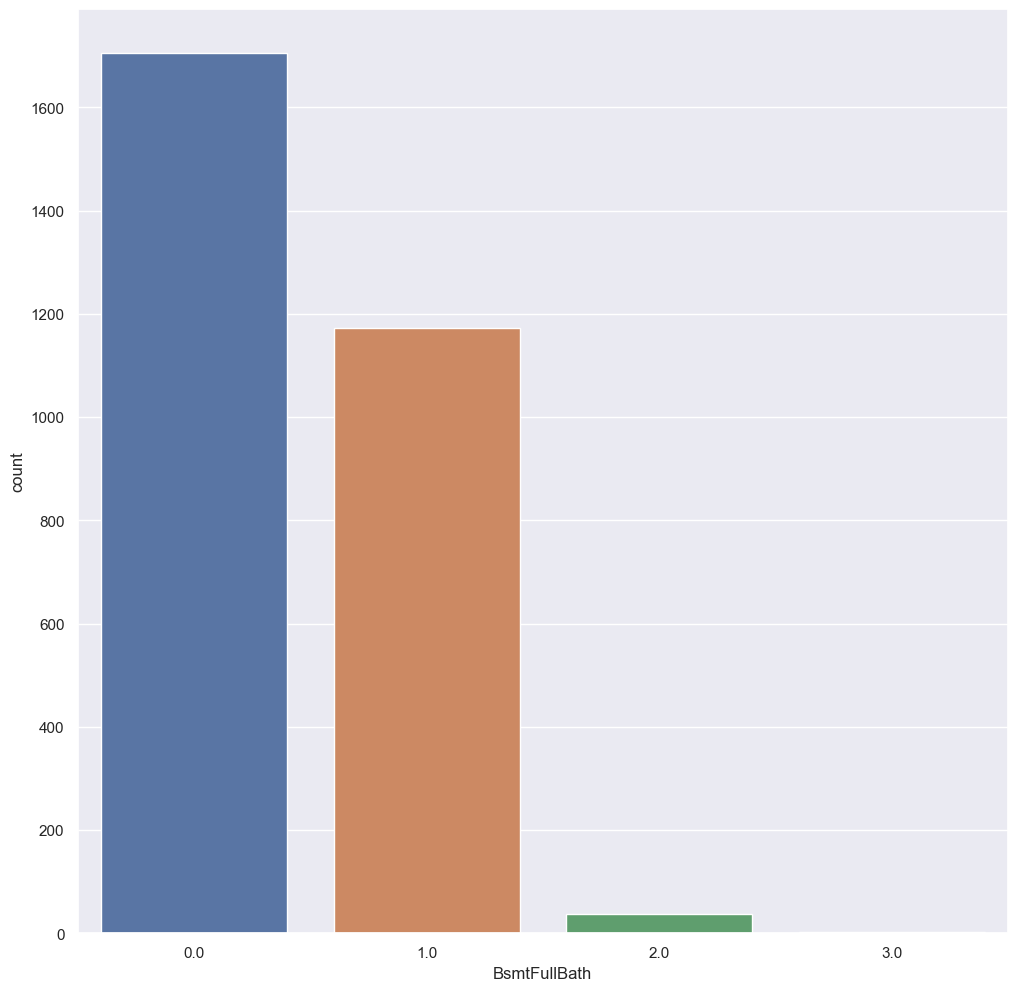




              BsmtHalfBath  ratio
BsmtHalfBath                     
0.00                  2742  93.94
1.00                   171   5.86
2.00                     4   0.14


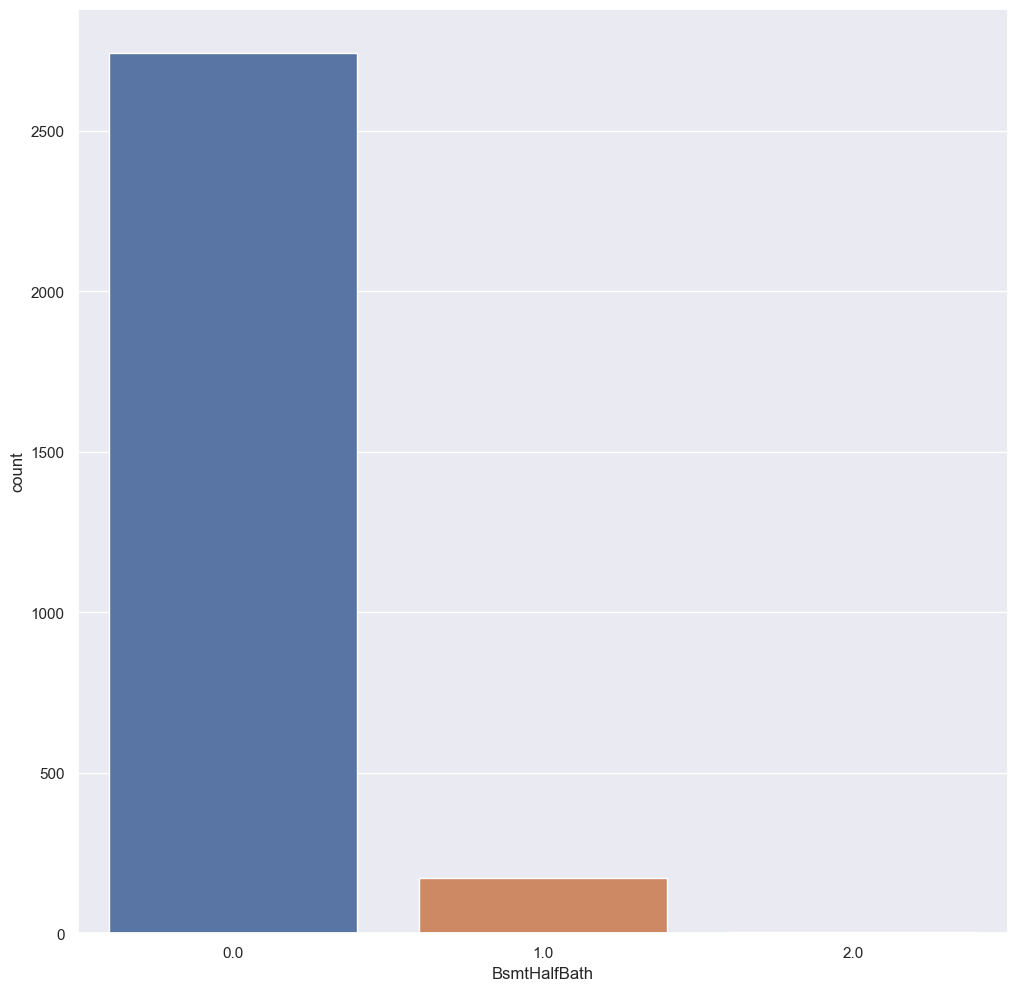




          FullBath  ratio
FullBath                 
2             1530  52.42
1             1309  44.84
3               64   2.19
0               12   0.41
4                4   0.14


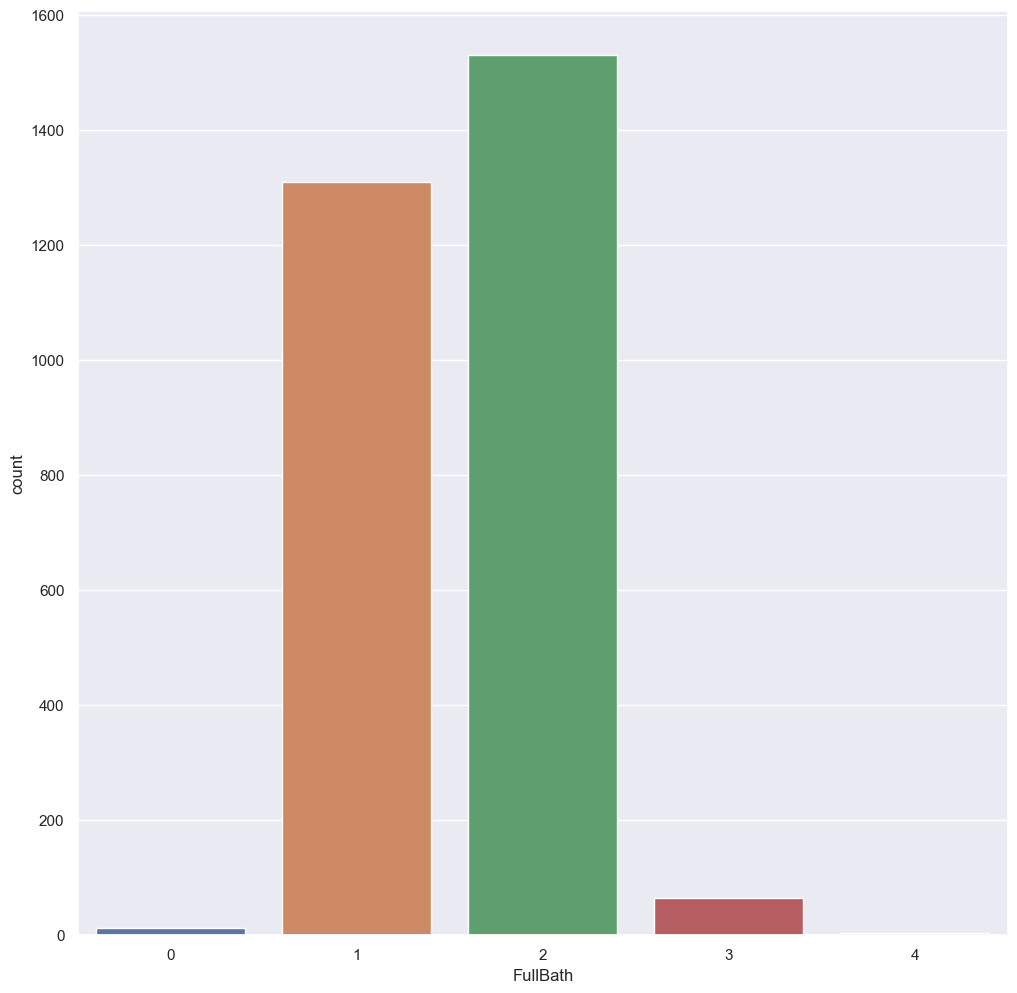




          HalfBath  ratio
HalfBath                 
0             1834  62.83
1             1060  36.31
2               25   0.86


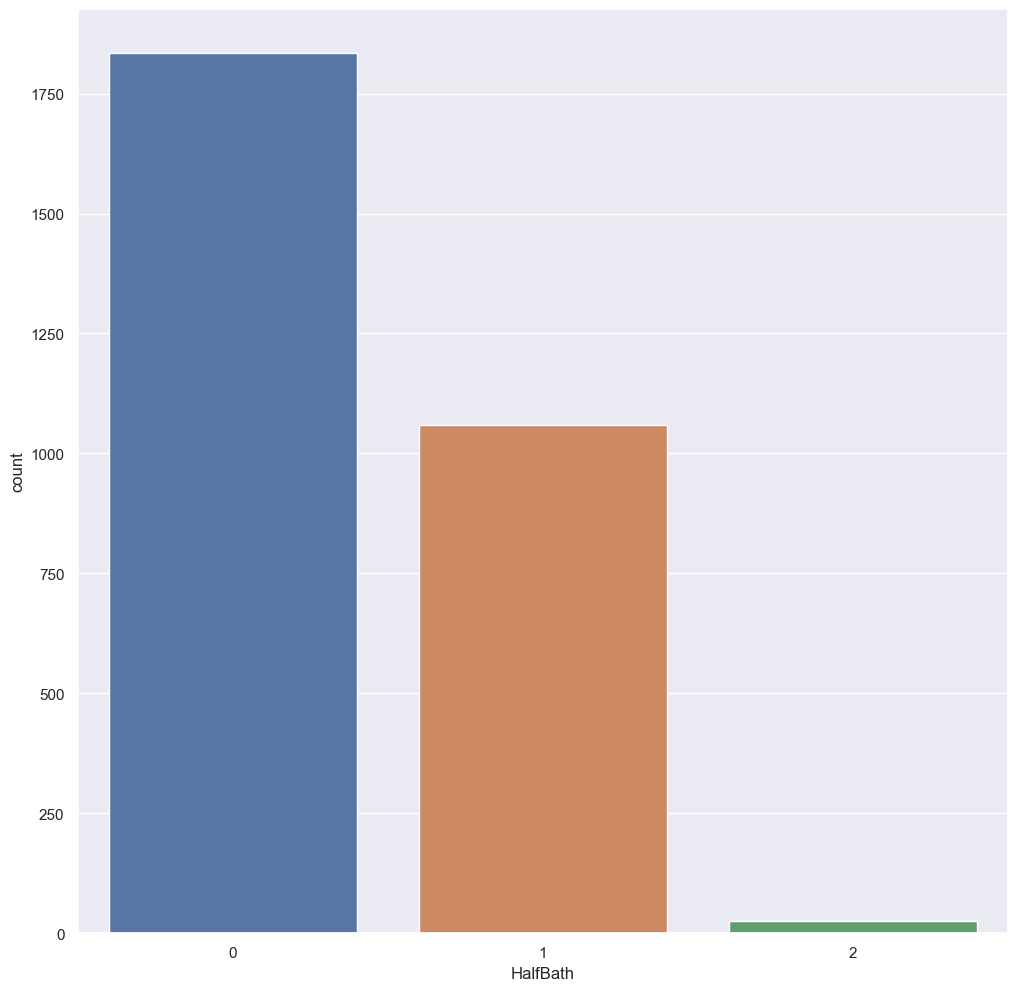




              BedroomAbvGr  ratio
BedroomAbvGr                     
3                     1596  54.68
2                      742  25.42
4                      400  13.70
1                      103   3.53
5                       48   1.64
6                       21   0.72
0                        8   0.27
8                        1   0.03


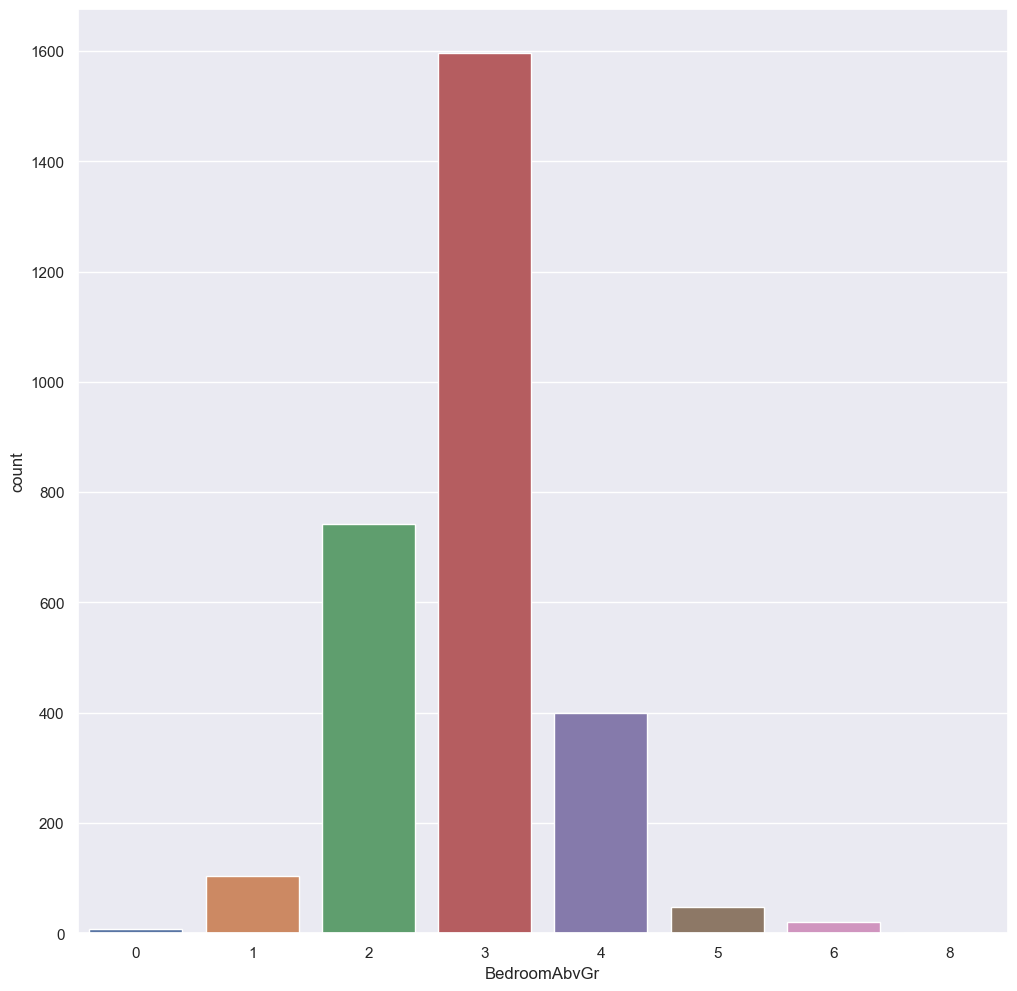




              KitchenAbvGr  ratio
KitchenAbvGr                     
1                     2785  95.41
2                      129   4.42
0                        3   0.10
3                        2   0.07


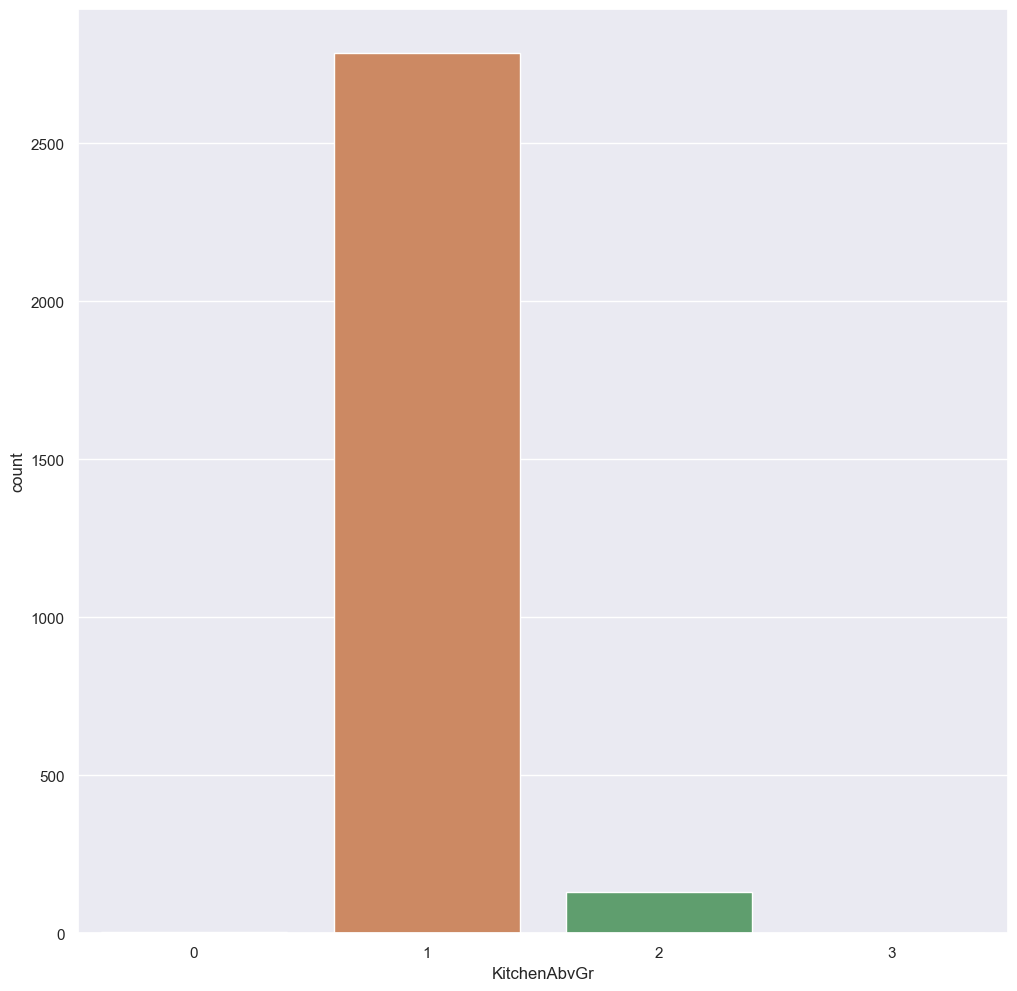




            Fireplaces  ratio
Fireplaces                   
0                 1420  48.65
1                 1268  43.44
2                  219   7.50
3                   11   0.38
4                    1   0.03


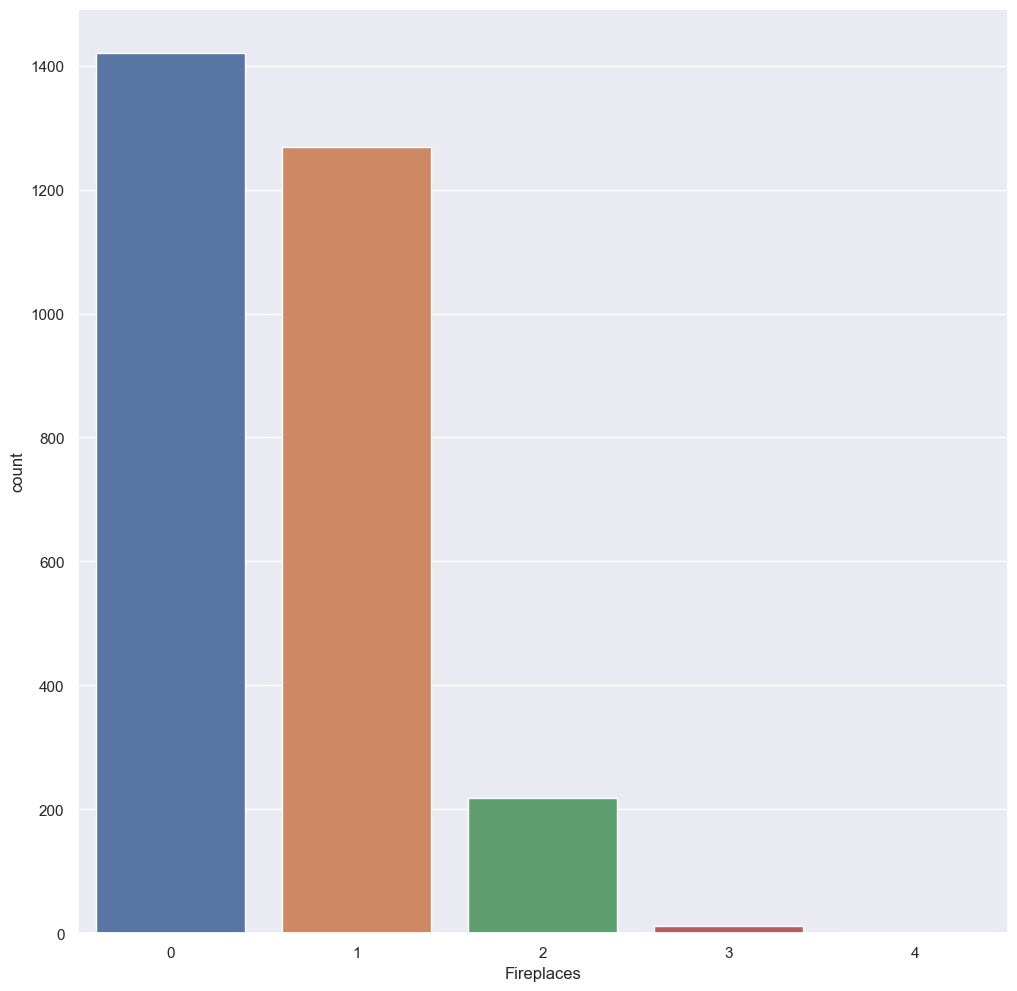




            GarageCars  ratio
GarageCars                   
2.00              1594  54.61
1.00               776  26.58
3.00               374  12.81
0.00               157   5.38
4.00                16   0.55
5.00                 1   0.03


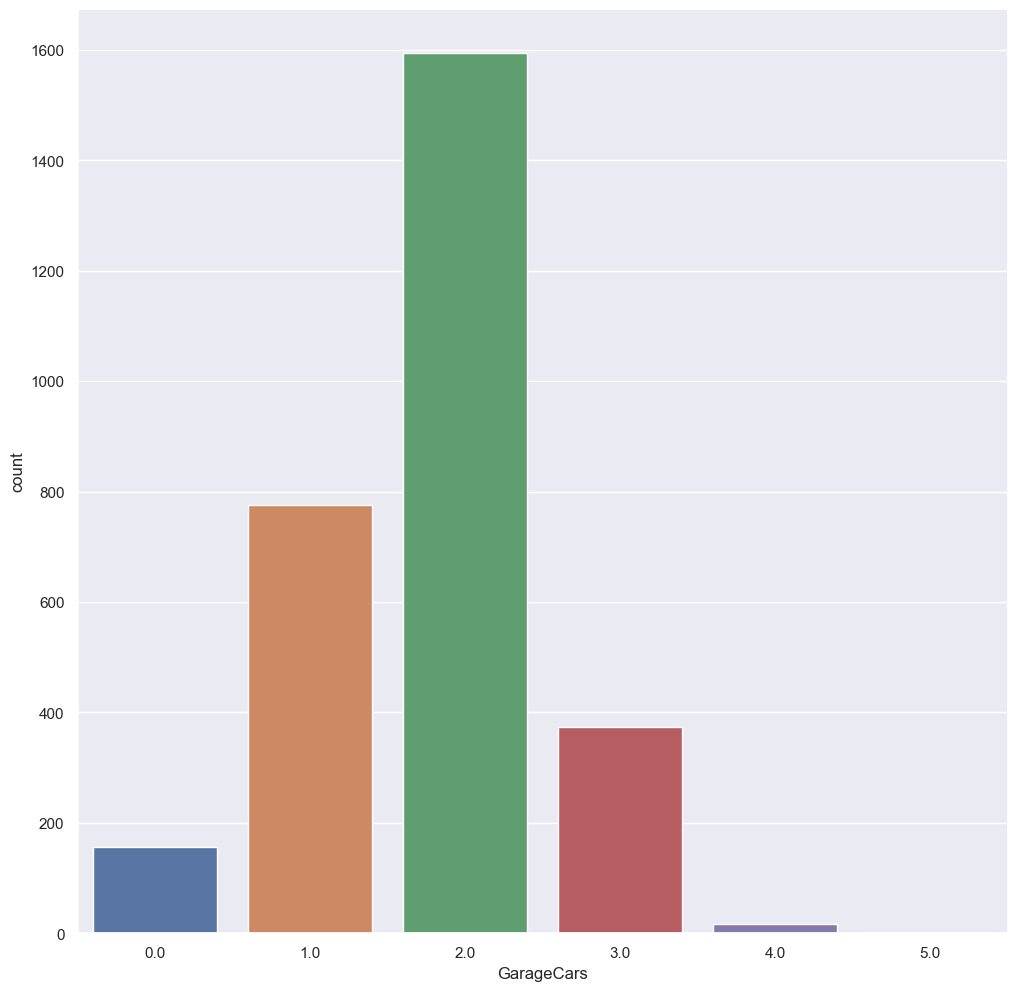




        YrSold  ratio
YrSold               
2007       692  23.71
2009       647  22.17
2008       622  21.31
2006       619  21.21
2010       339  11.61


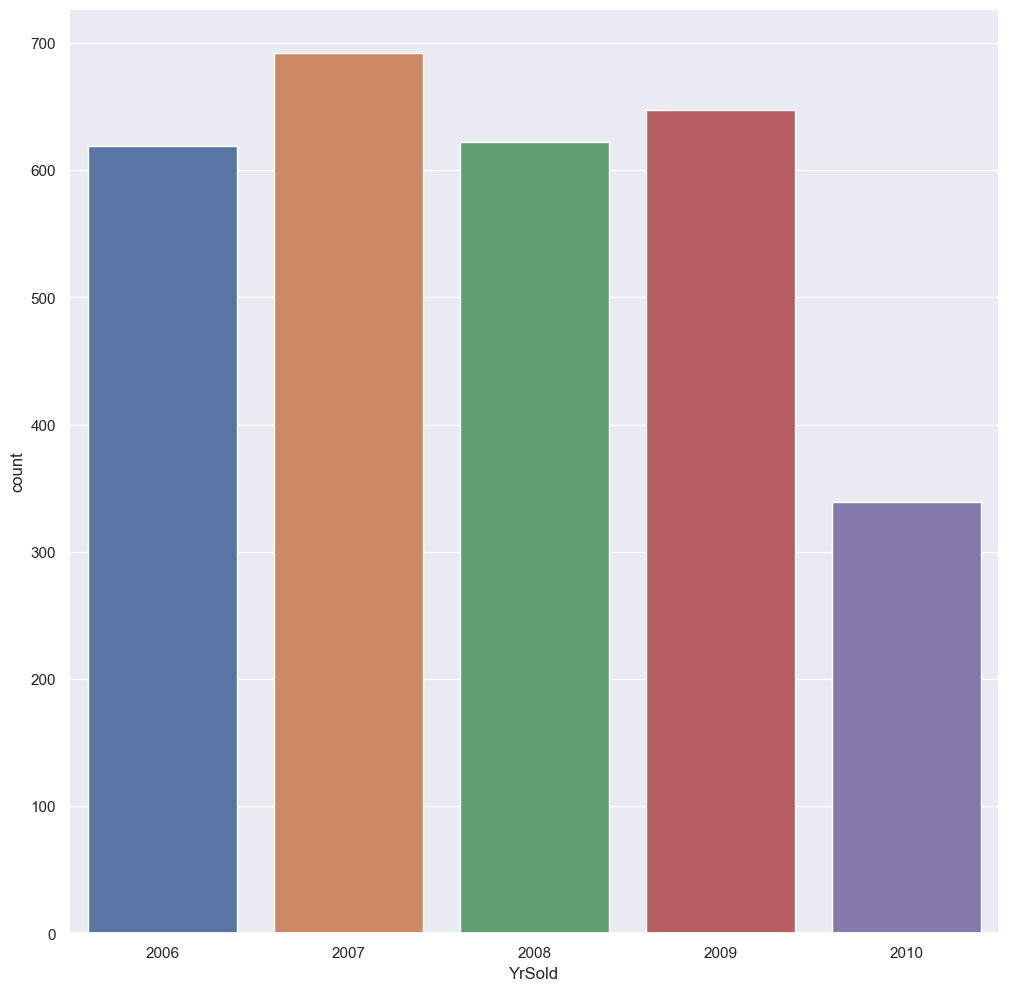

In [591]:
for col in cat_cols:
    cat_summary(df,col,plot=True)

**5- Numerik Değişken analizi**

In [593]:
def num_summary(data, num_cols, plot=True):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    print(data[num_cols].describe(quantiles).T)

    if plot:
        data[num_cols].hist(bins=50)
        plt.xlabel(num_cols)
        plt.title(num_cols)
        plt.show(block=True)

    print('\n\n')

In [594]:
# ID değişkenini num_cols içerisinden çıkartıyorum.

num_cols = [col for col in num_cols if col not in 'Id']

count   2919.00
mean      57.14
std       42.52
min       20.00
5%        20.00
10%       20.00
20%       20.00
30%       20.00
40%       30.00
50%       50.00
60%       60.00
70%       60.00
80%       80.00
90%      120.00
99%      190.00
max      190.00
Name: MSSubClass, dtype: float64


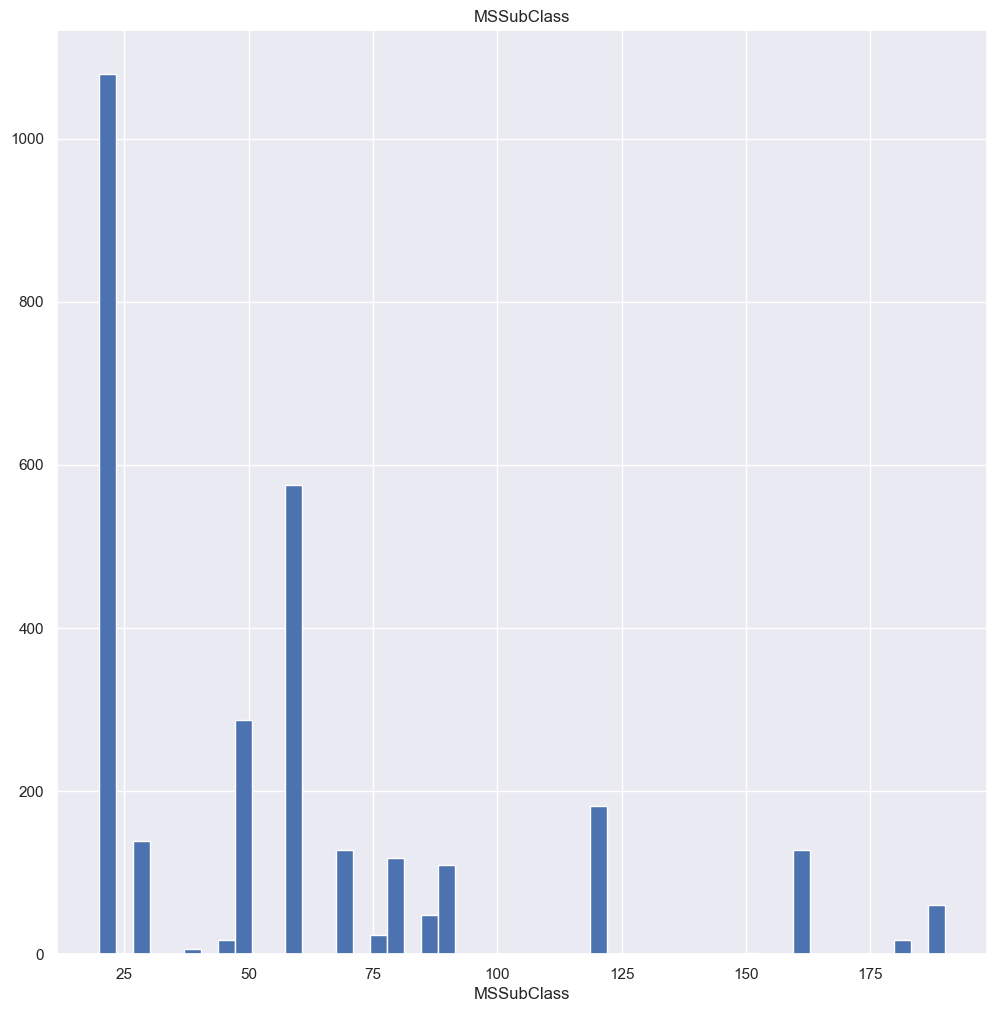




count   2433.00
mean      69.31
std       23.34
min       21.00
5%        32.00
10%       43.00
20%       53.00
30%       60.00
40%       63.00
50%       68.00
60%       73.00
70%       78.00
80%       84.00
90%       95.00
99%      135.68
max      313.00
Name: LotFrontage, dtype: float64


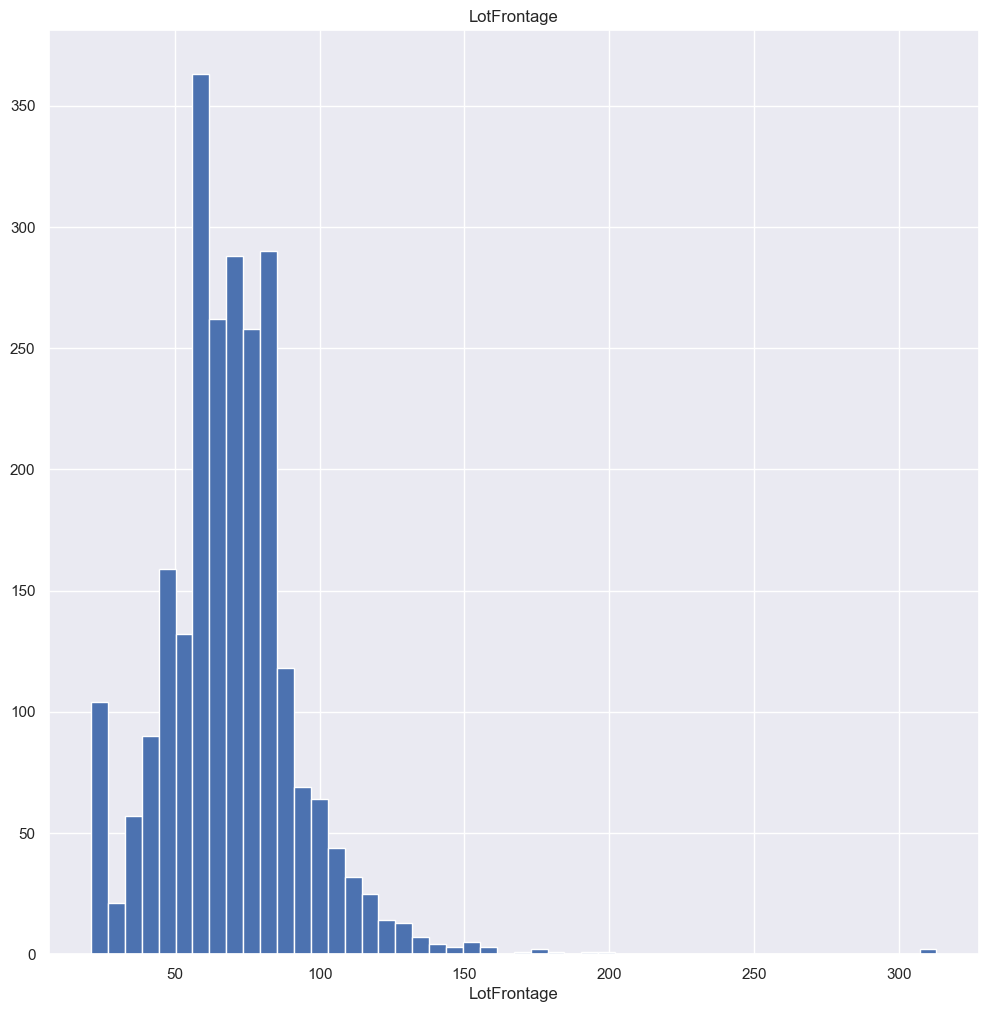




count     2919.00
mean     10168.11
std       7887.00
min       1300.00
5%        3182.00
10%       4922.40
20%       7007.60
30%       7960.40
40%       8741.00
50%       9453.00
60%      10151.60
70%      11001.20
80%      12203.80
90%      14300.60
99%      33038.64
max     215245.00
Name: LotArea, dtype: float64


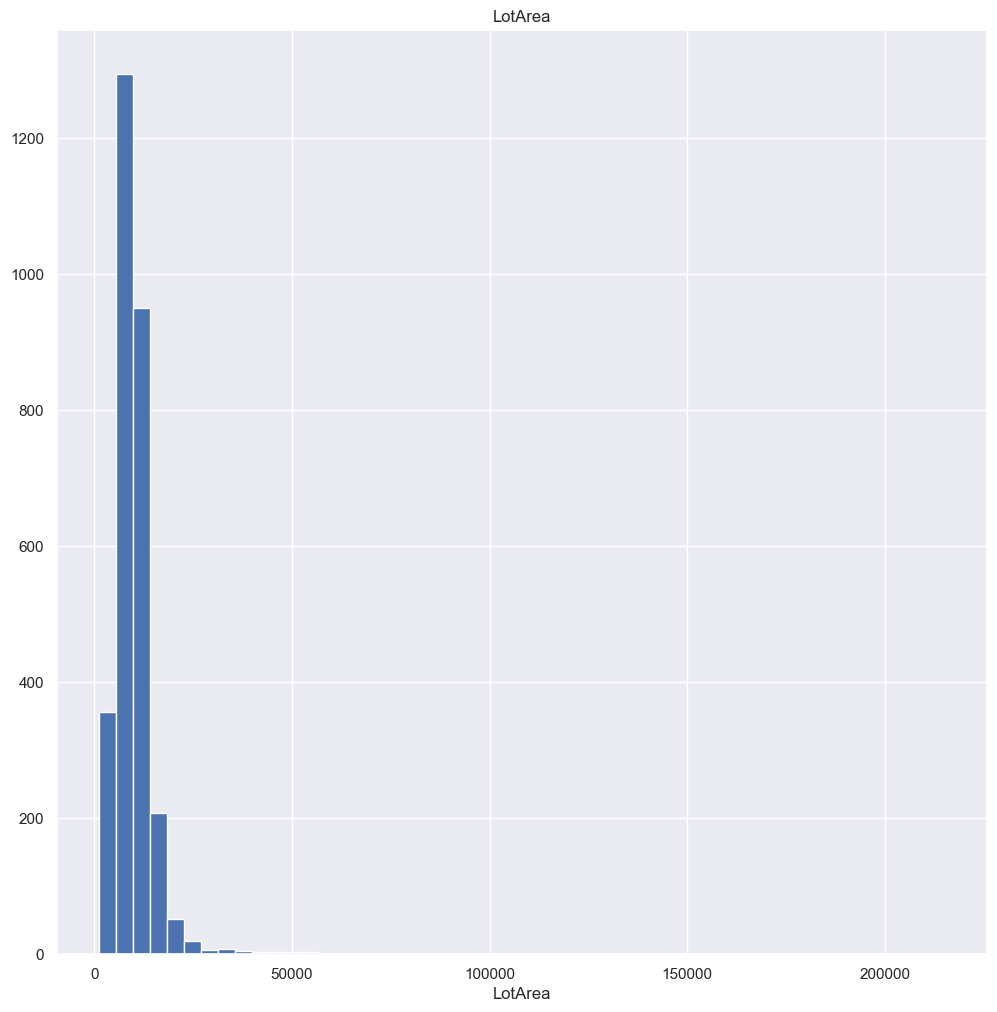




count   2919.00
mean       6.09
std        1.41
min        1.00
5%         4.00
10%        5.00
20%        5.00
30%        5.00
40%        6.00
50%        6.00
60%        6.00
70%        7.00
80%        7.00
90%        8.00
99%       10.00
max       10.00
Name: OverallQual, dtype: float64


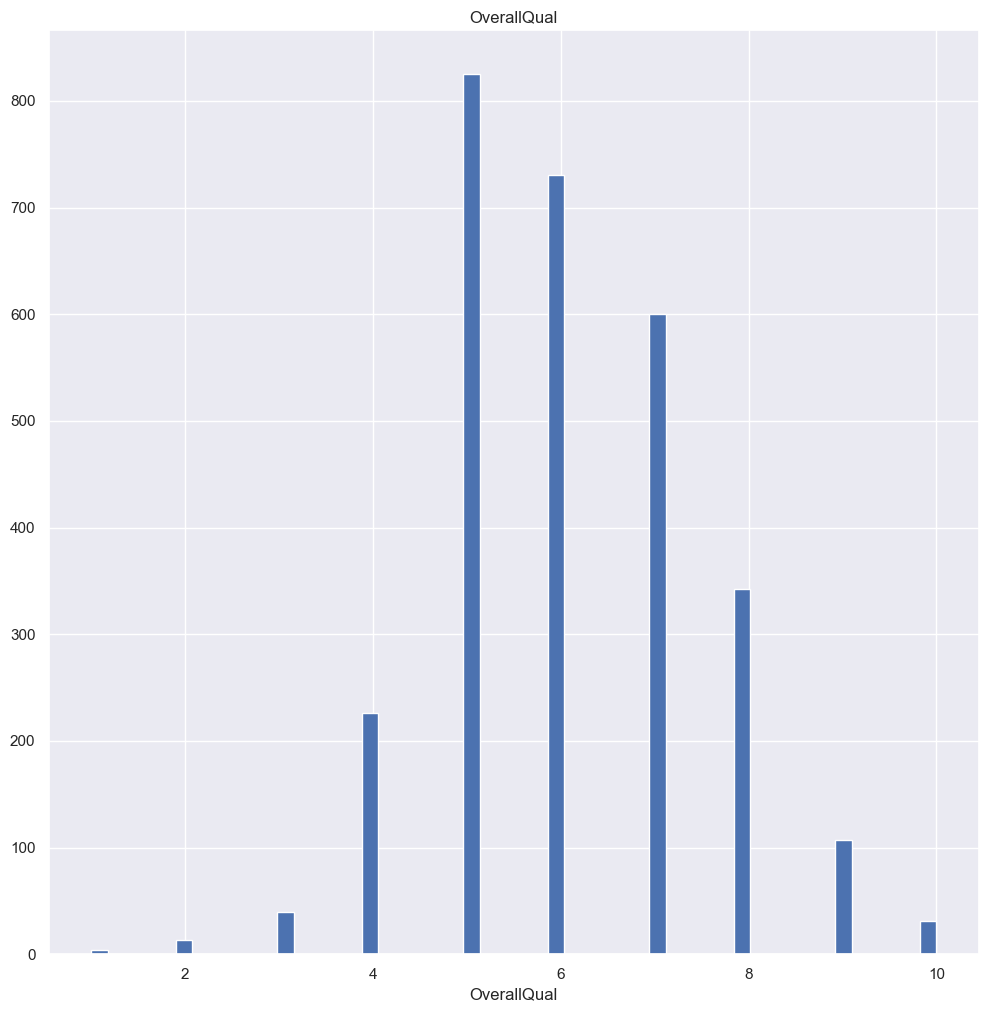




count   2919.00
mean    1971.31
std       30.29
min     1872.00
5%      1915.00
10%     1924.00
20%     1947.00
30%     1957.00
40%     1965.00
50%     1973.00
60%     1984.00
70%     1998.00
80%     2003.00
90%     2006.00
99%     2008.00
max     2010.00
Name: YearBuilt, dtype: float64


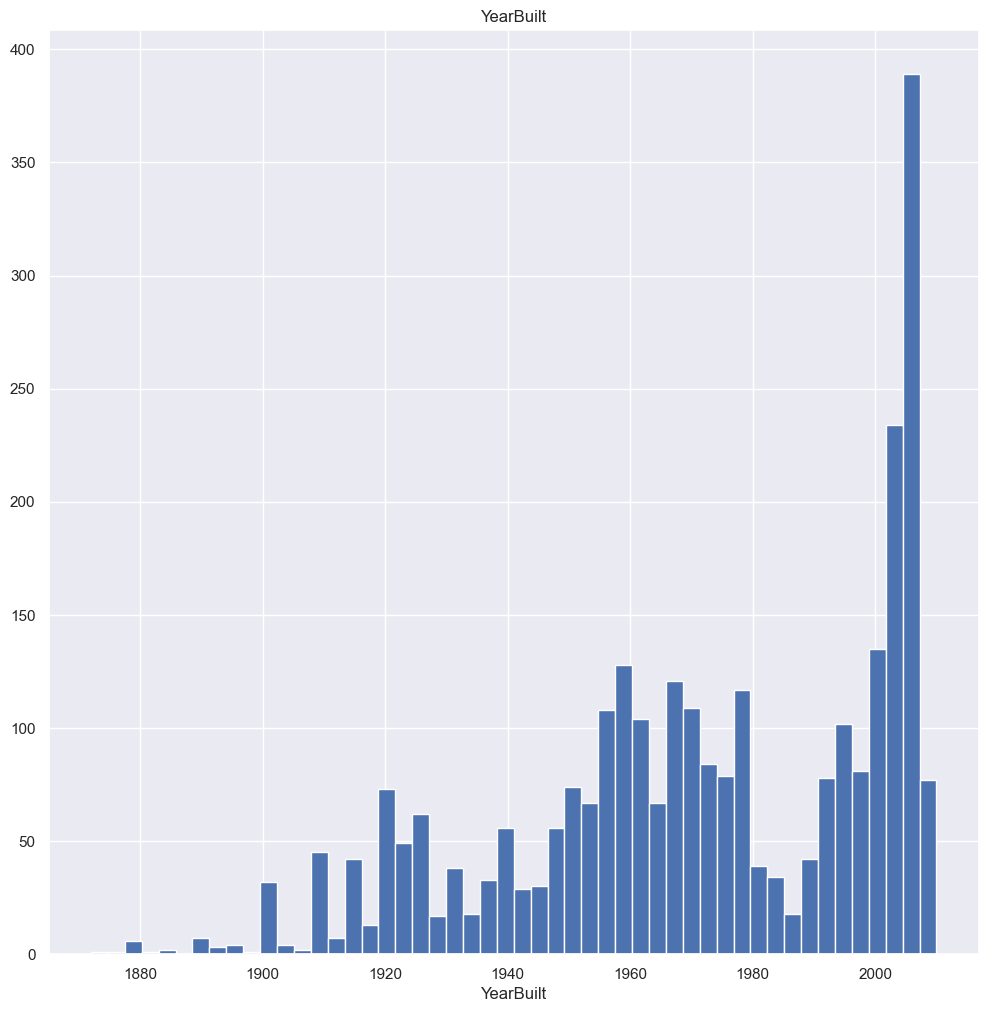




count   2919.00
mean    1984.26
std       20.89
min     1950.00
5%      1950.00
10%     1950.00
20%     1960.00
30%     1970.00
40%     1978.00
50%     1993.00
60%     1998.00
70%     2002.00
80%     2005.00
90%     2006.20
99%     2009.00
max     2010.00
Name: YearRemodAdd, dtype: float64


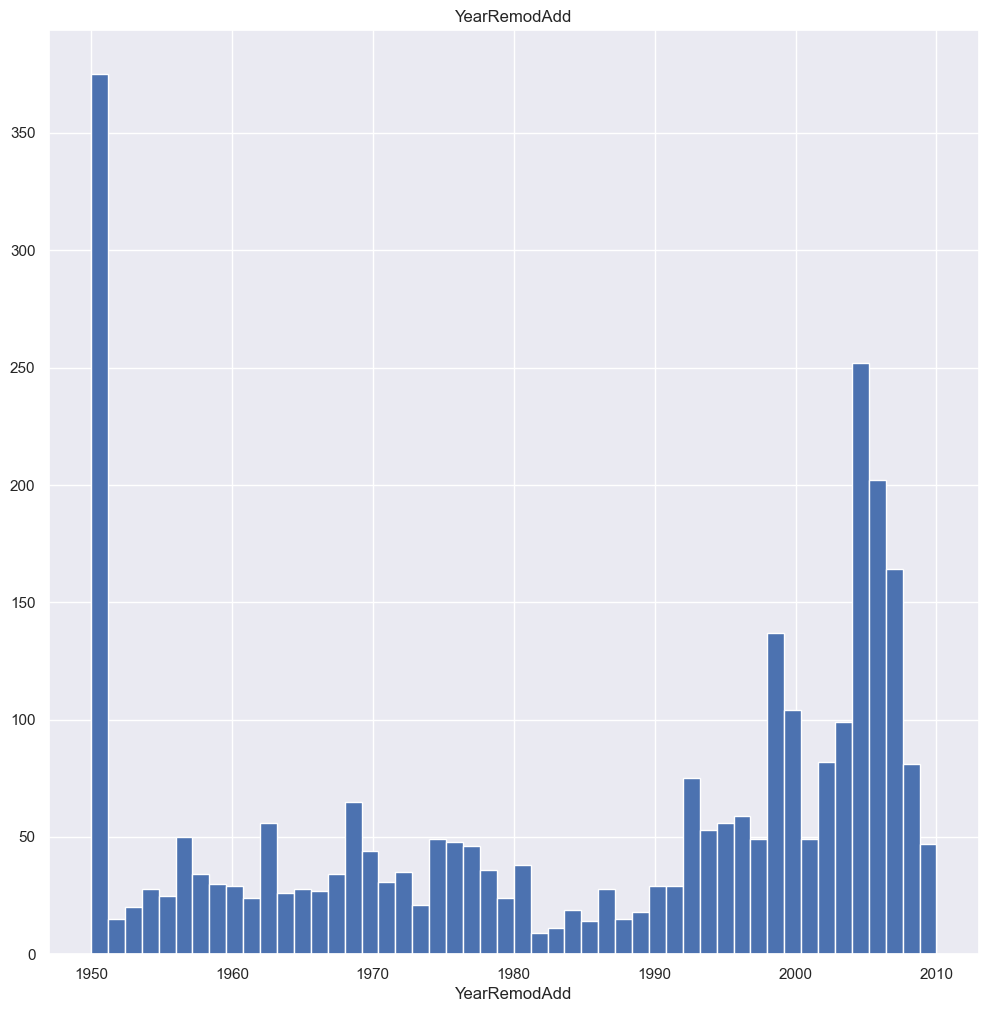




count   2896.00
mean     102.20
std      179.33
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%      120.00
80%      202.00
90%      325.50
99%      771.05
max     1600.00
Name: MasVnrArea, dtype: float64


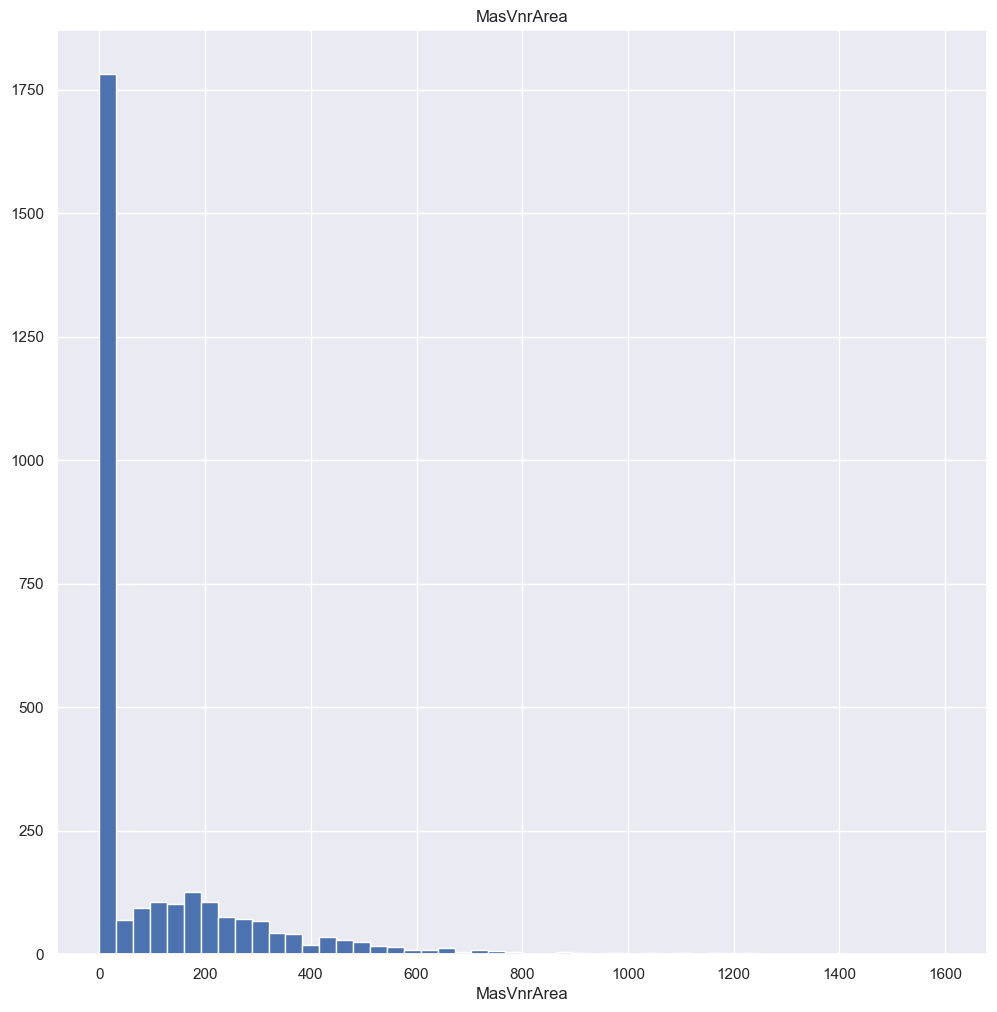




count   2918.00
mean     441.42
std      455.61
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%      202.60
50%      368.50
60%      515.20
70%      656.00
80%      812.00
90%     1056.90
99%     1635.32
max     5644.00
Name: BsmtFinSF1, dtype: float64


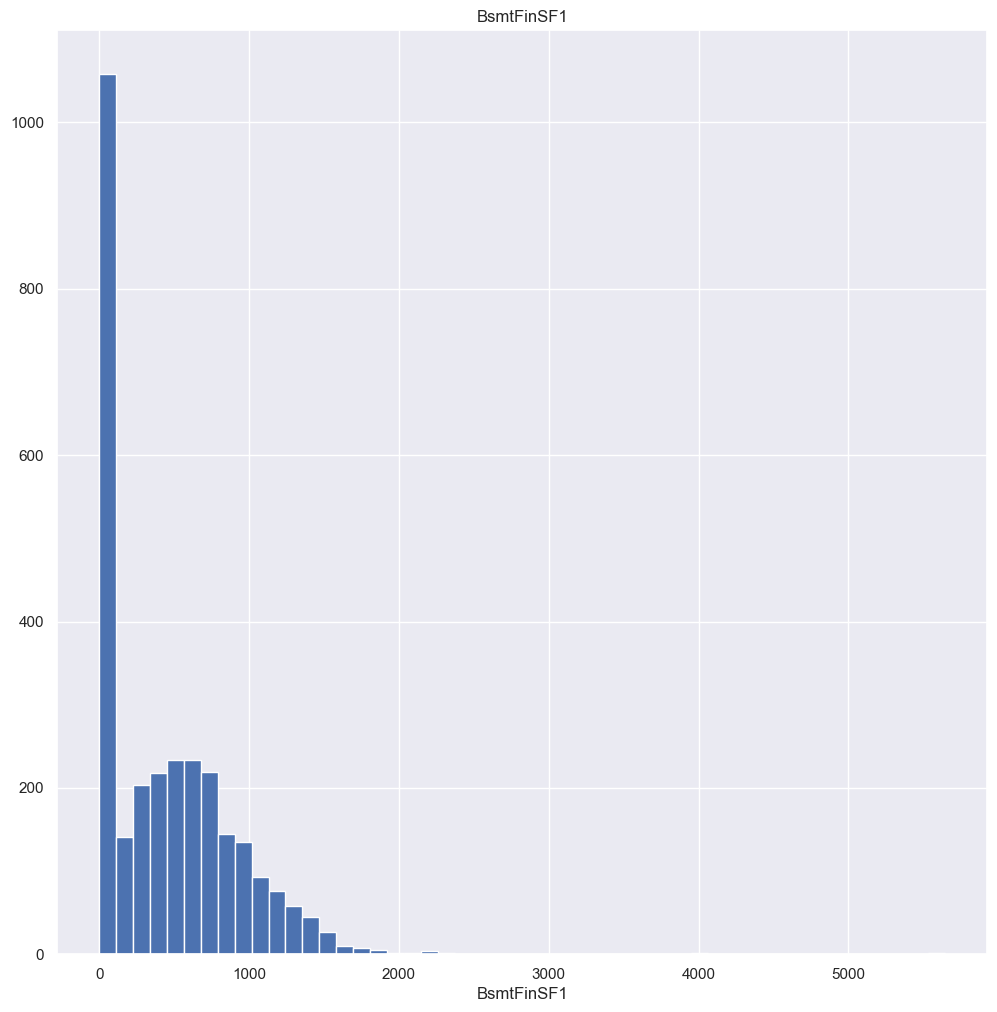




count   2918.00
mean      49.58
std      169.21
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%      125.60
99%      874.66
max     1526.00
Name: BsmtFinSF2, dtype: float64


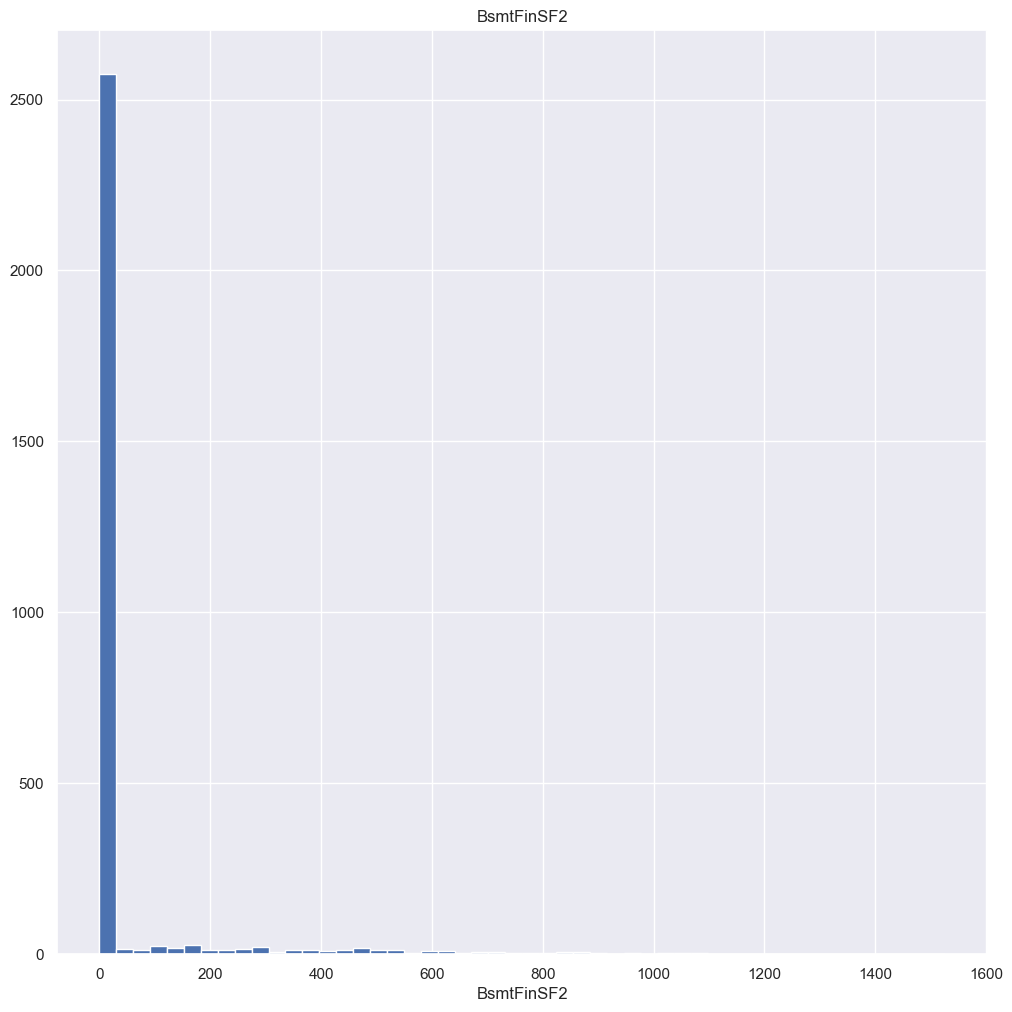




count   2918.00
mean     560.77
std      439.54
min        0.00
5%         0.00
10%       56.00
20%      174.00
30%      270.00
40%      365.80
50%      467.00
60%      595.00
70%      732.00
80%      892.60
90%     1212.60
99%     1776.49
max     2336.00
Name: BsmtUnfSF, dtype: float64


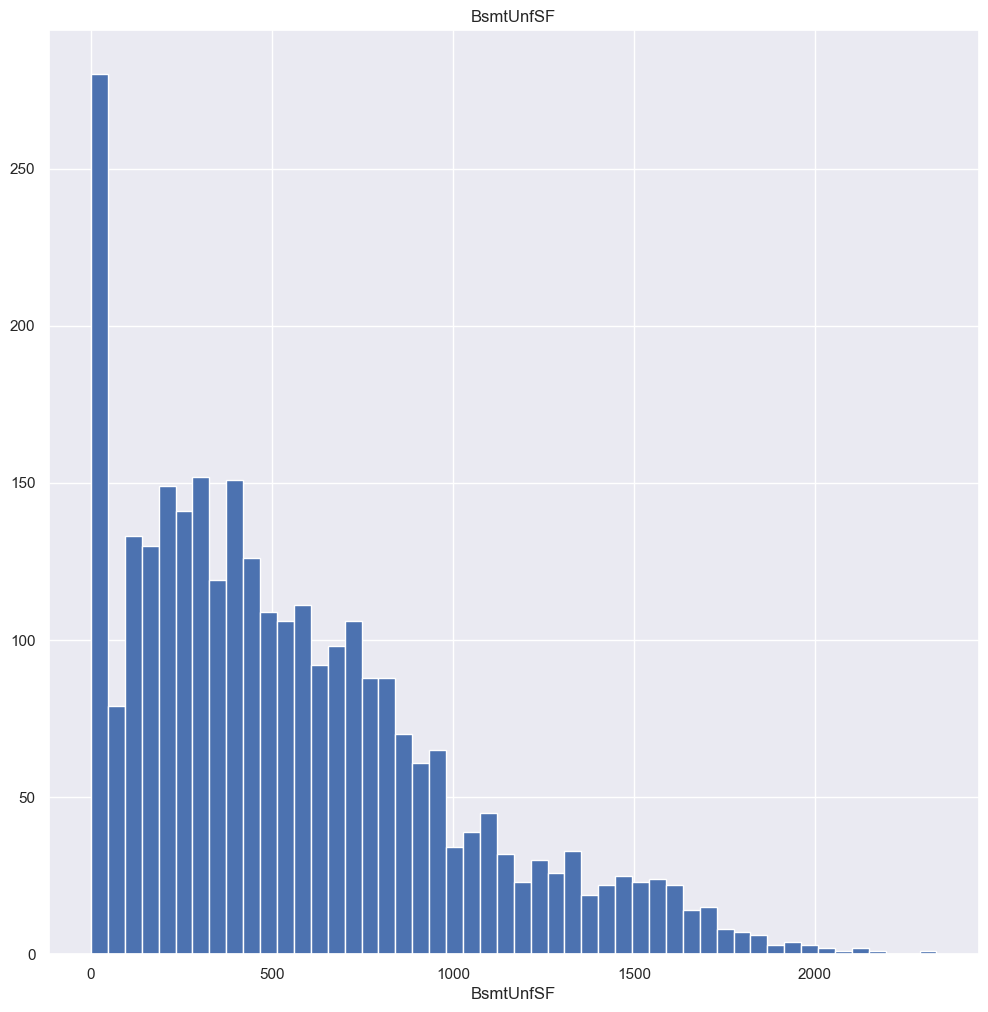




count   2918.00
mean    1051.78
std      440.77
min        0.00
5%       455.25
10%      600.00
20%      741.00
30%      836.00
40%      911.00
50%      989.50
60%     1089.20
70%     1216.00
80%     1392.00
90%     1614.00
99%     2198.30
max     6110.00
Name: TotalBsmtSF, dtype: float64


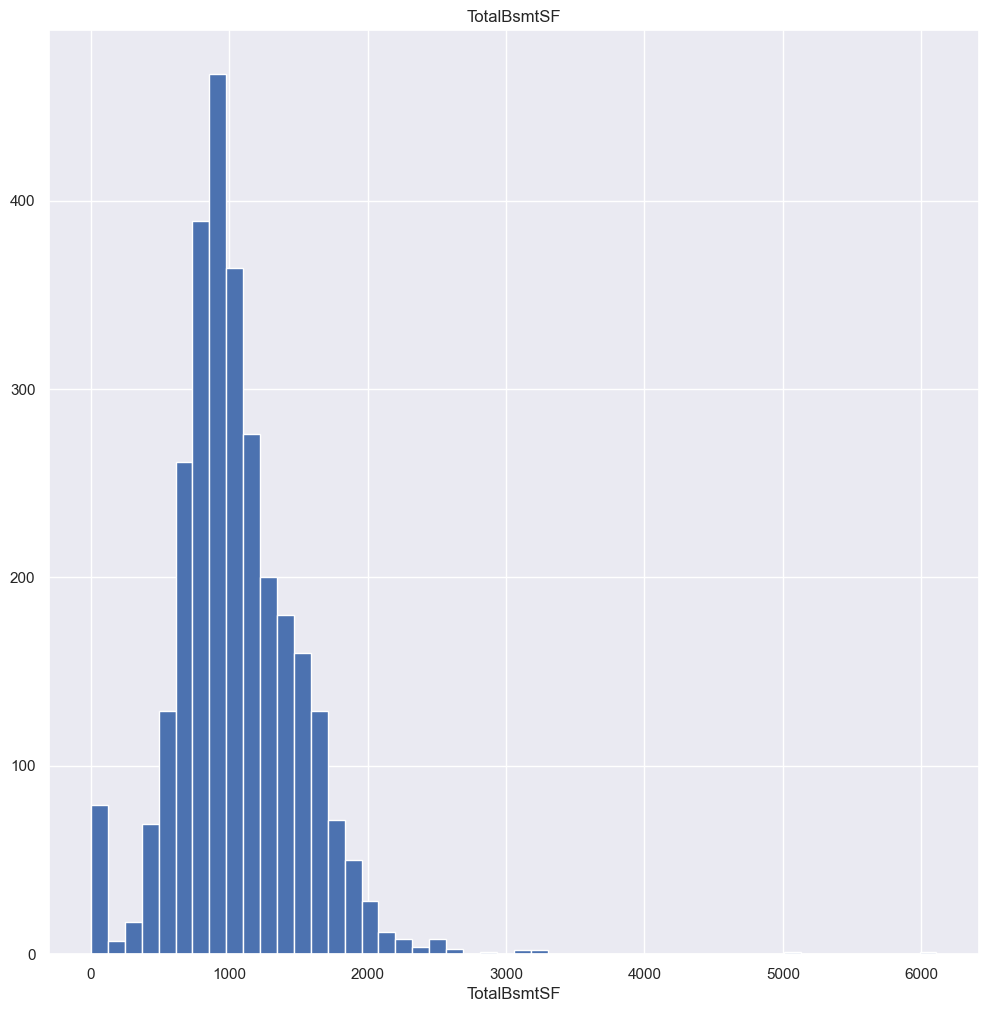




count   2919.00
mean    1159.58
std      392.36
min      334.00
5%       665.90
10%      744.80
20%      847.00
30%      914.00
40%      996.20
50%     1082.00
60%     1180.00
70%     1314.00
80%     1483.40
90%     1675.00
99%     2288.02
max     5095.00
Name: 1stFlrSF, dtype: float64


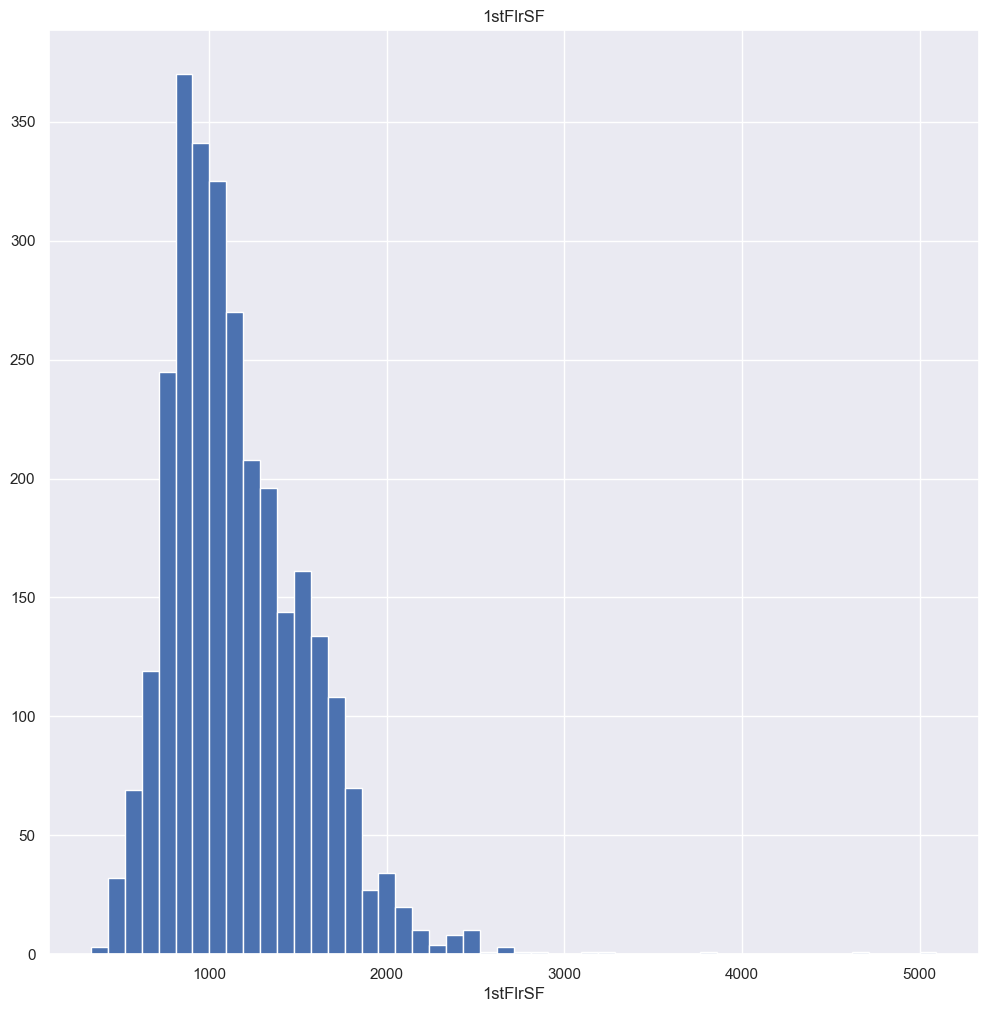




count   2919.00
mean     336.48
std      428.70
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%      427.40
70%      636.00
80%      770.80
90%      925.00
99%     1400.20
max     2065.00
Name: 2ndFlrSF, dtype: float64


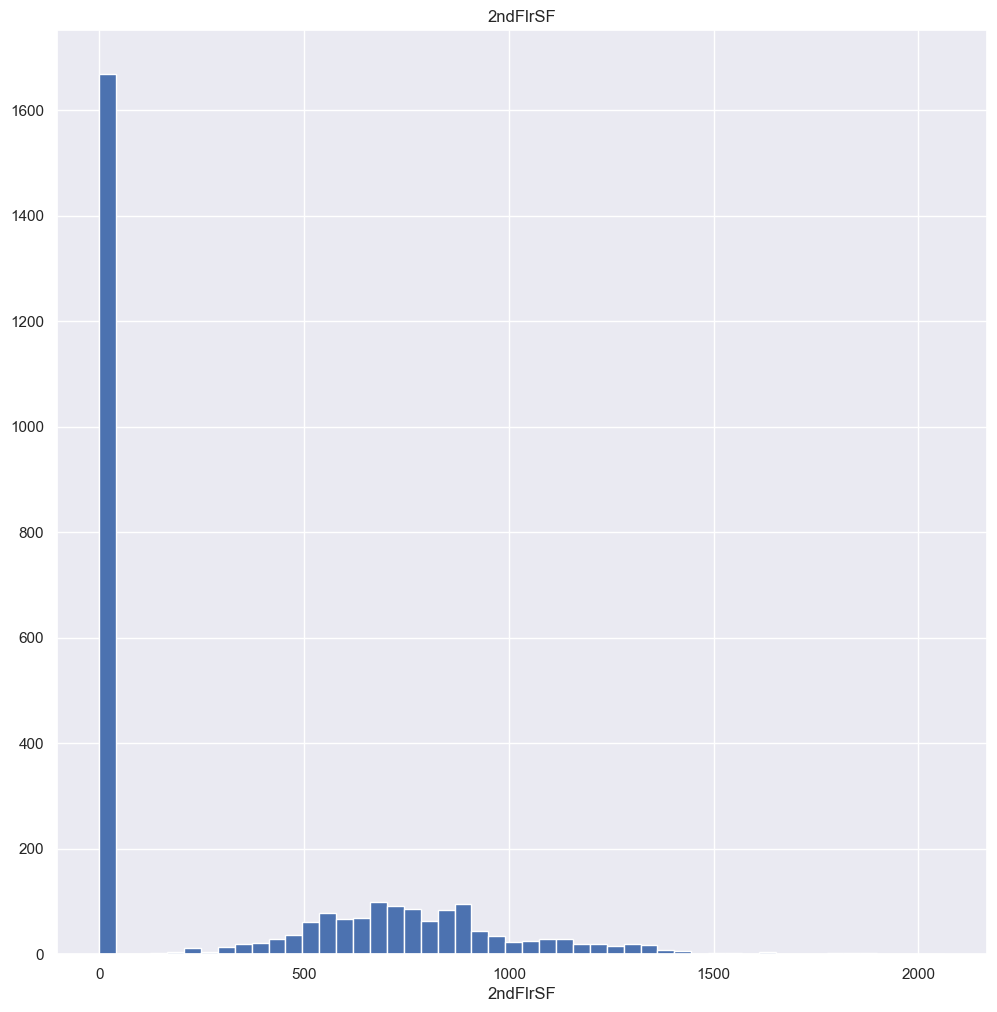




count   2919.00
mean       4.69
std       46.40
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%        0.00
99%      153.84
max     1064.00
Name: LowQualFinSF, dtype: float64


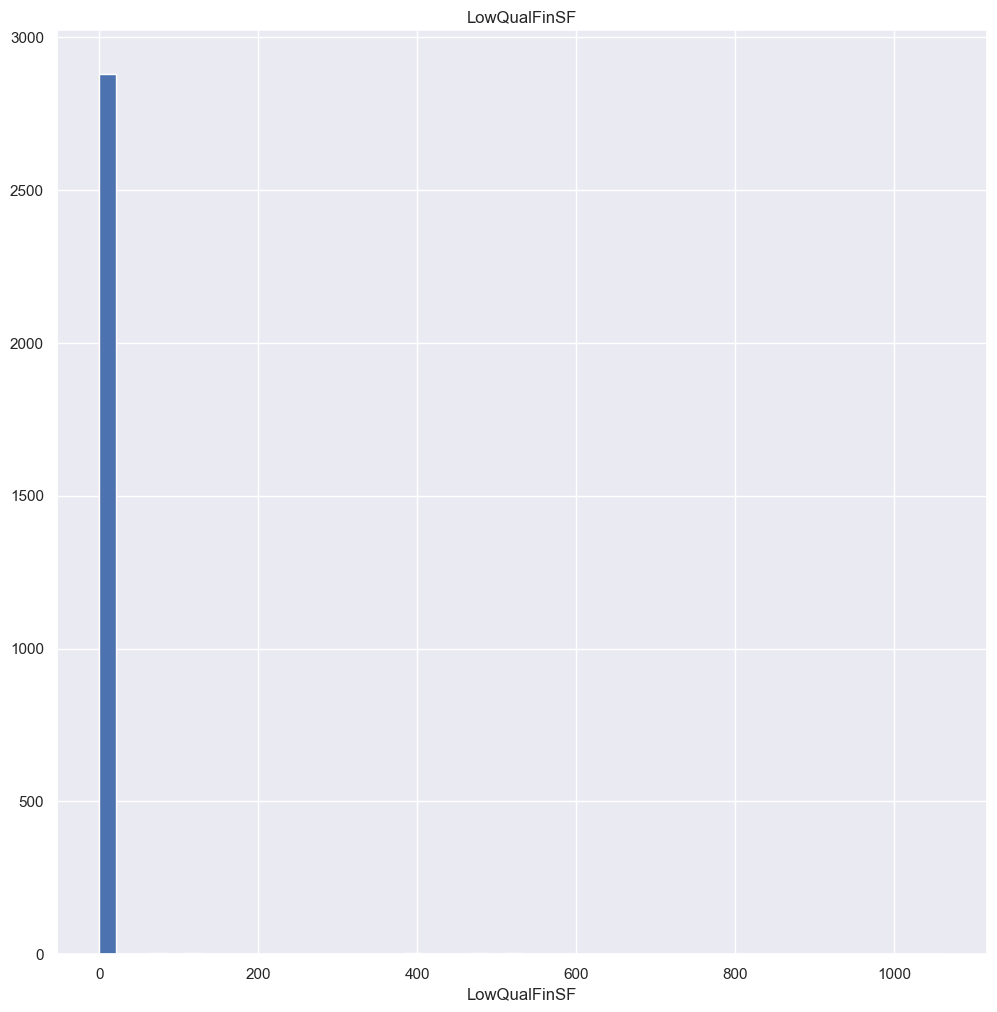




count   2919.00
mean    1500.76
std      506.05
min      334.00
5%       861.00
10%      923.80
20%     1064.60
30%     1200.00
40%     1329.20
50%     1444.00
60%     1560.00
70%     1680.00
80%     1838.40
90%     2153.20
99%     2935.72
max     5642.00
Name: GrLivArea, dtype: float64


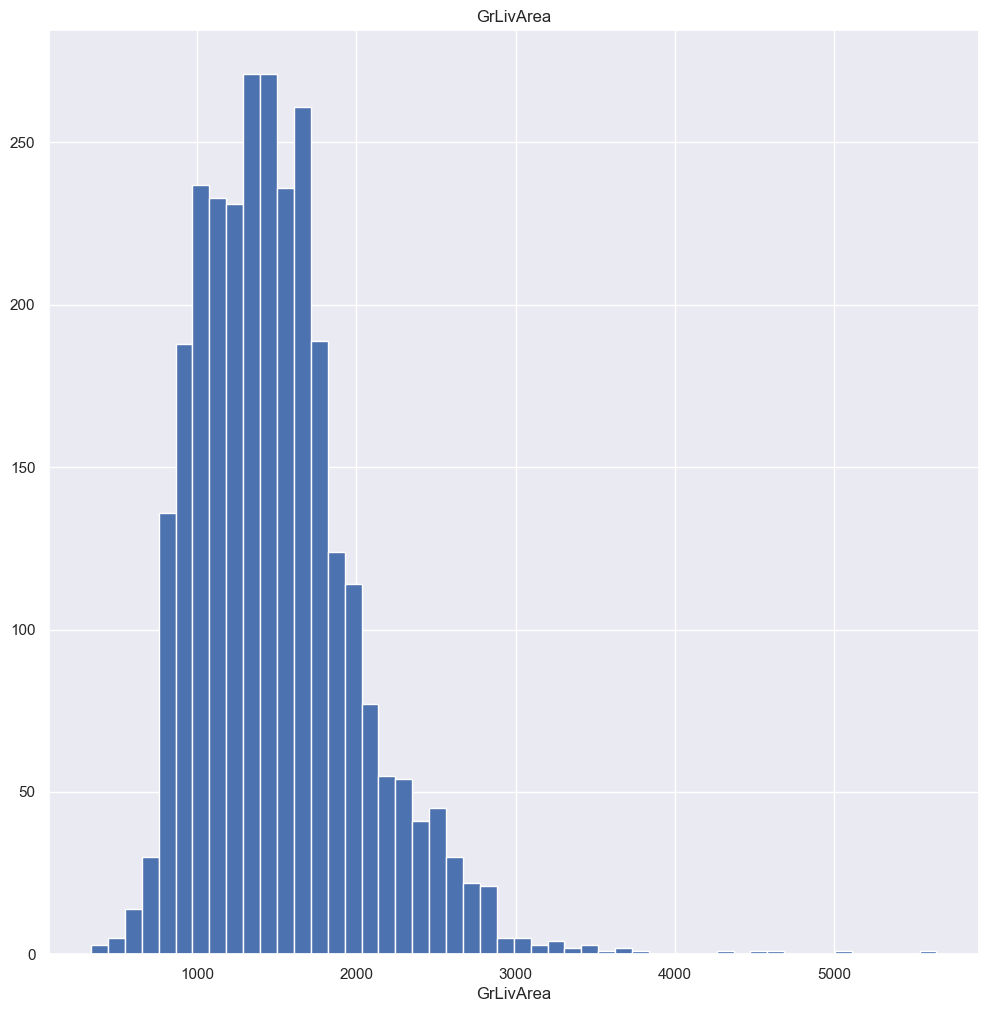




count   2919.00
mean       6.45
std        1.57
min        2.00
5%         4.00
10%        5.00
20%        5.00
30%        6.00
40%        6.00
50%        6.00
60%        7.00
70%        7.00
80%        8.00
90%        8.00
99%       11.00
max       15.00
Name: TotRmsAbvGrd, dtype: float64


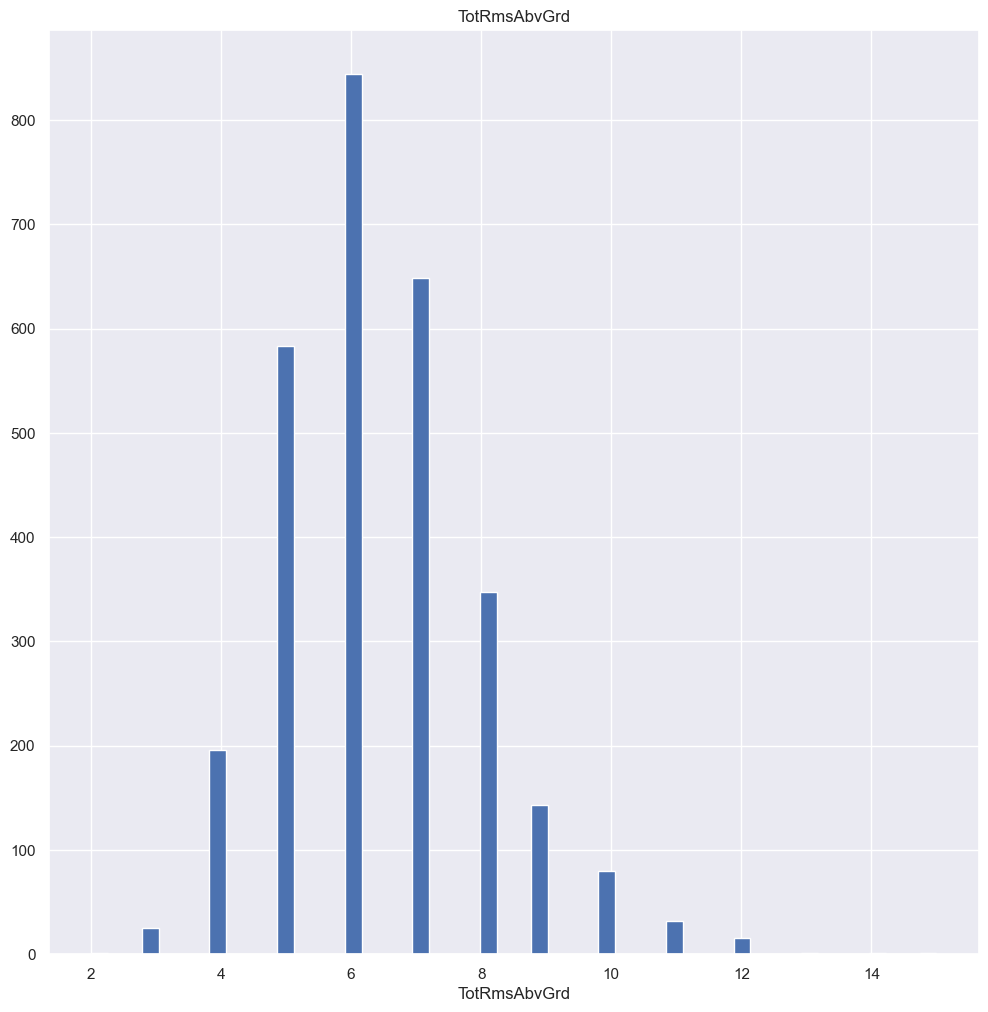




count   2760.00
mean    1978.11
std       25.57
min     1895.00
5%      1928.00
10%     1941.00
20%     1957.00
30%     1964.00
40%     1972.00
50%     1979.00
60%     1993.00
70%     1999.00
80%     2004.00
90%     2006.00
99%     2009.00
max     2207.00
Name: GarageYrBlt, dtype: float64


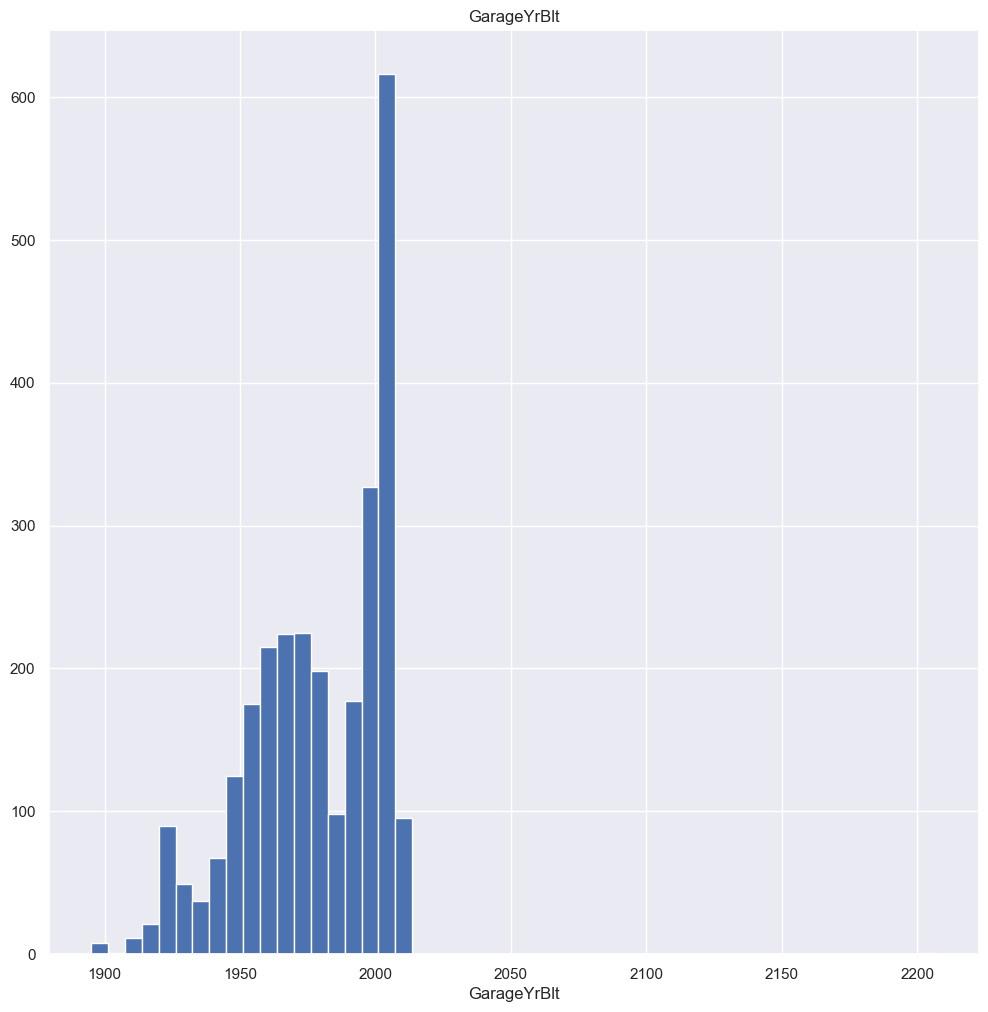




count   2918.00
mean     472.87
std      215.39
min        0.00
5%         0.00
10%      240.00
20%      296.00
30%      379.00
40%      440.00
50%      480.00
60%      513.00
70%      560.90
80%      621.00
90%      758.00
99%     1019.49
max     1488.00
Name: GarageArea, dtype: float64


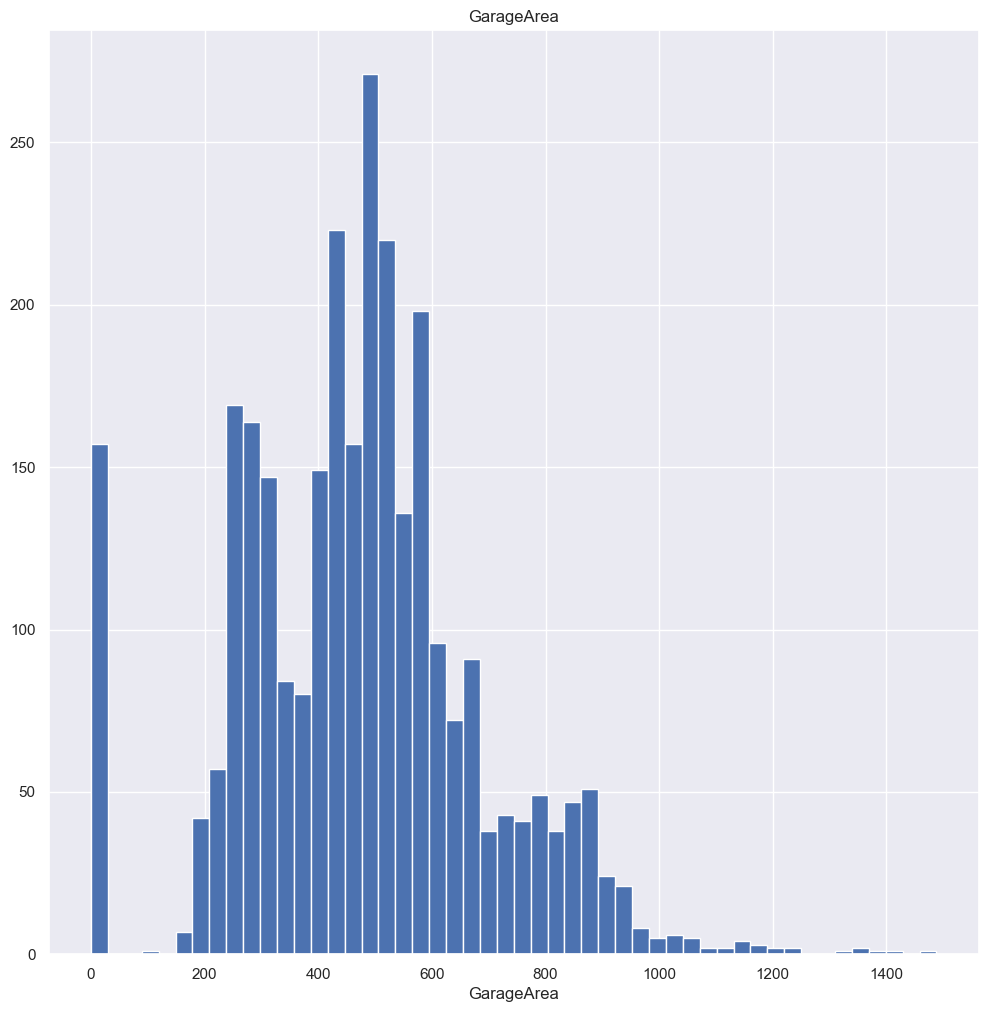




count   2919.00
mean      93.71
std      126.53
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%      100.00
70%      144.00
80%      192.00
90%      257.00
99%      500.82
max     1424.00
Name: WoodDeckSF, dtype: float64


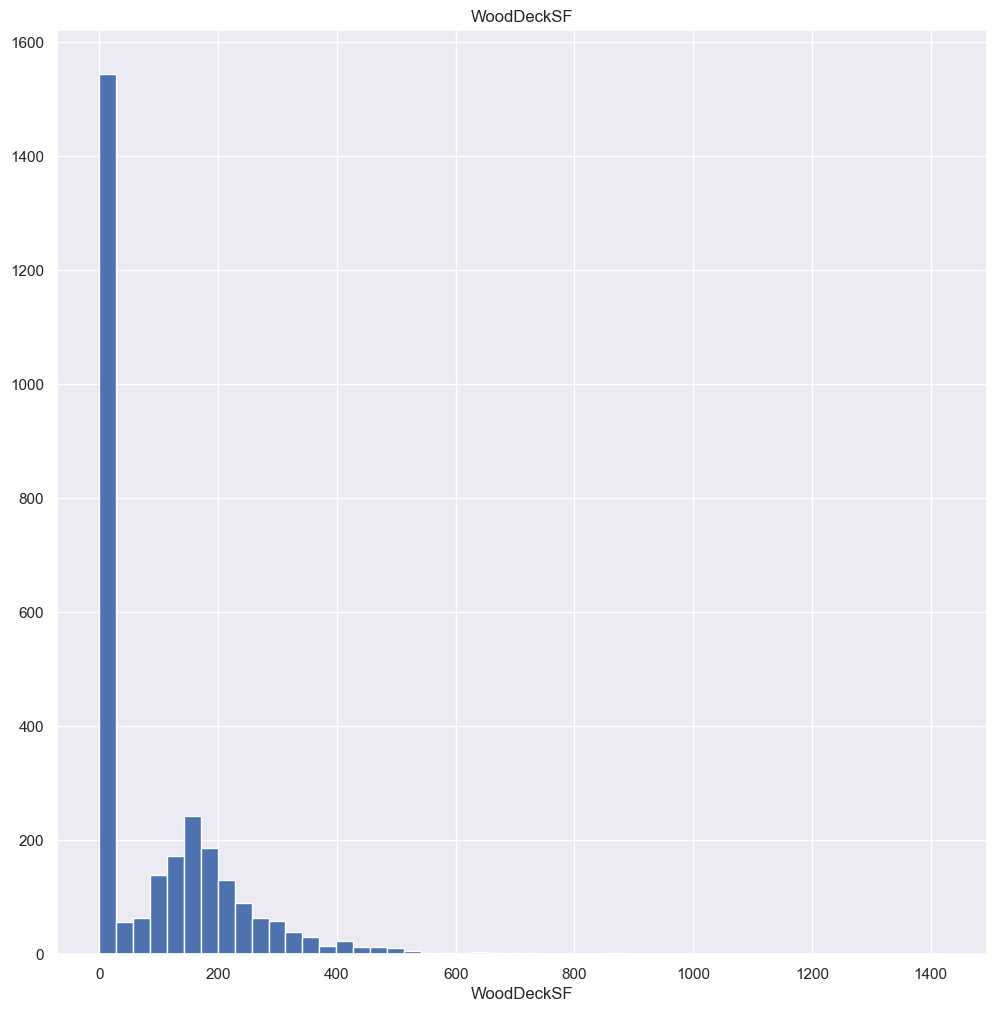




count   2919.00
mean      47.49
std       67.58
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%       26.00
60%       40.00
70%       58.00
80%       85.00
90%      131.20
99%      284.46
max      742.00
Name: OpenPorchSF, dtype: float64


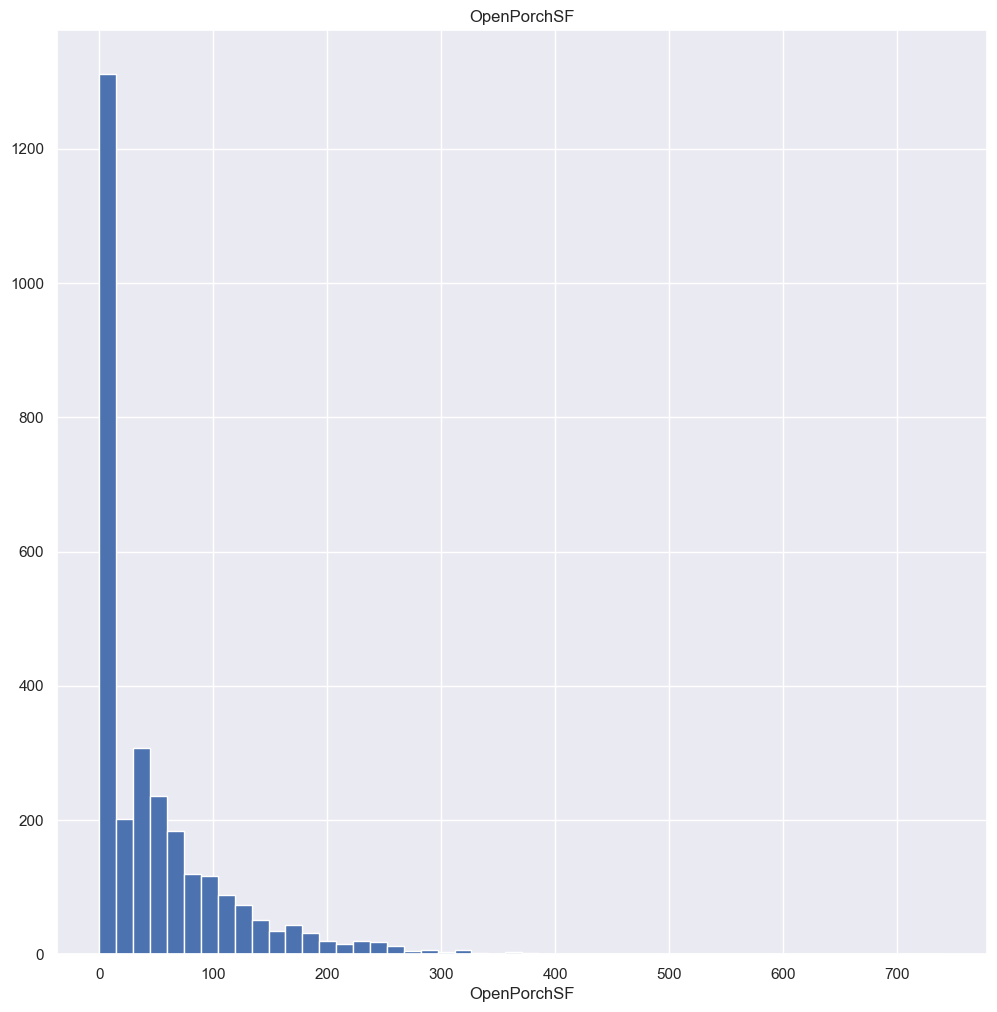




count   2919.00
mean      23.10
std       64.24
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%      112.00
99%      264.00
max     1012.00
Name: EnclosedPorch, dtype: float64


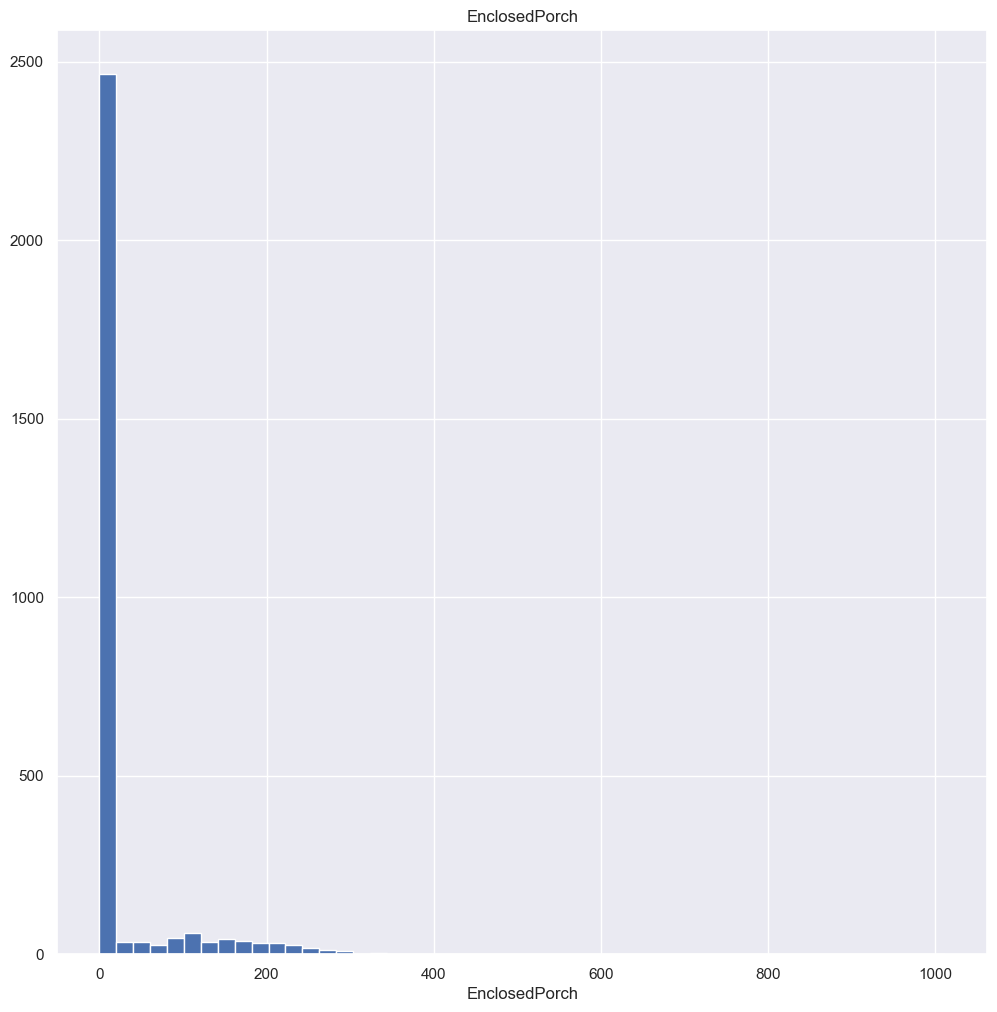




count   2919.00
mean       2.60
std       25.19
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%        0.00
99%      144.00
max      508.00
Name: 3SsnPorch, dtype: float64


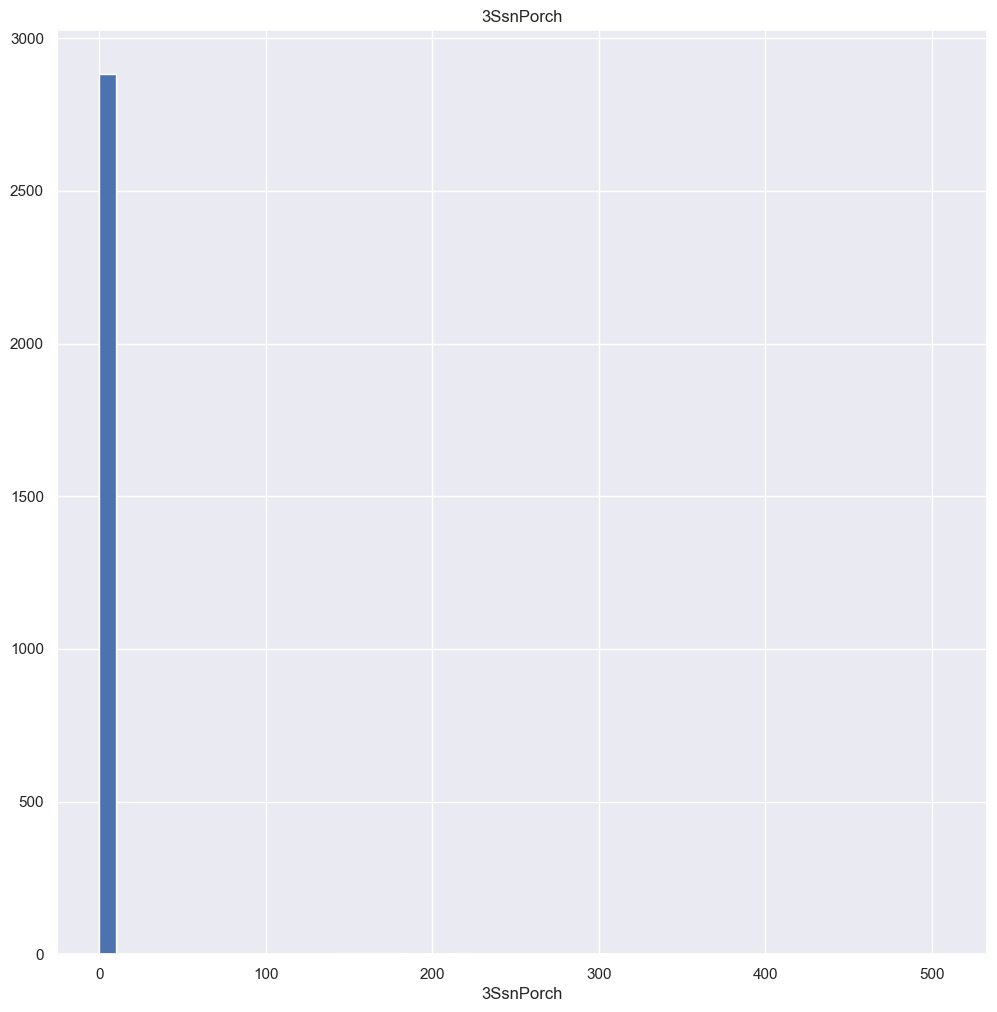




count   2919.00
mean      16.06
std       56.18
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%        0.00
99%      259.82
max      576.00
Name: ScreenPorch, dtype: float64


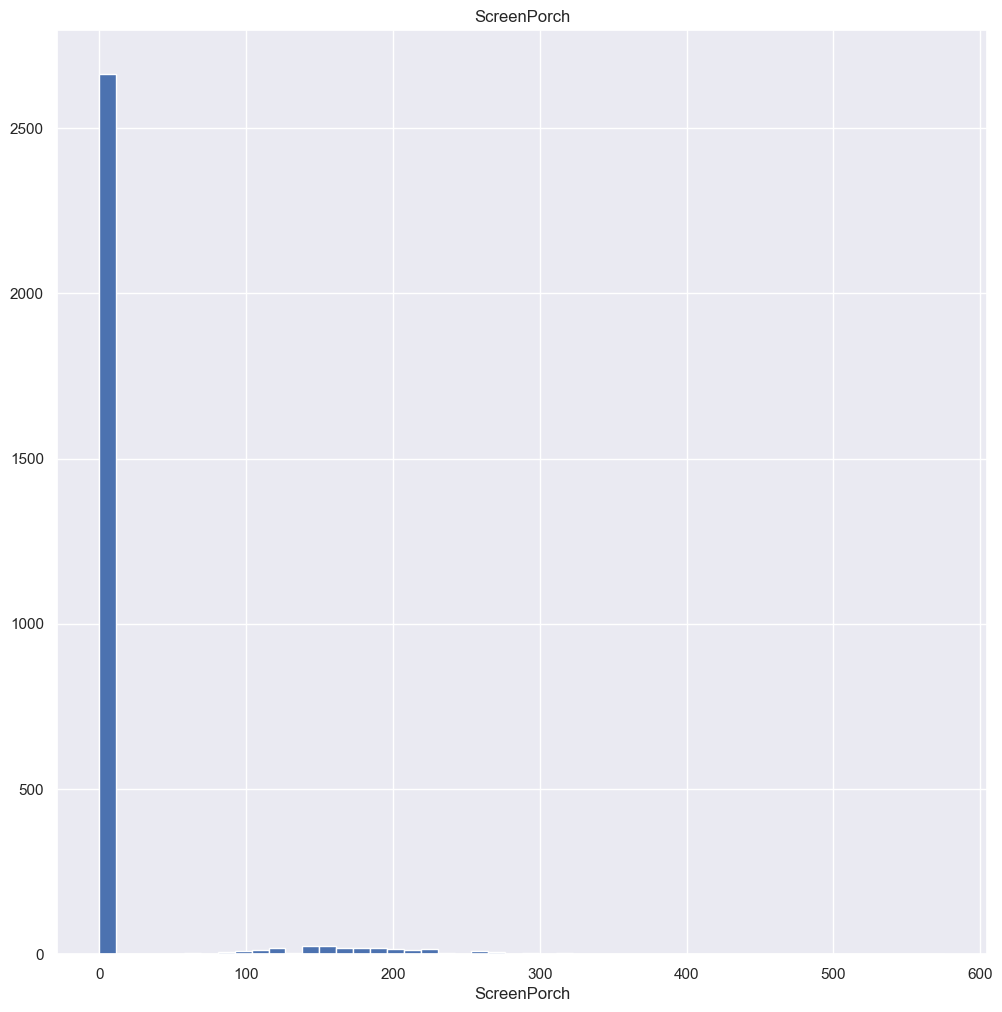




count   2919.00
mean       2.25
std       35.66
min        0.00
5%         0.00
10%        0.00
20%        0.00
30%        0.00
40%        0.00
50%        0.00
60%        0.00
70%        0.00
80%        0.00
90%        0.00
99%        0.00
max      800.00
Name: PoolArea, dtype: float64


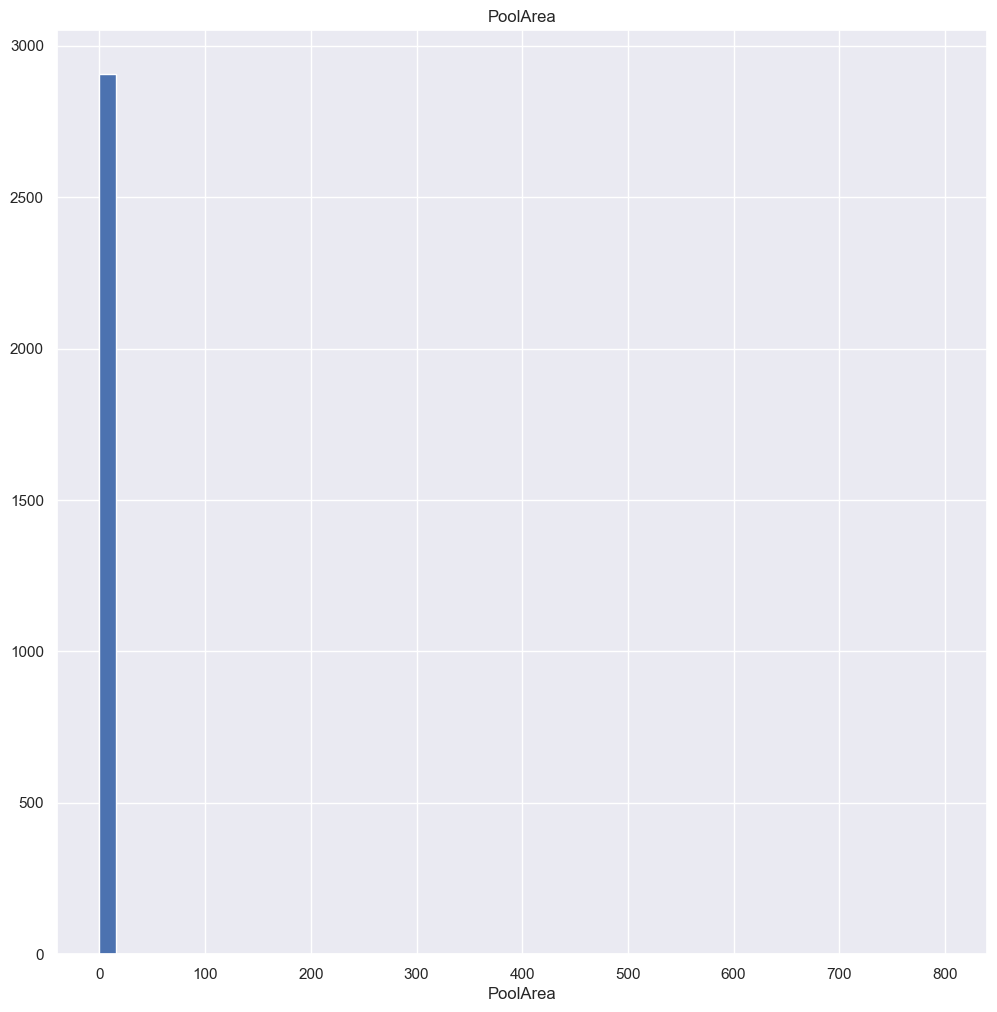




count    2919.00
mean       50.83
std       567.40
min         0.00
5%          0.00
10%         0.00
20%         0.00
30%         0.00
40%         0.00
50%         0.00
60%         0.00
70%         0.00
80%         0.00
90%         0.00
99%       982.00
max     17000.00
Name: MiscVal, dtype: float64


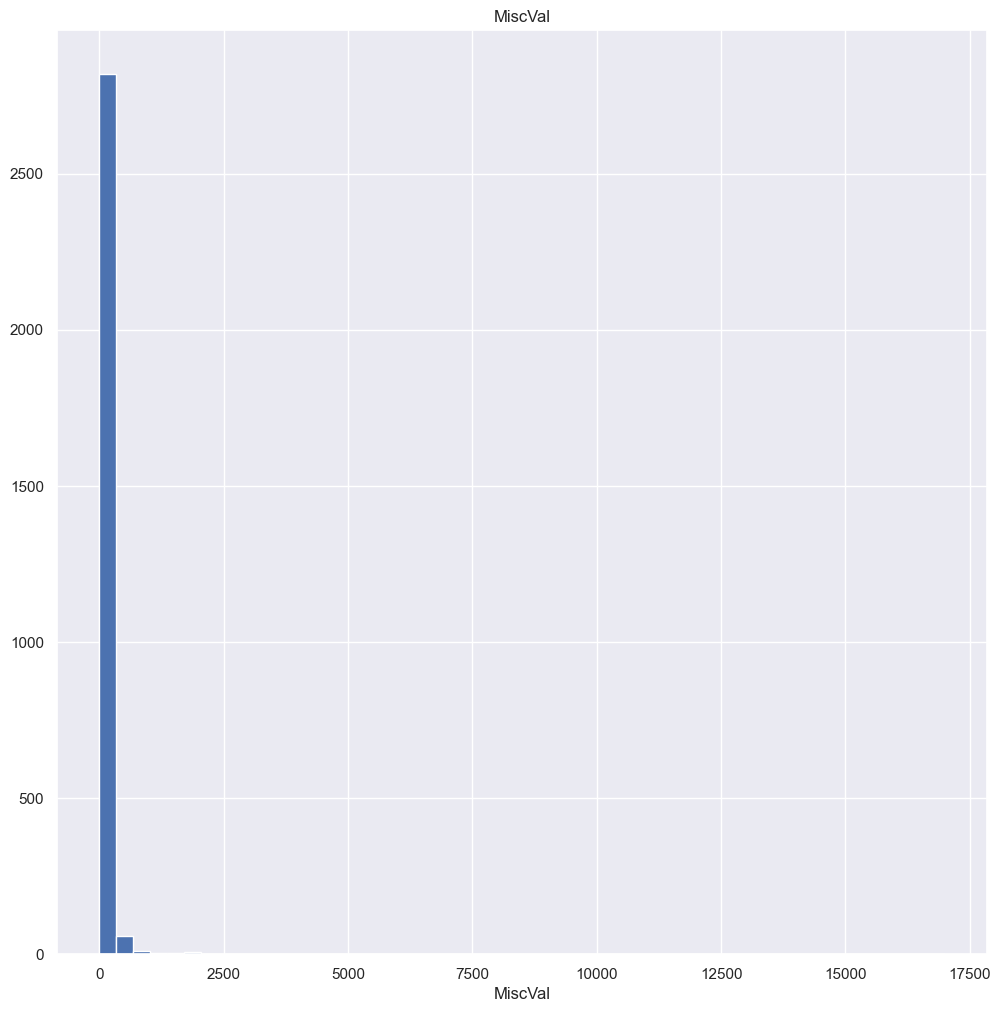




count   2919.00
mean       6.21
std        2.71
min        1.00
5%         2.00
10%        3.00
20%        4.00
30%        5.00
40%        6.00
50%        6.00
60%        7.00
70%        7.00
80%        8.00
90%       10.00
99%       12.00
max       12.00
Name: MoSold, dtype: float64


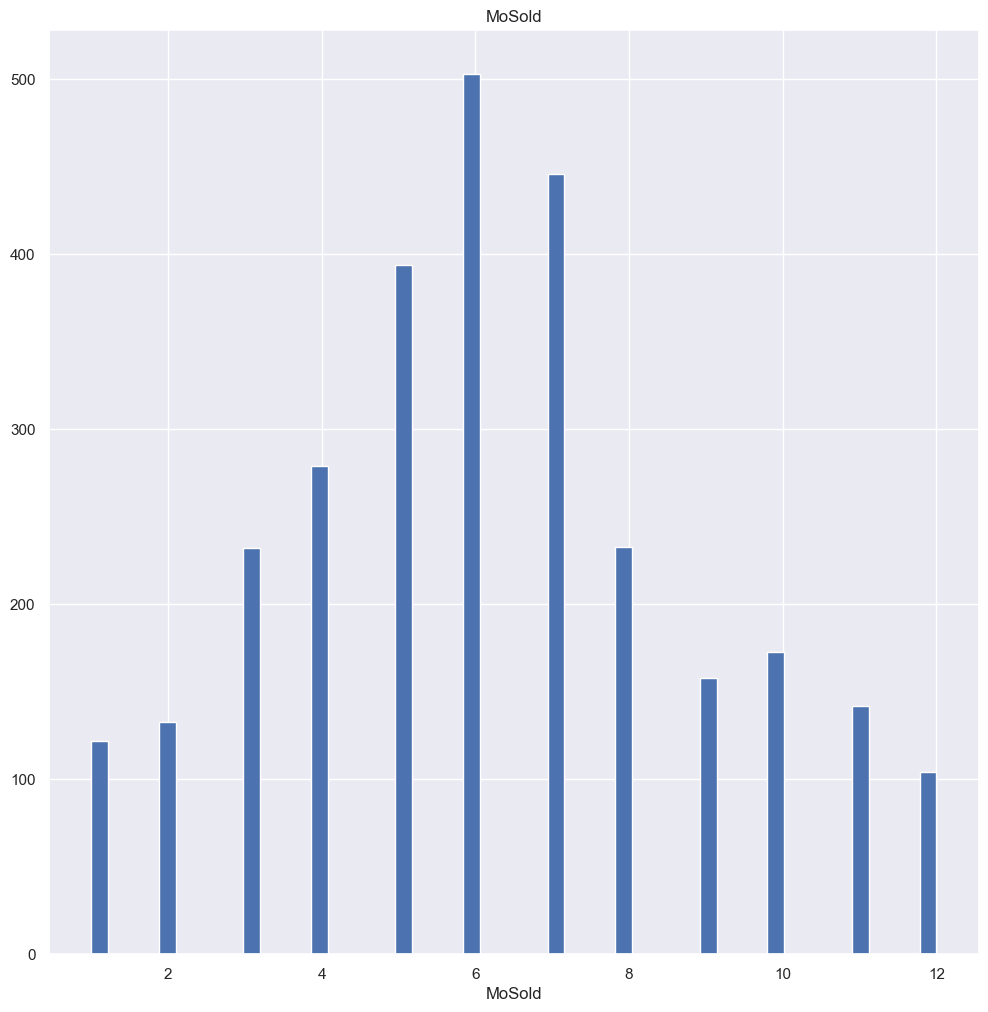




count     1460.00
mean    180921.20
std      79442.50
min      34900.00
5%       88000.00
10%     106475.00
20%     124000.00
30%     135500.00
40%     147000.00
50%     163000.00
60%     179280.00
70%     198620.00
80%     230000.00
90%     278000.00
99%     442567.01
max     755000.00
Name: SalePrice, dtype: float64


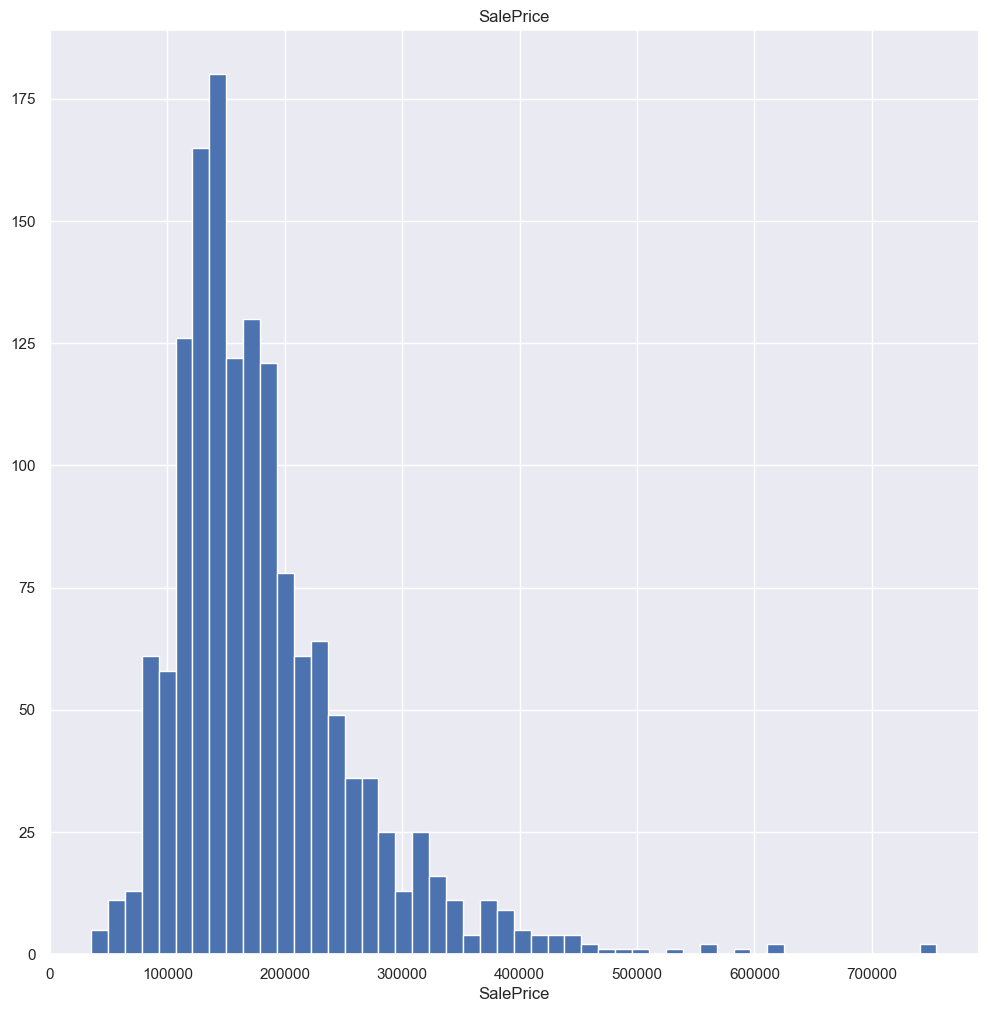

In [595]:
for col in num_cols:
    num_summary(df,col)

**6 - Hedef Değişken Analizi**

In [597]:
def target_summary_with_cat(data, target, cat_cols):
    print(pd.DataFrame({'Target_Mean': data.groupby(cat_cols)[target].mean()}), end='\n\n\n')

In [598]:
for col in cat_cols:
    target_summary_with_cat(df,'SalePrice',col)

          Target_Mean
MSZoning             
C (all)      74528.00
FV          214014.06
RH          131558.38
RL          191004.99
RM          126316.83


        Target_Mean
Street             
Grvl      130190.50
Pave      181130.54


       Target_Mean
Alley             
Grvl     122219.08
Pave     168000.59


          Target_Mean
LotShape             
IR1         206101.67
IR2         239833.37
IR3         216036.50
Reg         164754.82


             Target_Mean
LandContour             
Bnk            143104.08
HLS            231533.94
Low            203661.11
Lvl            180183.75


           Target_Mean
Utilities             
AllPub       180950.96
NoSeWa       137500.00


           Target_Mean
LotConfig             
Corner       181623.43
CulDSac      223854.62
FR2          177934.57
FR3          208475.00
Inside       176938.05


           Target_Mean
LandSlope             
Gtl          179956.80
Mod          196734.14
Sev          204379.23


            Target_Mean


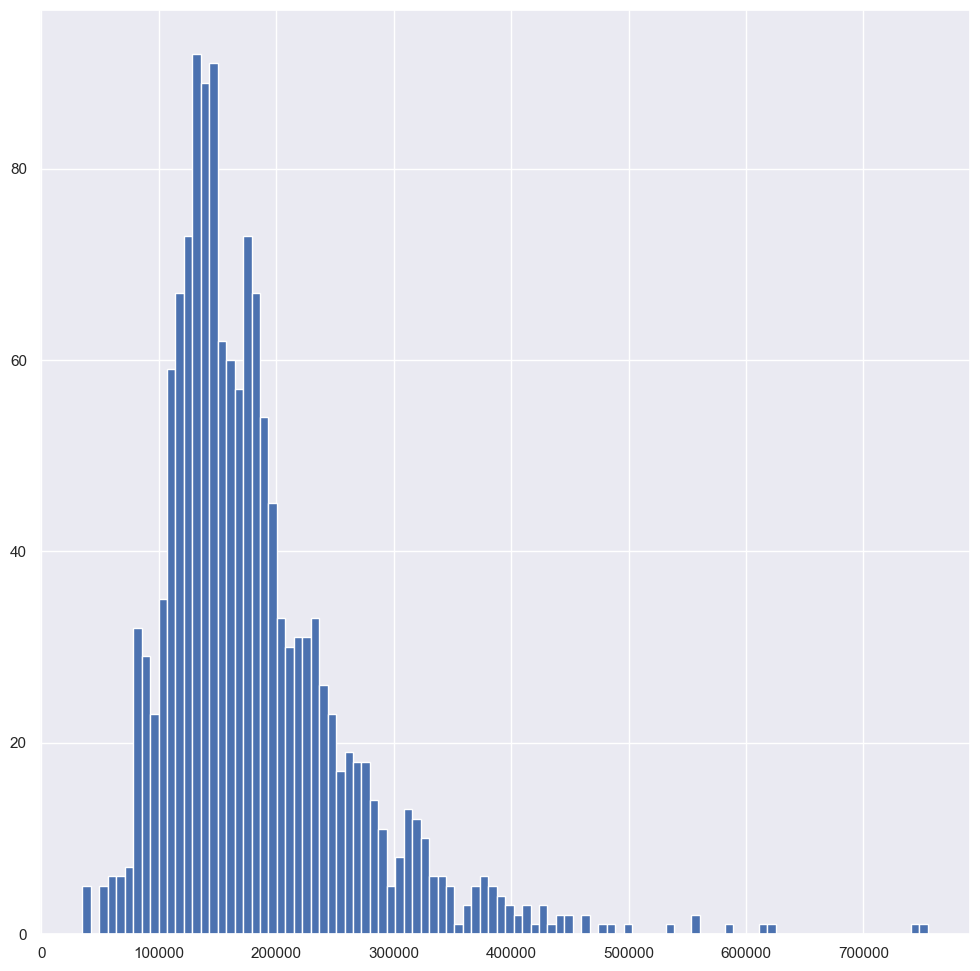

In [599]:
# Bağımlı değişkenin grafik üzerinden incelenmesi
# Grafikten çıkan sonuca bakıldığında 100 bin ile 200 bin arası en çok veri bulunduğunu söyleyebiliriz.

df['SalePrice'].hist(bins=100)
plt.show()

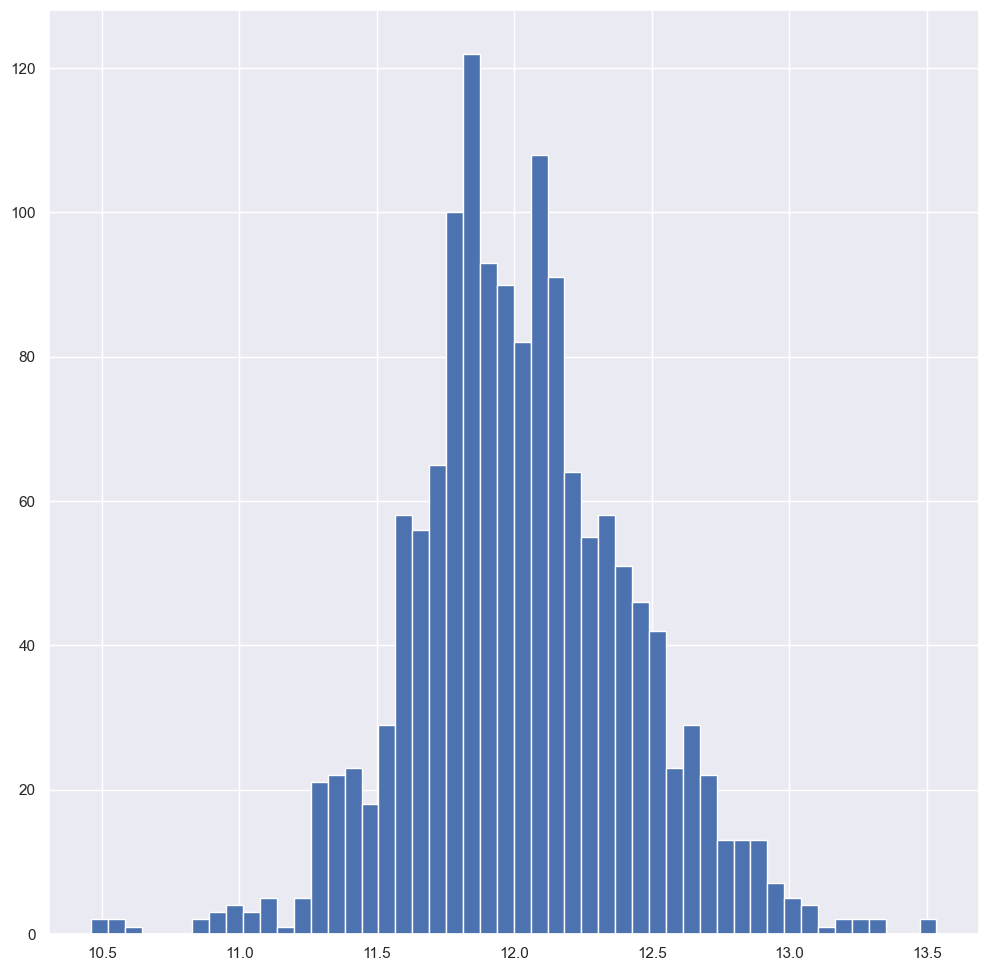

In [600]:
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

**7- Korelasyon Analizi**

In [602]:
corr = df[num_cols].corr()
corr

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
MSSubClass,1.00,-0.42,-0.20,0.03,0.03,0.04,0.01,-0.06,-0.07,-0.13,...,-0.10,-0.02,-0.02,-0.02,-0.04,-0.05,-0.00,-0.03,-0.00,-0.08
LotFrontage,-0.42,1.00,0.49,0.22,0.12,0.09,0.22,0.22,0.05,0.11,...,0.36,0.12,0.16,0.01,0.03,0.08,0.17,0.04,0.01,0.35
LotArea,-0.20,0.49,1.00,0.10,0.02,0.02,0.13,0.19,0.08,0.02,...,0.21,0.16,0.10,0.02,0.02,0.05,0.09,0.07,0.00,0.26
OverallQual,0.03,0.22,0.10,1.00,0.60,0.57,0.43,0.28,-0.04,0.28,...,0.57,0.26,0.30,-0.14,0.02,0.04,0.03,0.01,0.03,0.79
YearBuilt,0.03,0.12,0.02,0.60,1.00,0.61,0.31,0.28,-0.03,0.13,...,0.48,0.23,0.20,-0.37,0.02,-0.04,0.00,-0.01,0.01,0.52
YearRemodAdd,0.04,0.09,0.02,0.57,0.61,1.00,0.20,0.15,-0.06,0.17,...,0.38,0.22,0.24,-0.22,0.04,-0.05,-0.01,-0.00,0.02,0.51
MasVnrArea,0.01,0.22,0.13,0.43,0.31,0.20,1.00,0.30,-0.02,0.09,...,0.37,0.17,0.14,-0.11,0.01,0.07,0.00,0.04,-0.00,0.48
BsmtFinSF1,-0.06,0.22,0.19,0.28,0.28,0.15,0.30,1.00,-0.06,-0.48,...,0.31,0.22,0.12,-0.10,0.05,0.10,0.08,0.09,-0.00,0.39
BsmtFinSF2,-0.07,0.05,0.08,-0.04,-0.03,-0.06,-0.02,-0.06,1.00,-0.24,...,0.00,0.10,-0.01,0.03,-0.02,0.06,0.04,-0.01,-0.01,-0.01
BsmtUnfSF,-0.13,0.11,0.02,0.28,0.13,0.17,0.09,-0.48,-0.24,1.00,...,0.16,-0.04,0.12,0.01,-0.01,-0.05,-0.03,-0.01,0.02,0.21


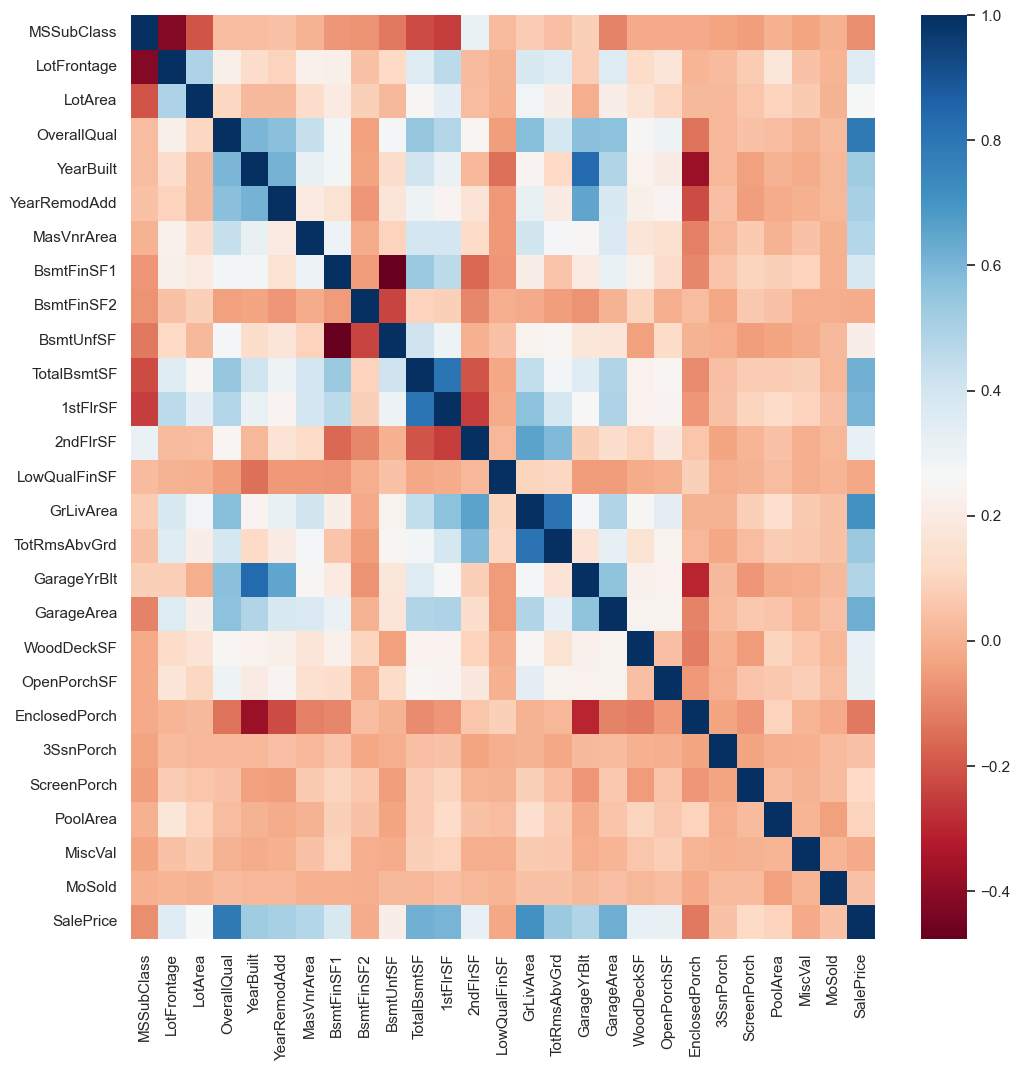

In [603]:
sns.heatmap(corr, cmap='RdBu')
plt.show(block=True)

**8 - Özellik Mühendisliği**

**8.1 - Aykırı Değerler**

In [606]:
# Aykırı değerlerin tresholdlarının belirlenmesi

def outliers_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    q1 = dataframe[col_name].quantile(q1)
    q3 = dataframe[col_name].quantile(q3)
    IQR = q3-q1
    up_limit= q3 + 1.5 * IQR
    low_limit = q1 - 1.5 * IQR
    return up_limit,low_limit

In [607]:
# Aykırı değer var mı yok mu tespiti

def check_outlier(dataframe, col_name):
    up_limit, low_limit = outliers_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [608]:
# Aykırı değerlerin alt limit ve üst limite eşitlenerek baskılanması

def replace_with_thresholds(dataframe, variable):
    up_limit,low_limit = outliers_thresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable]  < low_limit),variable] = low_limit 
    dataframe.loc[(dataframe[variable]  > up_limit),variable] = up_limit 

In [610]:
for col in num_cols:
    if col != 'SalesPrice':
        print(col, check_outlier(df, col))

MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd False
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False
SalePrice True


In [792]:
# Burada if col != 'SalesPrice' dememizin sebebi, tahmin edeceğimiz değişken üzerinde bir işlem yapılmamasını istediğimizi söylüyoruz.

for col in num_cols:
    if col != 'SalesPrice':
        replace_with_thresholds(df,col)

In [794]:
for col in num_cols:
    if col != 'SalesPrice':
        print(col, check_outlier(df, col))

MSSubClass False
LotFrontage False
LotArea False
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
MoSold False
SalePrice False


**8.2 - Eksik Değer analizi**

In [629]:
def missing_value_table(data, na_name=False):

    # dataframe in kolonlarında gez, boş değerlerinin toplamı 0 dan büyük olan varsa onları al
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0] 

    # Aldığın boş değerleri en çok boş değer olandan en düşüğe doğru sırala
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)

    # boş değerlerin toplamını datanın gözlem sayısına böl ve 100 ile çarp burada yüzdelik durumu sorguluyoruz.
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=['n_miss','ratio'])

    print(missing_df, end='\n\n')

    if na_name:
        return na_columns

In [631]:
missing_value_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [633]:
# Verisetinde boş olan değerler, evin o özelliklere sahip olmadığını ifade ettiği için boş olan yerleri NO yazarak dolduracağız.
# O nedenle na_cols adlı bir değişken oluşurup bu değişkenlere boş olan değerlere sahip olan değişkenleri seçeceğim.

na_cols = ['Alley','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType1','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
          'PoolQC','Fence','MiscFeature']

In [635]:
for col in na_cols:
    df[col].fillna('No', inplace=True)

In [637]:
# Bu değerleri doldurduktan sonra tekrar kontrol ediyoruz.
# Görüleceği gibi eksik değerlerde azalma oldu

missing_value_table(df)

              n_miss  ratio
MasVnrType      1766  60.50
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
BsmtCond          82   2.81
BsmtFinType2      80   2.74
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
BsmtFinSF2         1   0.03
Exterior1st        1   0.03
TotalBsmtSF        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
BsmtUnfSF          1   0.03



In [639]:
# Bu fonksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar

def quick_missing_imp(data, num_method='median', cat_lenght=20, target='SalePrice'):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() >0] # eksik değerleri listeliyoruz.

    temp_target = data[target]

    print('# Before')
    print(data[col].isnull().sum(), '\n\n') # uygulama öncesi eksik değerlerin durumu

    # değişken object ve sınıf sayısı cat_lenght e eşit veya altındaysa boş değerleri mode ile doldur.
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == 'O' and len(x.unique()) <= cat_lenght) else x, axis=0)

    # num_method mean ise tipi object olmayan değerlerin boş değerlerini ortalama ile doldur
    if num_method =='mean':
        data = data.apply(lambda x : x.fillna(x.mean()) if x.dtype != 'O' else x, axis=0)

    # num_method median ise tipi object olmayan değerlerin boş değerlerini ortalama ile doldur
    elif num_method == 'median':
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != 'O' else x, axis=0)

    data[target] = temp_target

    print('# After \n Imputation method is "Mode" for categorical variables!')
    print('Imputation method is ' + num_method.upper() + 'for numerical variables! \n')
    print(data[variables_with_na].isnull().sum(), '\n\n')

    return data

In [641]:
df= quick_missing_imp(df, num_method='median', cat_lenght=17)

# Before
0 


# After 
 Imputation method is "Mode" for categorical variables!
Imputation method is MEDIANfor numerical variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtCond           0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType           0
SalePrice       1459
dtype: int64 




**9 - RARE Encoding**

In [644]:
# Kategorik kolonların dağılımının incelenmesi

def rare_analyser(data, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(data[col].value_counts()))
        print(pd.DataFrame({'Count': data[col].value_counts(),
                           'Ratio': data[col].value_counts() / len(data),
                           'Target_Mean': data.groupby(col)[target].mean()}), end = '\n\n\n')

In [646]:
rare_analyser(df, 'SalePrice',cat_cols)

MSZoning : 5
          Count  Ratio  Target_Mean
MSZoning                           
C (all)      25   0.01     74528.00
FV          139   0.05    214014.06
RH           26   0.01    131558.38
RL         2269   0.78    190889.01
RM          460   0.16    126316.83


Street : 2
        Count  Ratio  Target_Mean
Street                           
Grvl       12   0.00    130190.50
Pave     2907   1.00    181038.72


Alley : 3
       Count  Ratio  Target_Mean
Alley                           
Grvl     120   0.04    122219.08
No      2721   0.93    183354.62
Pave      78   0.03    168000.59


LotShape : 4
          Count  Ratio  Target_Mean
LotShape                           
IR1         968   0.33    205825.84
IR2          76   0.03    239833.37
IR3          16   0.01    216036.50
Reg        1859   0.64    164754.82


LandContour : 4
             Count  Ratio  Target_Mean
LandContour                           
Bnk            117   0.04    143104.08
HLS            120   0.04    231533.94
Low 

In [648]:
# Nadir sınıfların tespit edilmesi

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [650]:
rare_encoder(df,0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450.00,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2.00,2008,WD,Normal,208500.00
1,2,20,RL,80.00,9600.00,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5.00,2007,WD,Normal,181500.00
2,3,60,RL,68.00,11250.00,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9.00,2008,WD,Normal,223500.00
3,4,70,RL,60.00,9550.00,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2.00,2006,WD,Abnorml,140000.00
4,5,60,RL,84.00,14260.00,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12.00,2008,WD,Normal,250000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.00,1936.00,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,6.00,2006,WD,Normal,NaN
2915,2916,160,RM,21.00,1894.00,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4.00,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.00,20000.00,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,9.00,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.00,10441.00,Pave,No,Reg,Lvl,AllPub,...,0,No,MnPrv,Shed,0,7.00,2006,WD,Normal,NaN


**11 - Extraction of New Features**

In [653]:
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])

# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48


drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [655]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Condition1,Condition2,BldgType,...,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1,60,RL,65.00,8450.00,Reg,Inside,Norm,Norm,1Fam,...,0.06,0.08,6985.00,35,0.00,5,5.00,0.00,0.00,5.00
1,2,20,RL,80.00,9600.00,Reg,FR2,Feedr,Norm,1Fam,...,0.05,0.00,7282.00,48,0.00,31,31.00,0.00,0.00,31.00
2,3,60,RL,68.00,11250.00,IR1,Inside,Norm,Norm,1Fam,...,0.05,0.06,9680.00,35,1.00,7,6.00,0.00,1.00,7.00
3,4,70,RL,60.00,9550.00,IR1,Corner,Norm,Norm,1Fam,...,0.07,0.00,7640.00,35,55.00,91,36.00,83.00,28.00,8.00
4,5,60,RL,84.00,14260.00,IR1,FR2,Norm,Norm,1Fam,...,0.06,0.10,11811.00,40,0.00,8,8.00,0.00,0.00,8.00


**12 - Label & One Hot Encoder**

In [658]:
def label_encoder(data,binary_col):
    le = LabelEncoder()
    data[binary_col] = le.fit_transform(data[binary_col])
    return data

In [660]:
binary_col = [col for col in df.columns if df[col].dtypes =='O' and len (df[col].unique())==2]
binary_col

['CentralAir']

In [662]:
label_encoder(df, 'CentralAir')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Condition1,Condition2,BldgType,...,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1,60,RL,65.00,8450.00,Reg,Inside,Norm,Norm,1Fam,...,0.06,0.08,6985.00,35,0.00,5,5.00,0.00,0.00,5.00
1,2,20,RL,80.00,9600.00,Reg,FR2,Feedr,Norm,1Fam,...,0.05,0.00,7282.00,48,0.00,31,31.00,0.00,0.00,31.00
2,3,60,RL,68.00,11250.00,IR1,Inside,Norm,Norm,1Fam,...,0.05,0.06,9680.00,35,1.00,7,6.00,0.00,1.00,7.00
3,4,70,RL,60.00,9550.00,IR1,Corner,Norm,Norm,1Fam,...,0.07,0.00,7640.00,35,55.00,91,36.00,83.00,28.00,8.00
4,5,60,RL,84.00,14260.00,IR1,FR2,Norm,Norm,1Fam,...,0.06,0.10,11811.00,40,0.00,8,8.00,0.00,0.00,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.00,1936.00,Reg,Inside,Norm,Norm,Twnhs,...,0.00,0.00,1390.00,28,0.00,36,36.00,9.00,9.00,27.00
2915,2916,160,RM,21.00,1894.00,Reg,Inside,Norm,Norm,TwnhsE,...,0.15,0.00,1038.00,20,0.00,36,36.00,0.00,0.00,36.00
2916,2917,20,RL,160.00,20000.00,Reg,Inside,Norm,Norm,1Fam,...,0.03,0.00,17252.00,35,36.00,46,10.00,0.00,36.00,46.00
2917,2918,85,RL,62.00,10441.00,Reg,Inside,Norm,Norm,1Fam,...,0.00,0.00,9279.00,25,0.00,14,14.00,-13.00,13.00,27.00


In [664]:
df['CentralAir'].value_counts()

CentralAir
1    2723
0     196
Name: count, dtype: int64

In [680]:
def one_hot_encoder(data, cat_cols, drop_first=False):
    data = pd.get_dummies(data, columns=cat_cols, drop_first=drop_first)
    return data

In [682]:
ohe_cols = [col for col in df.columns if df[col].dtypes == 'O' and len(df[col].unique()) > 2]
ohe_cols

['MSZoning',
 'LotShape',
 'LotConfig',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [684]:
df = one_hot_encoder(df,ohe_cols,drop_first=True)

In [707]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 231 entries, Id to SaleCondition_Partial
dtypes: float64(38), int32(174), int64(19)
memory usage: 3.2 MB


In [709]:
# Boolean olan sütunların integera çevirilmesi

bool_cols = df.select_dtypes(include='bool').columns

In [711]:
df[bool_cols] = df[bool_cols].astype(int)

**13 - Modeling**

In [715]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [717]:
x = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [719]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=17)

In [733]:
# En iyi sonuç veren modeli seçmek için verimizi tüm modellerde test ediyoruz.

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

In [796]:
# Tüm modellerin skorunu hesaplamak için for döngüsü yazarak modelleri ele alıyoruz.

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, x,y, cv=5, scoring='neg_mean_squared_error')))
    print(f'RMSE: {round(rmse, 2)} ({name})')

RMSE: 73387.54 (LR)
RMSE: 46329.94 (KNN)
RMSE: 41533.38 (CART)
RMSE: 28983.14 (RF)
RMSE: 25650.66 (GBM)
RMSE: 28430.62 (XGBoost)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 159
[LightGBM] [Info] Start training from score 180602.793664
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6767
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 155
[LightGBM] [Info] Start training from score 180293.277397
[LightGBM] [Warni

In [800]:
gbm = GradientBoostingRegressor().fit(x_train, y_train)
y_pred = gbm.predict(x)

In [921]:
y_pred = pd.DataFrame(y_pred)

In [923]:
x.shape

(1460, 230)

In [925]:
y_pred.columns = ['SalePricePredict']

In [937]:
y_sales['Id'] = x['Id']

In [929]:
y_sales = pd.DataFrame(y)

In [931]:
y_sales['SalePricePredict'] = y_pred

In [941]:
y_sales = y_sales[['Id', 'SalePrice','SalePricePredict']]

In [943]:
y_sales

,Id,SalePrice,SalePricePredict
0,1,208500.00,202049.12
1,2,181500.00,182705.08
2,3,223500.00,211190.38
3,4,140000.00,159534.65
4,5,250000.00,287016.54
...,...,...,...
1455,1456,175000.00,172190.67
1456,1457,210000.00,207889.56
1457,1458,266500.00,246404.97
1458,1459,142125.00,139839.76


In [945]:
y_sales.to_csv('House_SalePrice_Prediction')